In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import datetime
import random
import time
import csv
import os

In [4]:
# sprawdzenie dostępnych urządzeń
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
class Colors:
    GREEN = "green"
    RED = "red"
    BLACK = "black"

def get_color_from_number(number: int) -> str:
    if number == 0:
        return Colors.GREEN
    if 0 < number <= 7:
        return Colors.RED
    if 8 <= number <= 14:
        return Colors.BLACK
    else:
        raise Exception("Number not in accepted range")

def get_color_number_from_color(color: str) -> int:
    if color == Colors.GREEN:
        return 0
    if color == Colors.RED:
        return 1
    if color == Colors.BLACK:
        return 2
    else:
        raise Exception(f"Color '{color}' not handled")

def split_list(lst, chunk_size) -> tuple[list[int], list[int]]:
    data = []
    labels = []
    for i in range(len(lst) - chunk_size):
        data.append(lst[i:i+chunk_size])
        labels.append(lst[i+chunk_size])
    return data, labels

def read_file(file_path: str) -> list[list[str]]:
    with open(file_path, newline='') as file:
        colors = []
        for line in file.readlines():
            numbers = line.strip().split(",")
            # reverse array as values are stored from newest to oldest
            numbers.reverse()
            try:
                parsed_numbers = list(map(lambda x: int(x), numbers))
                colors.append(list(map(get_color_from_number, parsed_numbers)))
            except Exception as e:
                # parsing numbers failed - that means numbers list contains color strings
                colors.append(numbers)
        return colors

def count_color_sequences(data):
    distinct_colors = list({item for lst in data for item in lst})
    color_sequence_counts = {color: Counter() for color in distinct_colors}

    for sequence in data:
        current_counts = {color: 0 for color in distinct_colors}
        
        for i, color in enumerate(sequence):
            if i == 0 or color == sequence[i - 1]:
                current_counts[color] += 1
            else:
                if current_counts[sequence[i - 1]] > 0:
                    color_sequence_counts[sequence[i - 1]][current_counts[sequence[i - 1]]] += 1
                    current_counts[sequence[i - 1]] = 0
                current_counts[color] = 1
        
        for color in distinct_colors:
            if current_counts[color] > 0:
                color_sequence_counts[color][current_counts[color]] += 1

    return color_sequence_counts

def prepare_data_and_labels(colors: list[list[str]], chunk_size) -> tuple[list[list[int]], list[int]]:
    combined_data = []
    combined_labels = []
    for lst in colors:
        colors_parsed_to_numbers = list(map(get_color_number_from_color,lst))
        data, labels = split_list(colors_parsed_to_numbers, chunk_size)
        combined_data.extend(data)
        combined_labels.extend(labels)
    return combined_data, combined_labels

def show(*args):
    print(f"\n{args}\n")

In [6]:
def plot_color_sequence_histograms(color_sequence_counts):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('Frequency of Consecutive Color Occurrences')
    bar_width = 0.5
    for ax, (color, counts) in zip(axes, color_sequence_counts.items()):
        labels = list(counts.keys())
        values = list(counts.values())
        ax.bar(labels, values, color=color, width=bar_width)
        ax.set_title(f'Color: {color}')
        ax.set_xlabel('Number of Consecutive Occurrences')
        ax.set_ylabel('Count')
        ax.set_xticks(labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_color_distribution(colors_sequences):
    colors = []
    for sequence in colors_sequences:
        colors.extend(sequence)
    color_counts = {}
    for color in colors:
        if color in color_counts:
            color_counts[color] += 1
        else:
            color_counts[color] = 1

    labels = color_counts.keys()
    sizes = color_counts.values()

    color_map = {'red': 'red', 'green': 'green', 'black': 'black'}
    colors = [color_map[label] for label in labels]
    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                                       textprops={'color':"black", 'fontsize':14})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_size(14)
    plt.axis('equal')
    plt.title('Procentowy udział kolorów')
    plt.show()

def plot_data_distribution(y_train, y_test):
    all_labels = [*y_train, *y_test]
    distinct_labels = list(set(all_labels))
    distinct_labels_counts = [all_labels.count(label) for label in distinct_labels]
    
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, distinct_labels_counts, align='center', alpha=1)
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Full distribution')
    plt.show()
        
        
    y_train_distinct_labels_counts = [list(y_train).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_train_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in training set')
    plt.show()
    
    y_test_distinct_labels_counts = [list(y_test).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_test_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in test set')
    plt.show()

    plt.figure(figsize=(16,8))
    train_labels_data = y_train_distinct_labels_counts
    test_labels_data = y_test_distinct_labels_counts
    width = 0.3
    y_pos = np.arange(len(distinct_labels))
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution')
    plt.bar(np.arange(len(train_labels_data)), train_labels_data, width=width, label="Training data")
    plt.bar(np.arange(len(test_labels_data))+ width, test_labels_data, width=width, label="Test data")
    plt.legend()
    plt.show()

def model_fit(model, X_train, y_train, X_test, y_test, epochs):
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train,y_train, epochs=epochs, validation_data=(X_test, y_test))
        return history

def display_accuracy_and_loss_graphs(history):
    plt.figure(figsize=(14,7))
    plt.plot(history.history['accuracy'], label= 'train')
    plt.plot(history.history['val_accuracy'], label= 'test')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label= 'train')
    plt.plot(history.history['val_loss'], label= 'test')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_threshold(threshold, predictions, real_labels):
    correct = 0
    wrong = 0
    
    for probability_arr, label in zip(predictions,real_labels):
        max_probability = max(probability_arr)
        if max_probability < threshold:
            continue
        predicted_label = list(probability_arr).index(max_probability)
        if predicted_label == label:
            correct += 1
        else:
            wrong += 1
    if correct == 0 and wrong == 0:
        print(f"No data reaching {threshold:.2f} threshold")
        return 
    print(f"For threshold set to {threshold:.2f}, correctness is: {correct*100/max(1, correct+wrong):.2f}%")

In [7]:
def build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epochs) -> float:
    # from sklearn.metrics import precision_score, recall_score, f1_score
    # from sklearn.metrics import accuracy_score
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(chunk_size,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    history = model_fit(model, X_train, y_train, X_test, y_test, epochs)
    display_accuracy_and_loss_graphs(history)
    
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    y_probabilities = probability_model.predict(X_test)
    y_predictions = np.argmax(y_probabilities, axis=1)
    
    # precision = precision_score(y_test, y_predictions, average='macro', zero_division=0)  # 'micro', 'macro', 'weighted'
    # recall = recall_score(y_test, y_predictions, average='macro', zero_division=0)
    # f1 = f1_score(y_test, y_predictions, average='macro', zero_division=0)
    
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    
    accuracy = accuracy_score(y_test, y_predictions)
    print(f"Modal accuracy on test set: {accuracy * 100:.2f}%")
    print("\n")

    THRESHOLDS_TO_TEST = np.arange(0.4, 0.9, 0.05)
    for threshold  in THRESHOLDS_TO_TEST:
        test_threshold(threshold, y_probabilities, y_test)
    print("\n")
    
    return accuracy

In [8]:
def analize_dataset(colors_sequences, chunk_sizes, epochs):
    print(f"\nExample sequence: {colors_sequences[0][:12]}\n")
    color_counts = count_color_sequences(colors_sequences)
    for color, count in color_counts.items():
        print(f"{color}: {count}")
    print("\n")
    plot_color_sequence_histograms(color_counts)
    plot_color_distribution(colors_sequences)

    results = []
    for chunk_size in chunk_sizes:
        show(chunk_size)
        data, labels = prepare_data_and_labels(colors, chunk_size)
    
        data_zip = list(zip(data, labels))
        random.shuffle(data_zip)
        data = [list(el[0]) for el in data_zip]
        labels = [int(el[1]) for el in data_zip]
        X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), np.asarray(labels), test_size=0.33)
        plot_data_distribution(y_train, y_test)
    
        print(f"\nExample sequence from training set: {X_train[0]} and its label: {y_train[0]}")
        print(f"\nExample sequence from test set: {X_test[0]} and its label: {y_test[0]}")
        print("\n")
        
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        
        gnb_accuracy = accuracy_score(y_test, y_pred)
        print(f"Gaussian Naive Bayes accuracy: {gnb_accuracy * 100:.2f}%")

        rfc = RandomForestClassifier()
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        
        rfc_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {rfc_accuracy * 100:.2f}%")
        print("\n")

        for epoch in epochs:
            accuracy = build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epoch)
            results.append((chunk_size, epoch, accuracy))
    results.sort(key=lambda x: x[2], reverse=True)
    print("Top 3 results:")
    for i in range(min(3, len(results))):
        chunk_size, epoch, accuracy = results[i]
        print(f"Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")
    return results[0]


Data from file: csgo500com.csv


Example sequence: ['green', 'green', 'red', 'red', 'red', 'red', 'red', 'black', 'red', 'red', 'black', 'black']

red: Counter({1: 601, 2: 300, 3: 129, 4: 61, 5: 29, 6: 21, 8: 4, 7: 3, 10: 2})
black: Counter({1: 630, 2: 277, 3: 140, 4: 65, 5: 24, 6: 11, 7: 11, 8: 2, 11: 1})
green: Counter({1: 266, 2: 16, 3: 1})




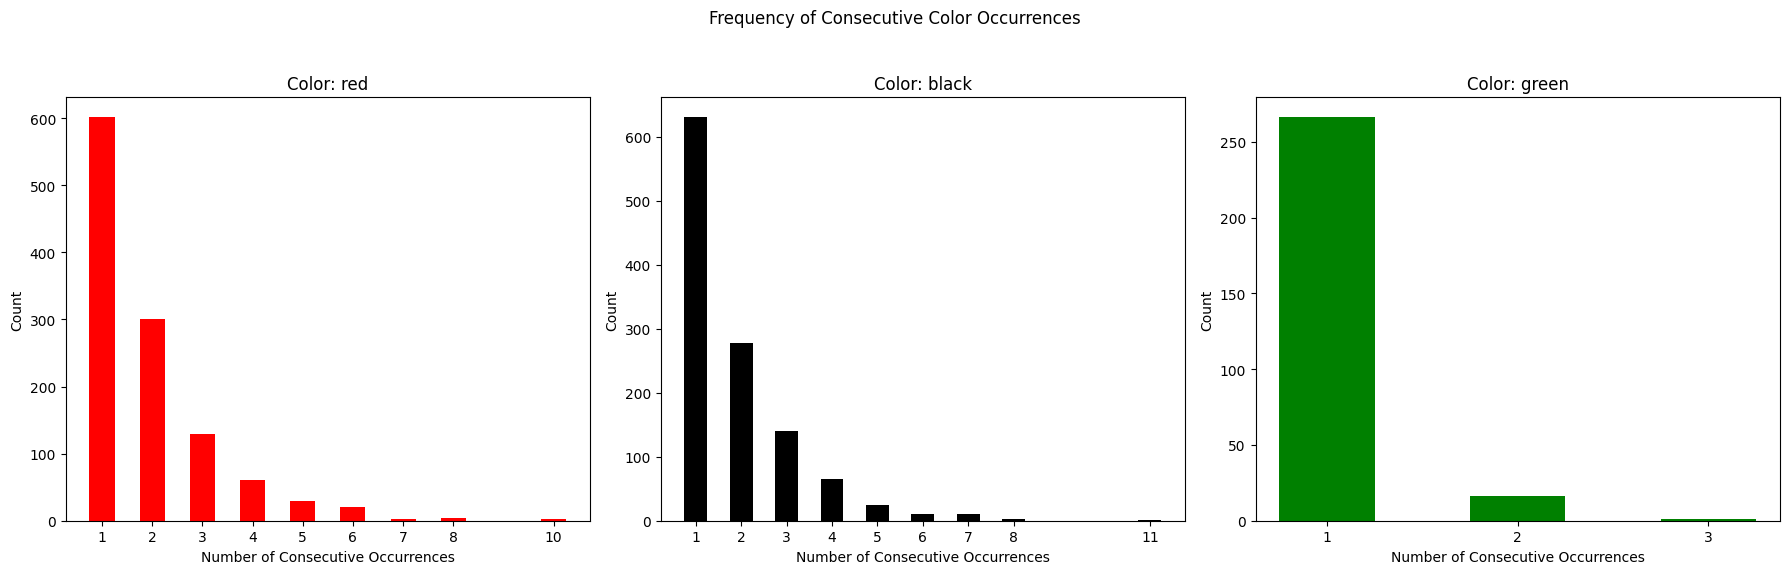

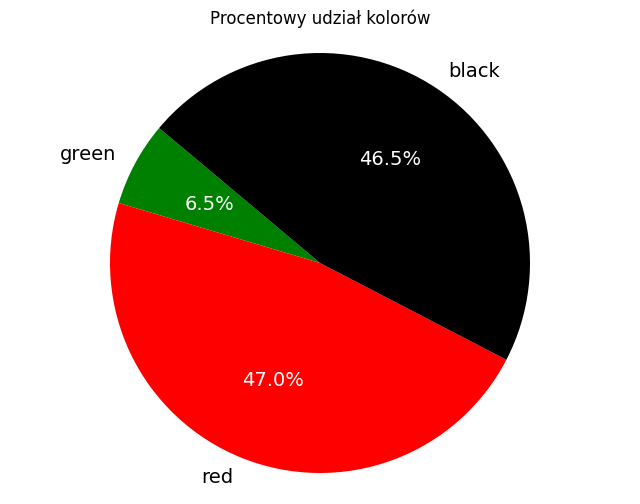


(2,)



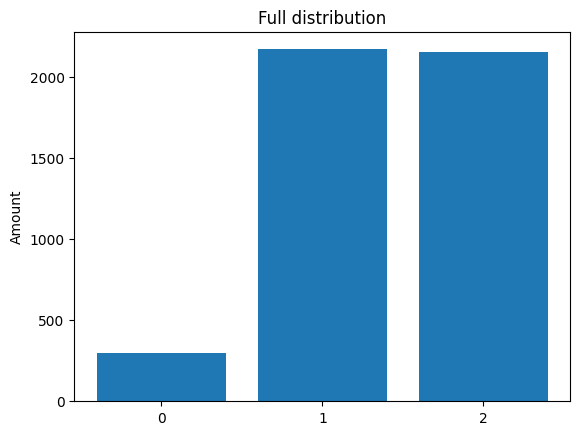

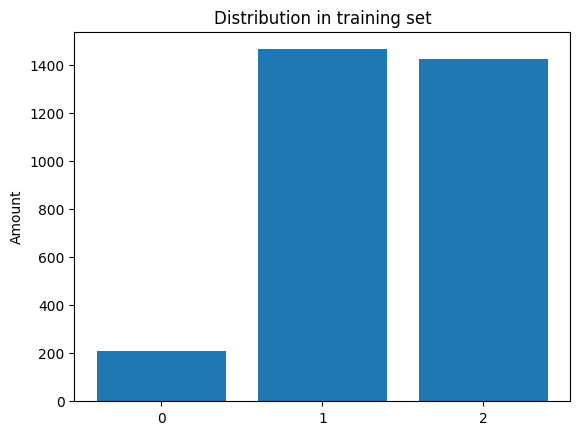

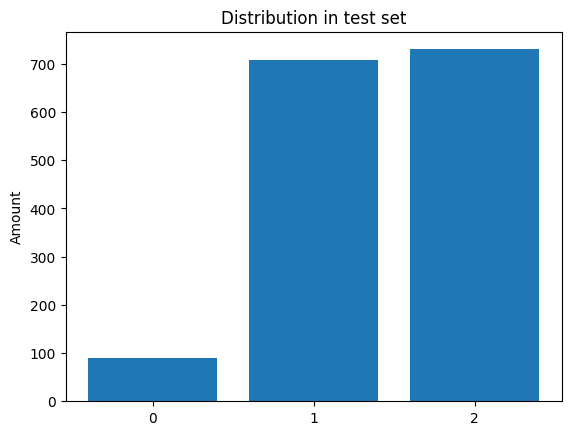

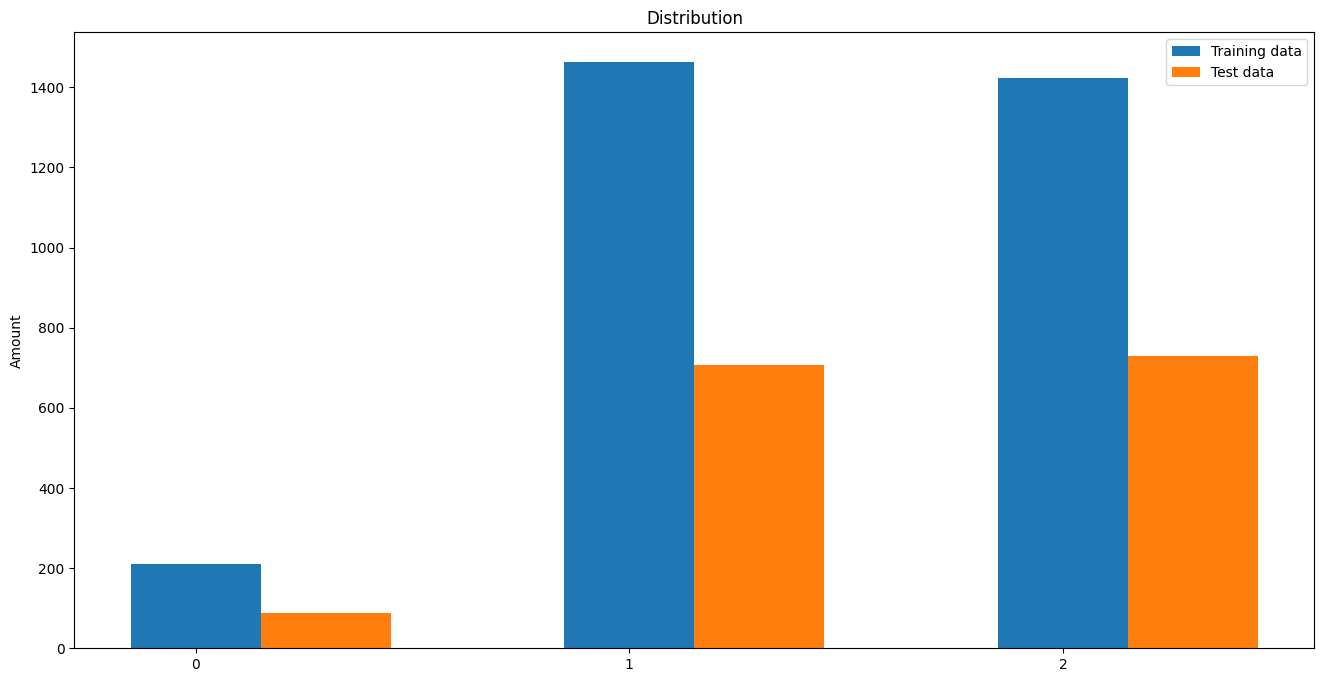


Example sequence from training set: [1 2] and its label: 1

Example sequence from test set: [2 2] and its label: 1


Gaussian Naive Bayes accuracy: 46.33%
Random forest classifier accuracy: 46.40%




2024-06-21 22:40:48.819294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:40:48.819354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:40:48.819367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:40:49.046212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 22:40:49.046252: I external/local_xla/xla/stream_executor

Epoch 1/10


I0000 00:00:1719009650.409977     132 service.cc:145] XLA service 0x7f89bc0021a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719009650.410021     132 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-06-21 22:40:50.459595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-21 22:40:50.644816: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


53/97 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.4498 - loss: 1.0557

I0000 00:00:1719009652.783861     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4567 - loss: 1.0326 - val_accuracy: 0.4784 - val_loss: 0.9339
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4451 - loss: 0.9501 - val_accuracy: 0.4784 - val_loss: 0.9120
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4842 - loss: 0.9158 - val_accuracy: 0.4784 - val_loss: 0.8989
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4545 - loss: 0.9194 - val_accuracy: 0.4633 - val_loss: 0.8914
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.9011 - val_accuracy: 0.4784 - val_loss: 0.8862
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 0.9103 - val_accuracy: 0.4659 - val_loss: 0.8834
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4539 - loss: 0.8974 - val_accuracy: 0.4725 - val_loss: 0.8811
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4432 - loss: 0.8923 - val_accuracy: 0.4633 - val_loss: 0.8802
Ep

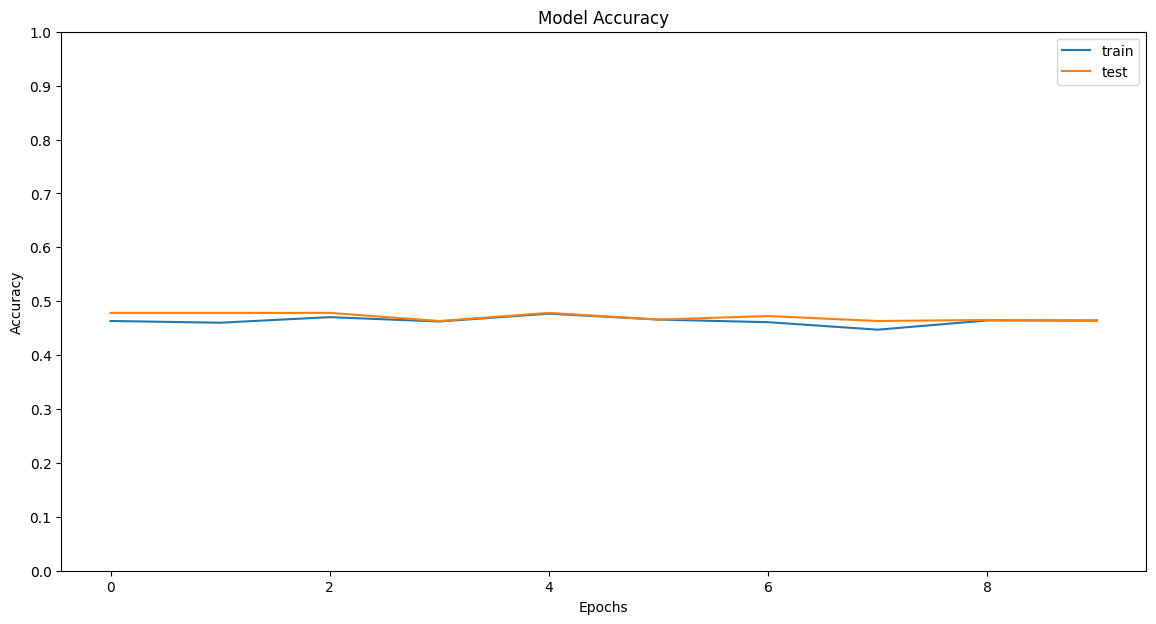

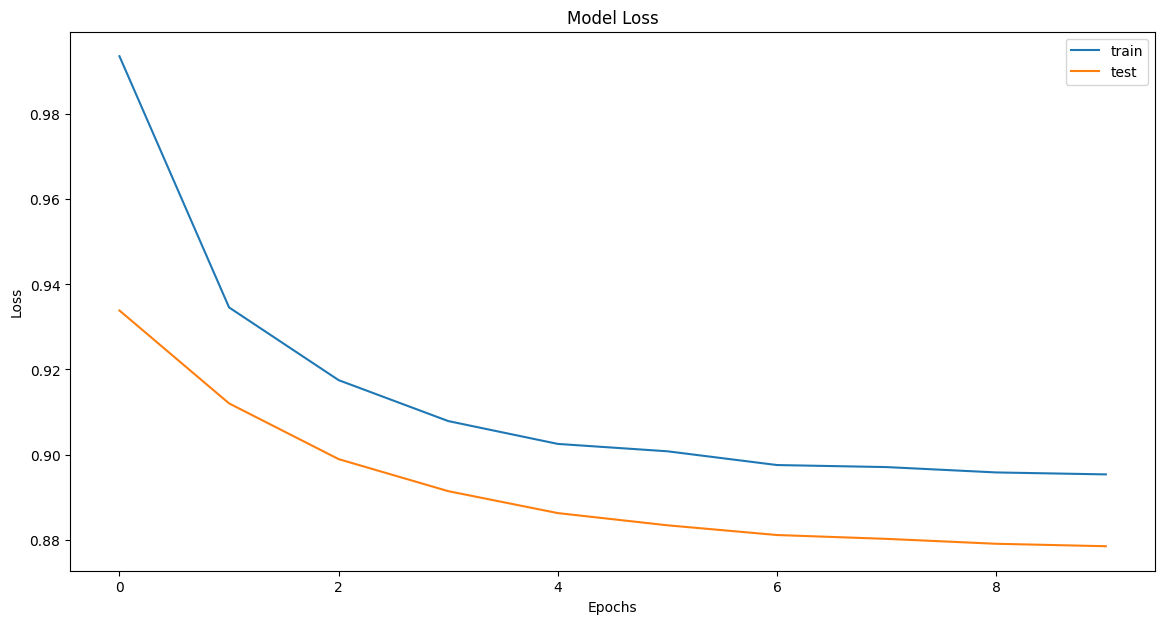

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
Modal accuracy on test set: 46.33%


For threshold set to 0.40, correctness is: 46.33%
For threshold set to 0.45, correctness is: 46.33%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4546 - loss: 1.0150 - val_accuracy: 0.4633 - val_loss: 0.9260
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 0.9304 - val_accuracy: 0.4633 - val_loss: 0.9052
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4733 - loss: 0.9192 - val_accuracy: 0.4633 - val_loss: 0.8942
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4854 - loss: 0.8978 - val_accuracy: 0.4633 - val_loss: 0.8875
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

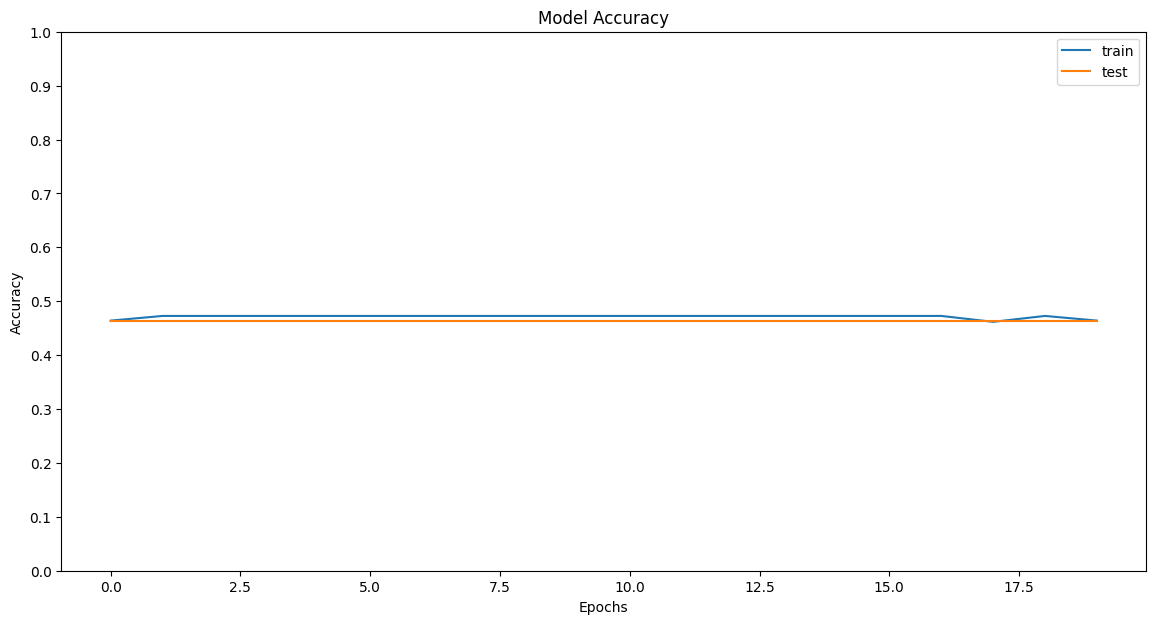

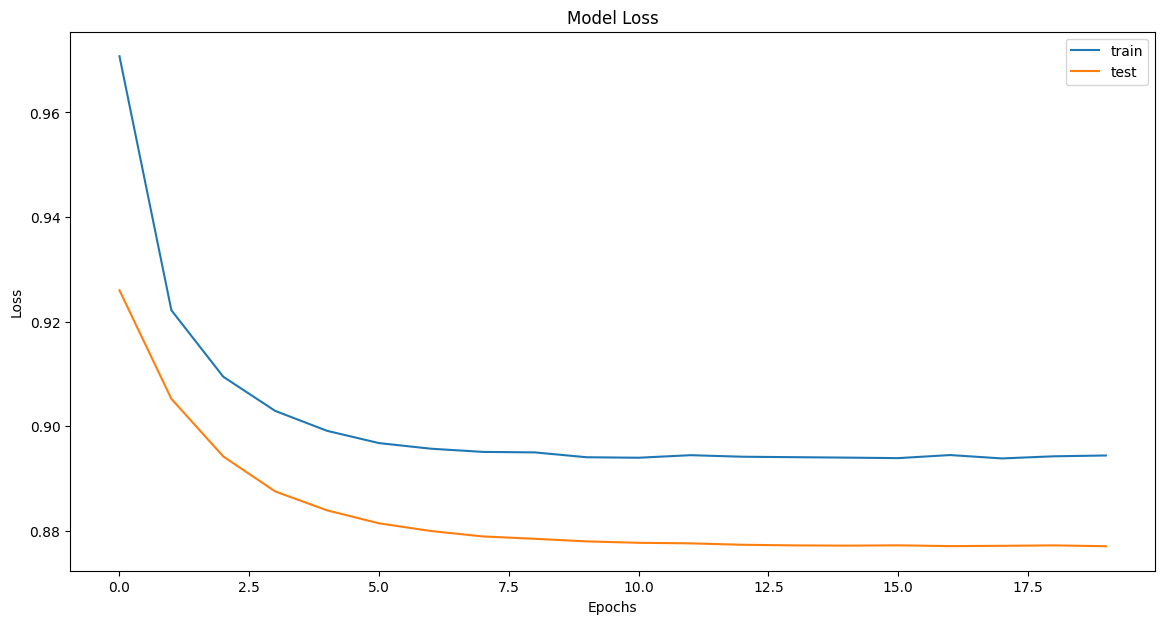

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.33%


For threshold set to 0.40, correctness is: 46.33%
For threshold set to 0.45, correctness is: 46.33%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4607 - loss: 1.0351 - val_accuracy: 0.4731 - val_loss: 0.9353
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4546 - loss: 0.9387 - val_accuracy: 0.4653 - val_loss: 0.9130
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4732 - loss: 0.9221 - val_accuracy: 0.4784 - val_loss: 0.9005
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4769 - loss: 0.9117 - val_accuracy: 0.4633 - val_loss: 0.8926
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

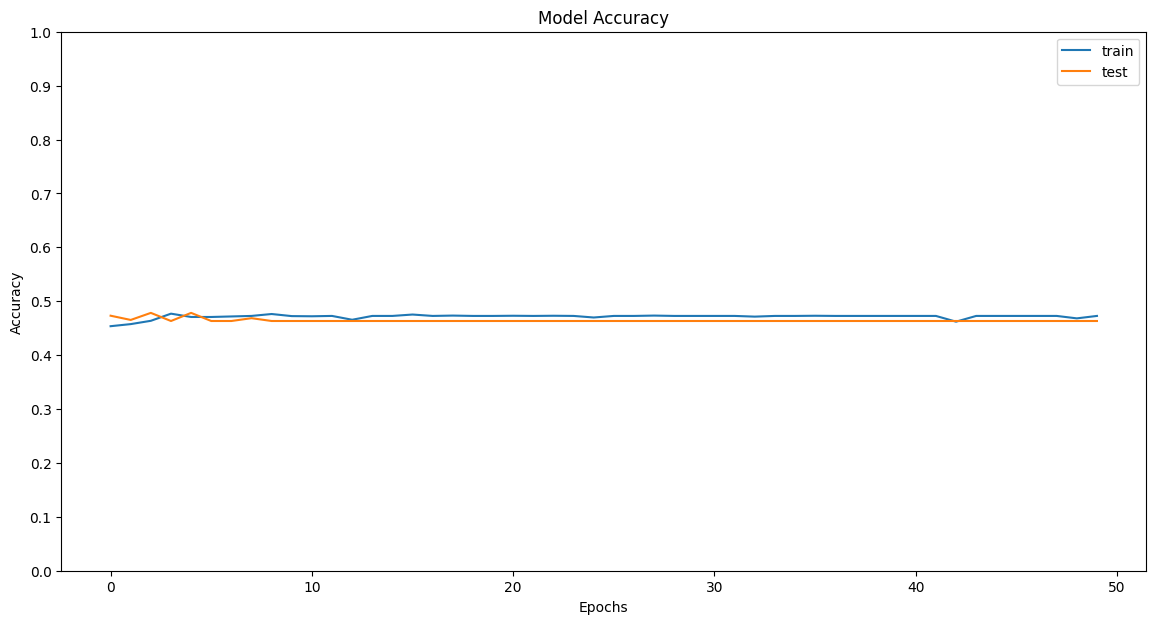

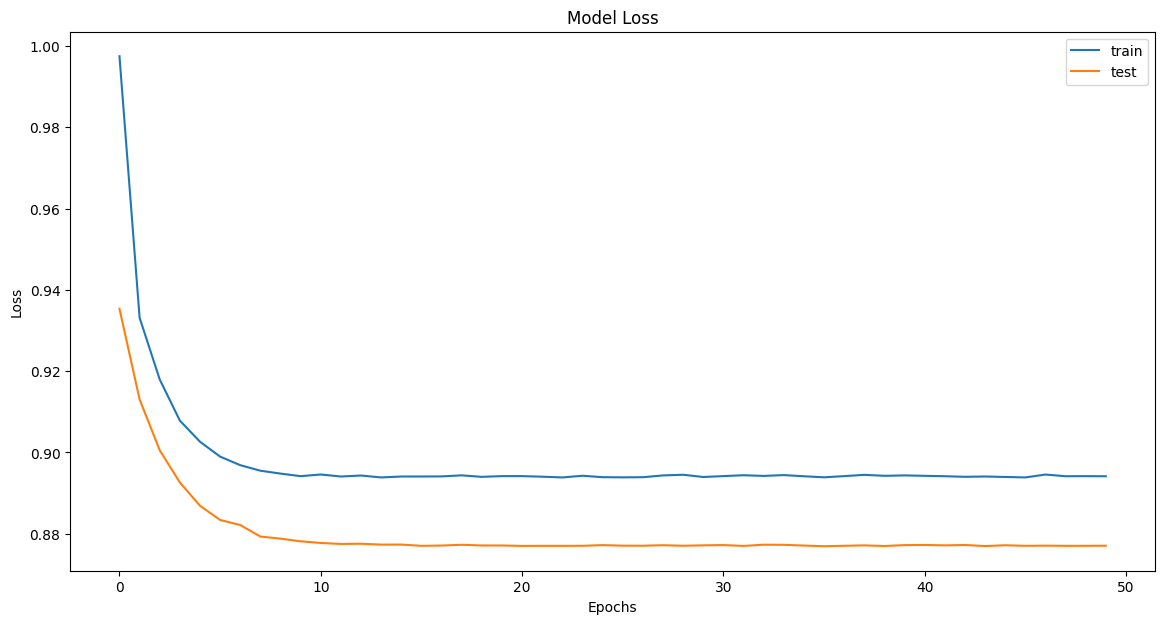

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.33%


For threshold set to 0.40, correctness is: 46.33%
For threshold set to 0.45, correctness is: 46.33%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



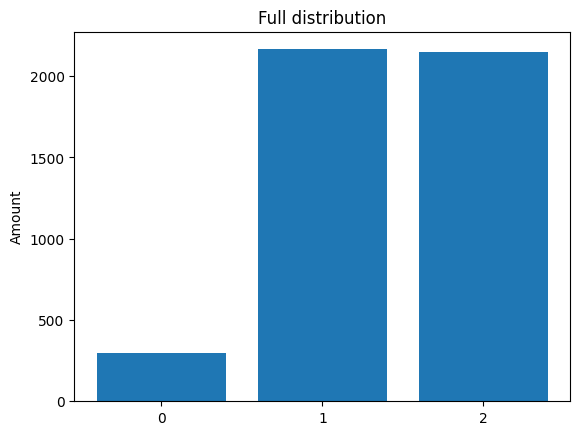

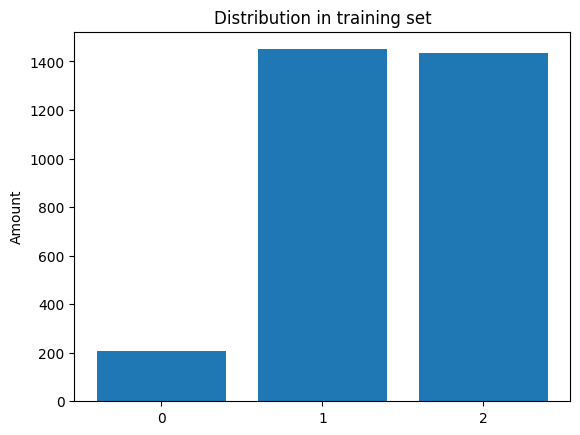

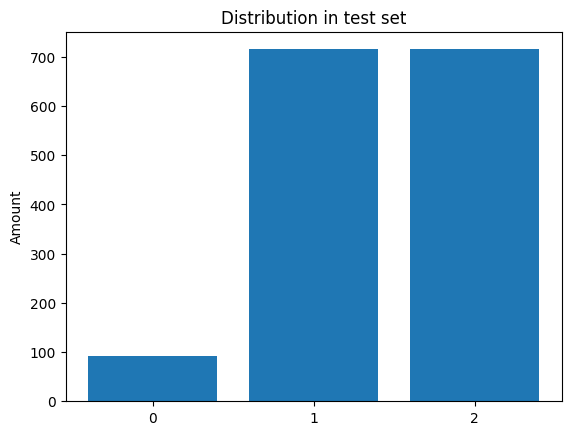

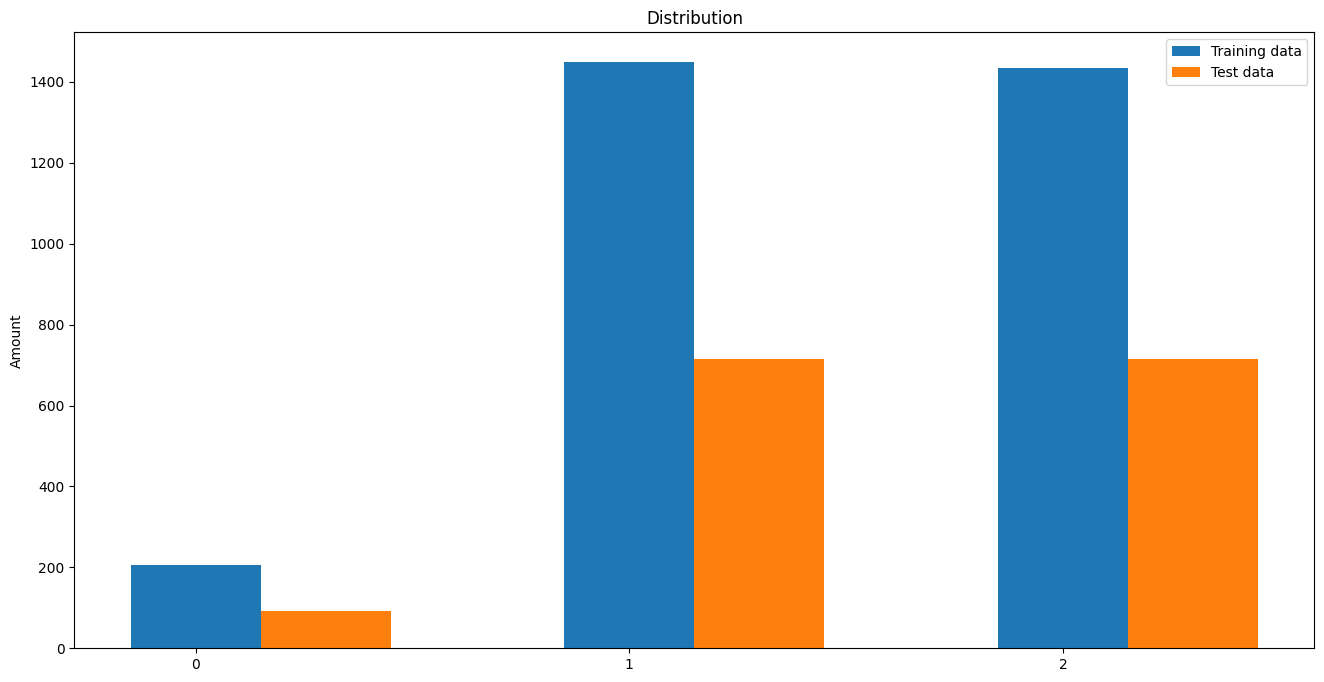


Example sequence from training set: [1 1 1 1 1] and its label: 2

Example sequence from test set: [1 1 2 2 2] and its label: 1


Gaussian Naive Bayes accuracy: 45.93%
Random forest classifier accuracy: 46.39%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3550 - loss: 1.0538 - val_accuracy: 0.4698 - val_loss: 0.9625
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4627 - loss: 0.9588 - val_accuracy: 0.4698 - val_loss: 0.9310
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9346 - val_accuracy: 0.4698 - val_loss: 0.9124
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4807 - loss: 0.9104 - val_accuracy: 0.4698 - val_loss: 0.9007
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4545 - loss: 0.9108 - val_accuracy: 0.4698 - val_loss: 0.8937
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4571 - loss: 0.9005 - val_accuracy: 0.4698 - val_loss: 0.8890
Epoch 7/10
97/97 ━━━━━━━━━━━━━━

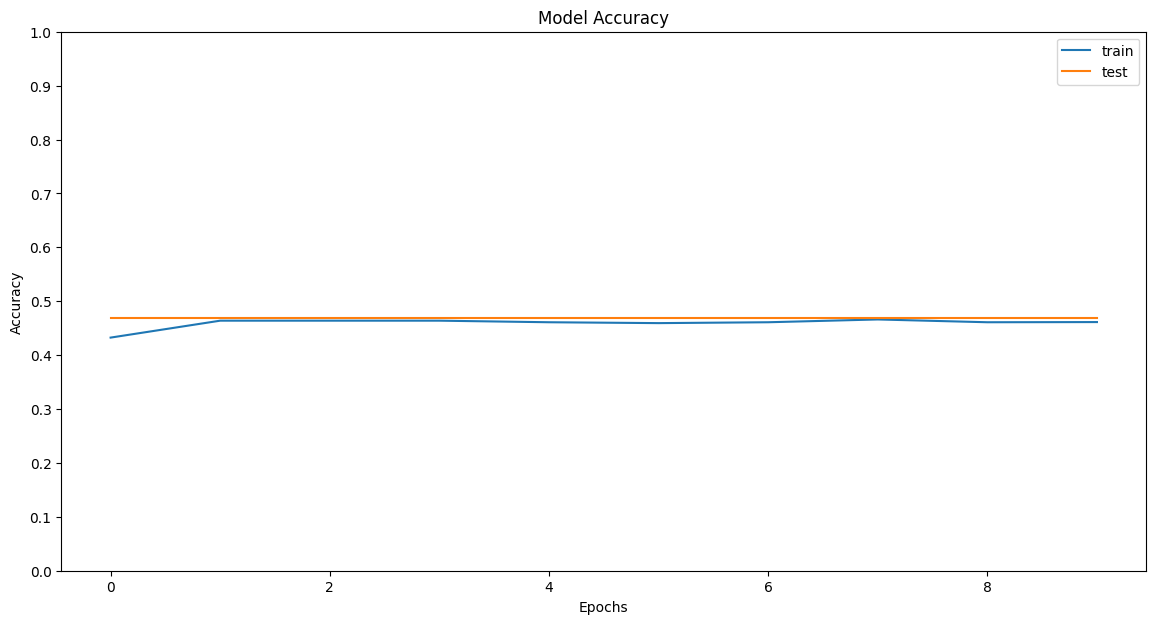

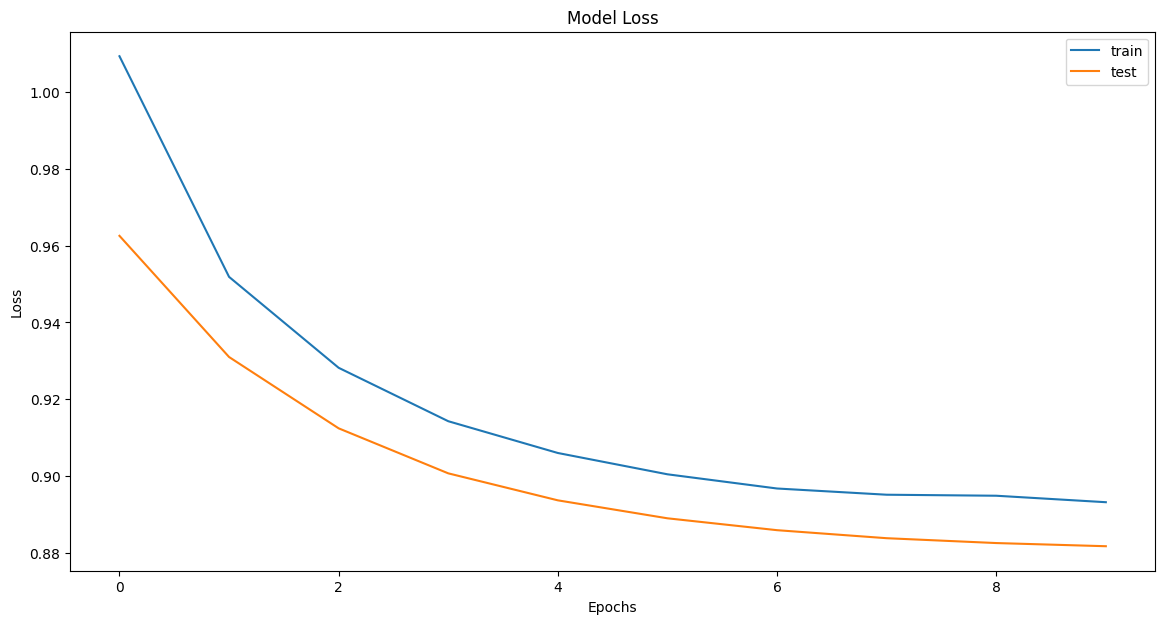

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 46.98%


For threshold set to 0.40, correctness is: 46.98%
For threshold set to 0.45, correctness is: 46.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4683 - loss: 0.9889 - val_accuracy: 0.4698 - val_loss: 0.9086
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4764 - loss: 0.9101 - val_accuracy: 0.4698 - val_loss: 0.8964
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9027 - val_accuracy: 0.4698 - val_loss: 0.8893
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4603 - loss: 0.8930 - val_accuracy: 0.4698 - val_loss: 0.8855
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

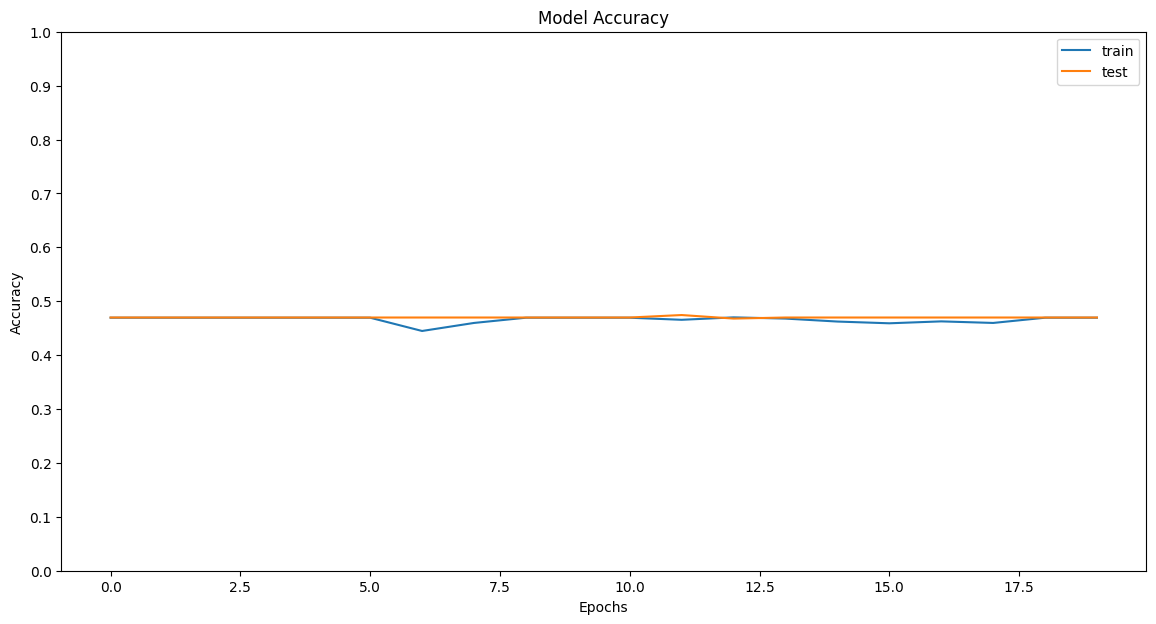

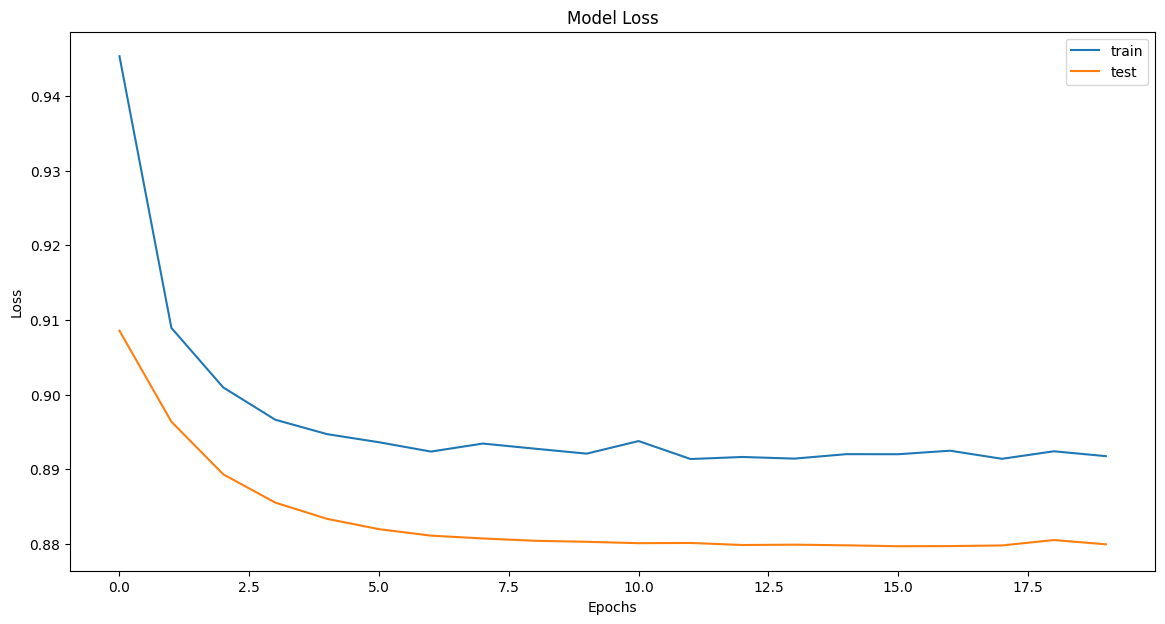

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.98%


For threshold set to 0.40, correctness is: 46.98%
For threshold set to 0.45, correctness is: 46.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3177 - loss: 1.0687 - val_accuracy: 0.4698 - val_loss: 0.9660
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.9628 - val_accuracy: 0.4698 - val_loss: 0.9322
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4632 - loss: 0.9314 - val_accuracy: 0.4698 - val_loss: 0.9127
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 0.9178 - val_accuracy: 0.4698 - val_loss: 0.9009
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

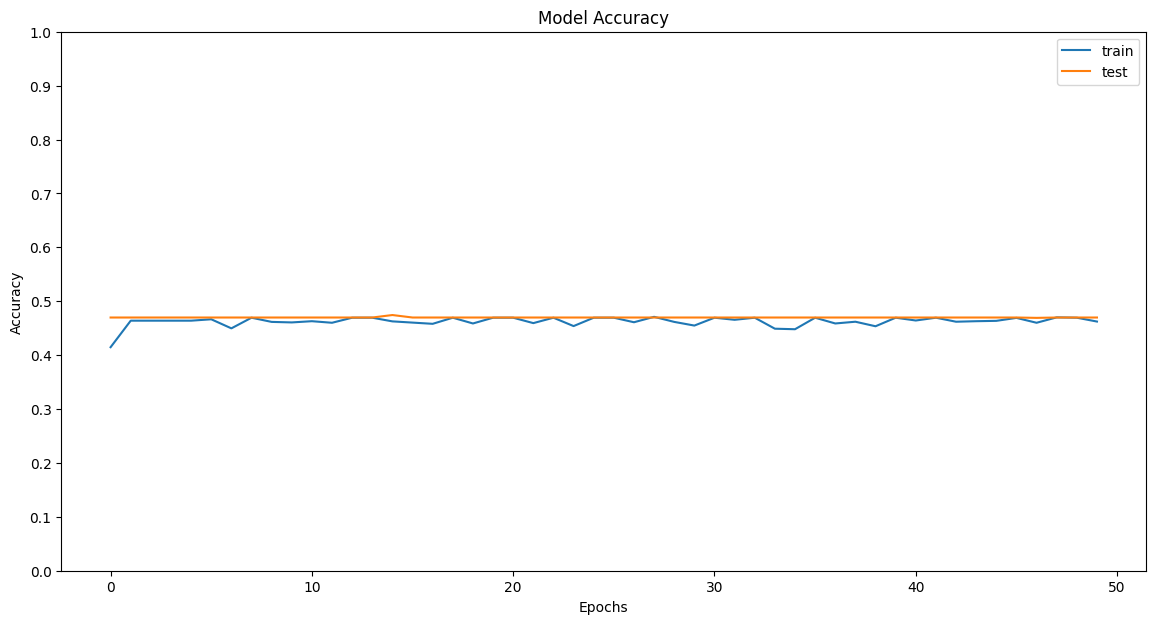

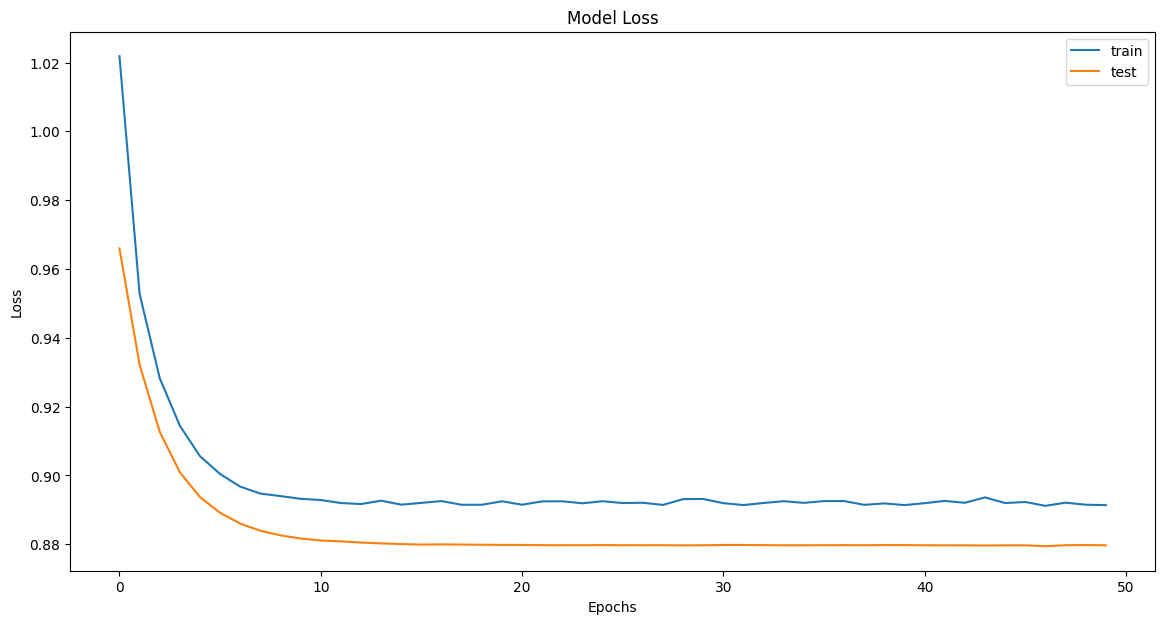

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.98%


For threshold set to 0.40, correctness is: 46.98%
For threshold set to 0.45, correctness is: 46.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



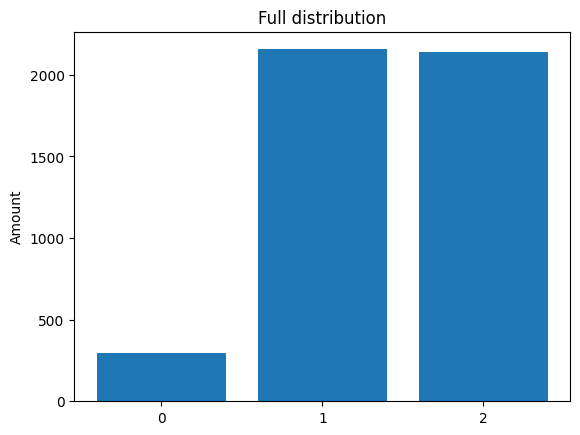

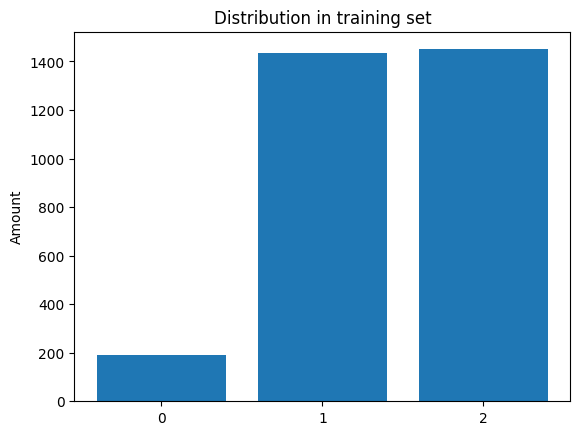

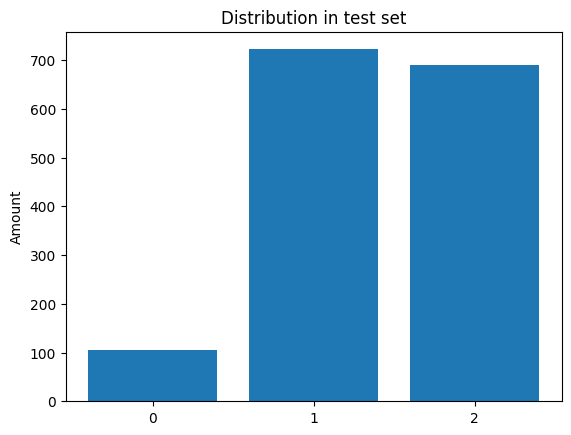

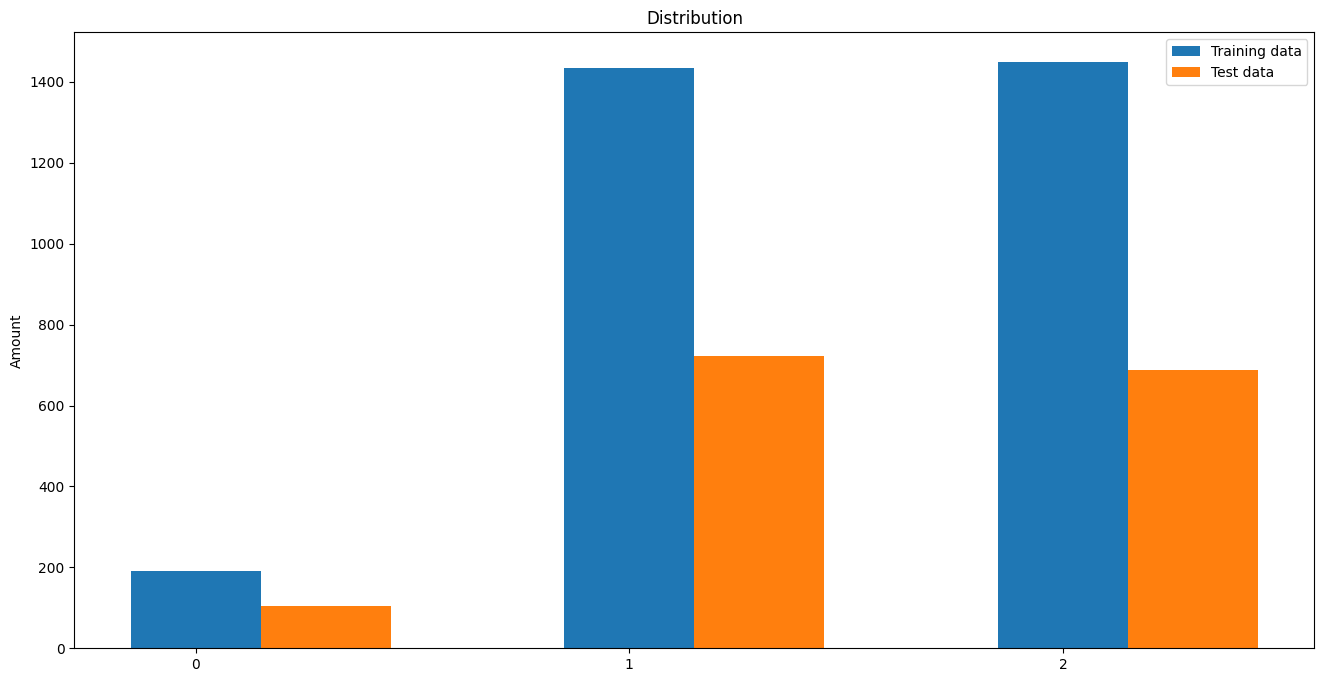


Example sequence from training set: [2 1 1 1 1 2 1 2 1 2] and its label: 1

Example sequence from test set: [1 1 2 2 2 1 2 1 1 2] and its label: 1


Gaussian Naive Bayes accuracy: 45.91%
Random forest classifier accuracy: 45.05%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4661 - loss: 1.0643 - val_accuracy: 0.4545 - val_loss: 1.0195
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4521 - loss: 1.0043 - val_accuracy: 0.4545 - val_loss: 0.9723
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4787 - loss: 0.9527 - val_accuracy: 0.4545 - val_loss: 0.9429
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4661 - loss: 0.9312 - val_accuracy: 0.4492 - val_loss: 0.9199
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4692 - loss: 0.9075 - val_accuracy: 0.4545 - val_loss: 0.9160
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4878 - loss: 0.8870 - val_accuracy: 0.4558 - val_loss: 0.9048
Epoch 7/10


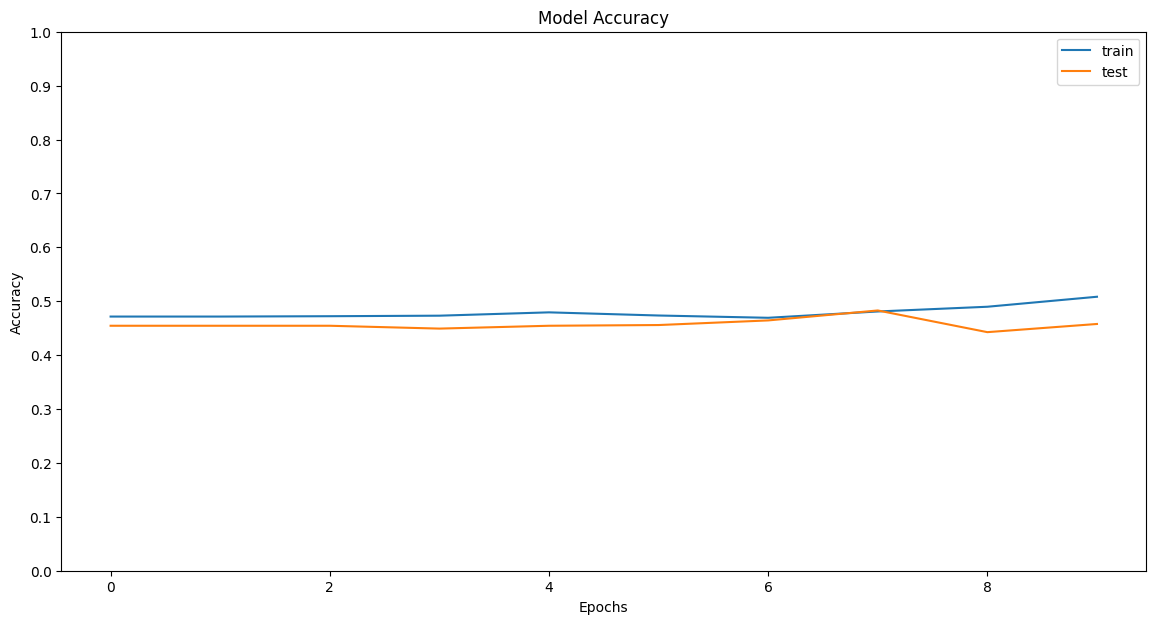

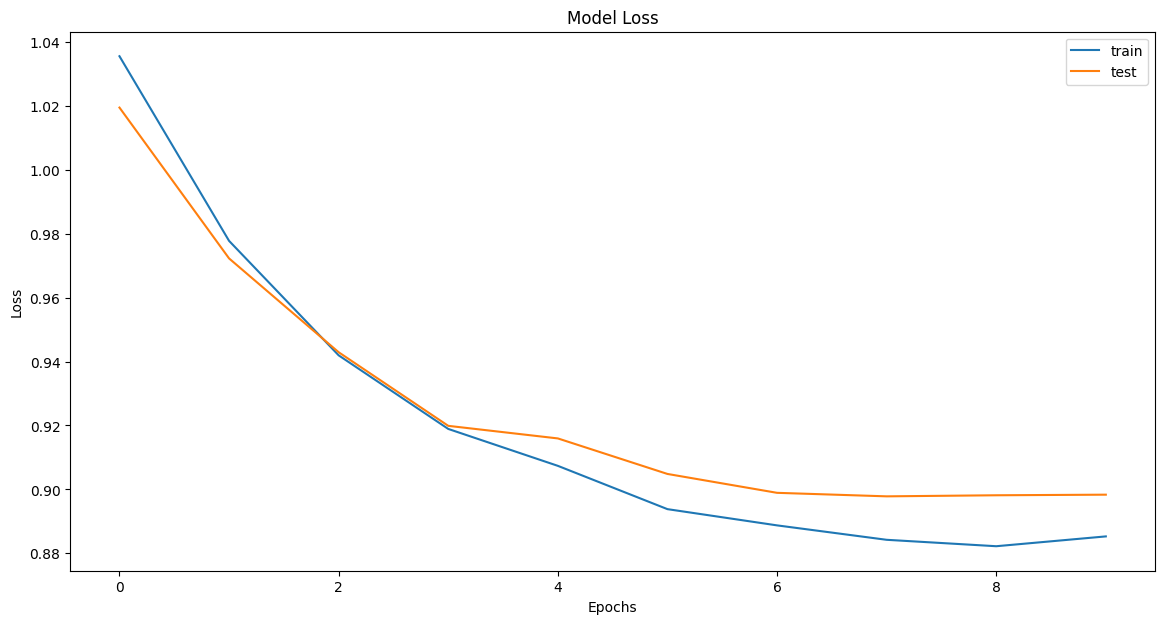

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 45.78%


For threshold set to 0.40, correctness is: 45.78%
For threshold set to 0.45, correctness is: 45.78%
For threshold set to 0.50, correctness is: 46.22%
For threshold set to 0.55, correctness is: 50.00%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4753 - loss: 1.0596 - val_accuracy: 0.4545 - val_loss: 0.9900
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4540 - loss: 0.9691 - val_accuracy: 0.4545 - val_loss: 0.9260
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4635 - loss: 0.9117 - val_accuracy: 0.4545 - val_loss: 0.9099
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4657 - loss: 0.8958 - val_accuracy: 0.4545 - val_loss: 0.9028
Epoch 5/20
97/97 ━━━━━━━

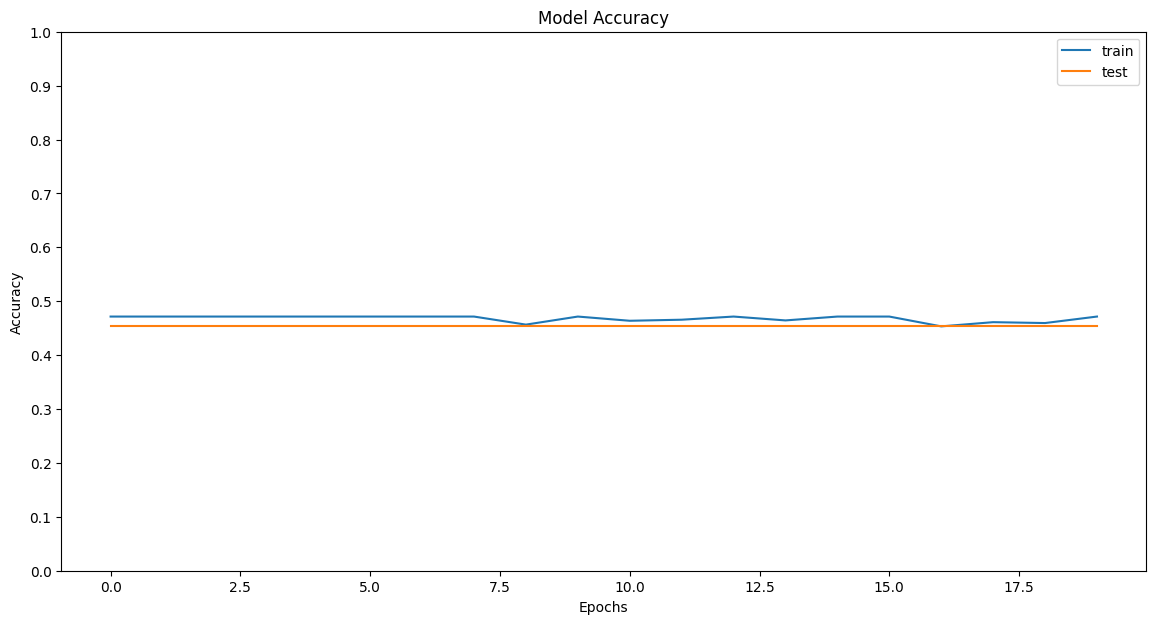

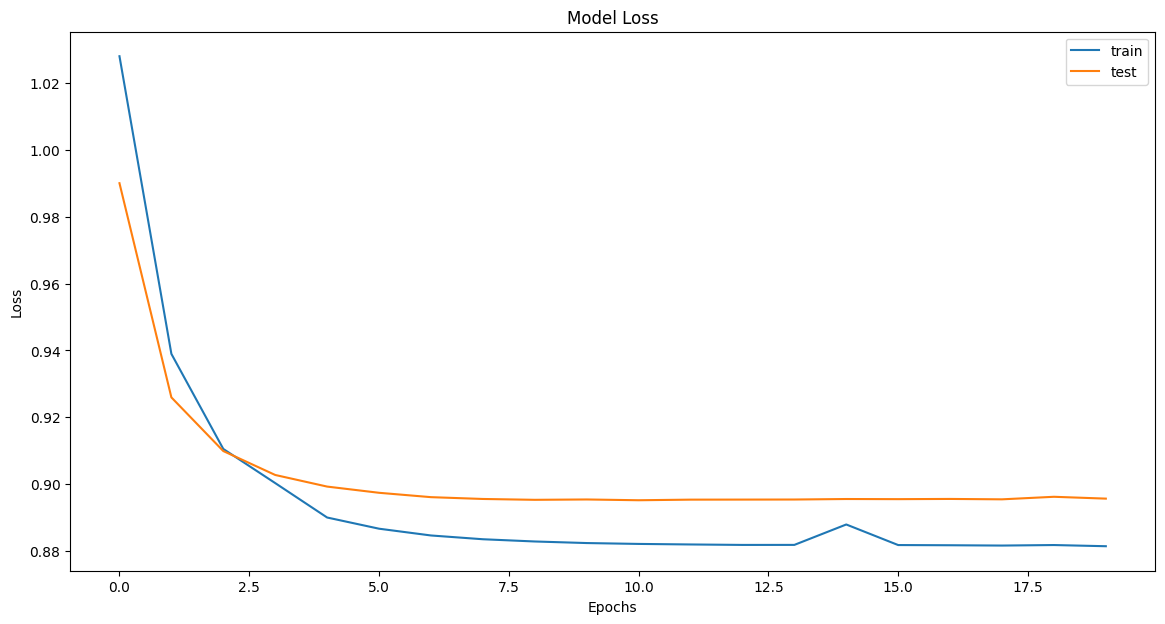

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 45.45%


For threshold set to 0.40, correctness is: 45.45%
For threshold set to 0.45, correctness is: 45.41%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4791 - loss: 0.9653 - val_accuracy: 0.4545 - val_loss: 0.9220
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4878 - loss: 0.9030 - val_accuracy: 0.4545 - val_loss: 0.9092
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4721 - loss: 0.9006 - val_accuracy: 0.4545 - val_loss: 0.9033
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4649 - loss: 0.8923 - val_accuracy: 0.4545 - val_loss: 0.8994
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

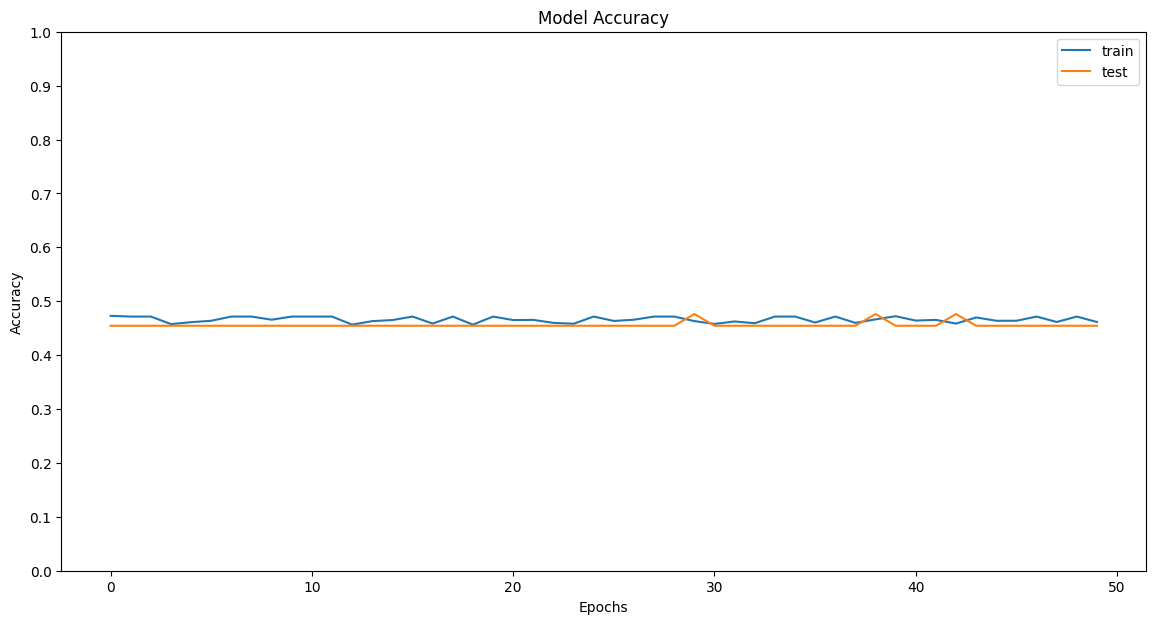

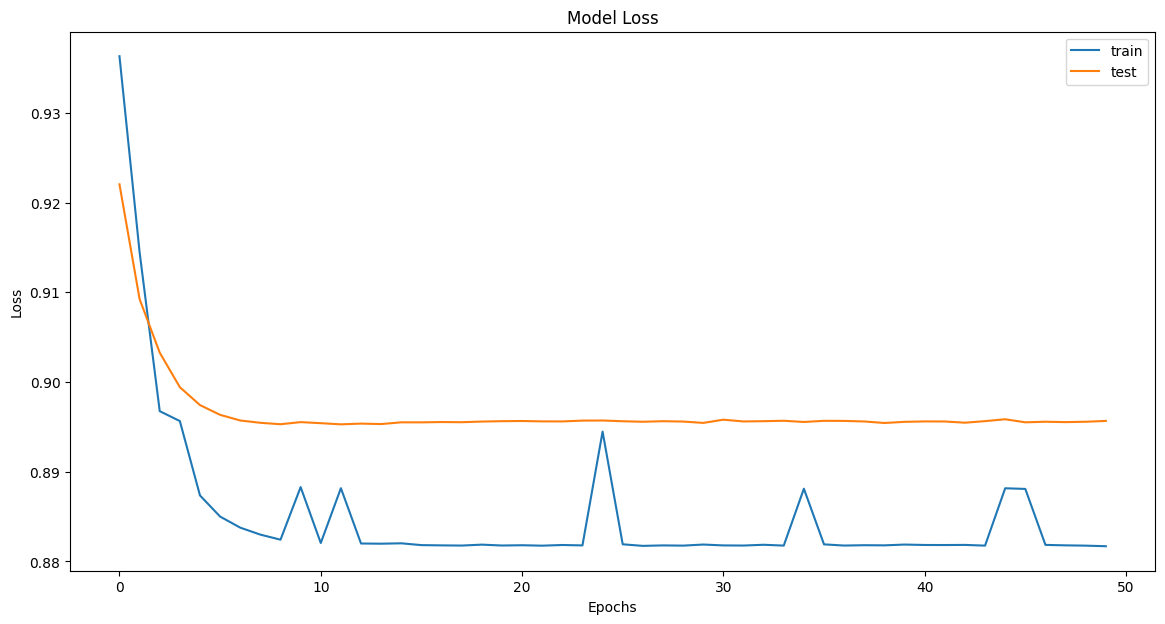

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 45.45%


For threshold set to 0.40, correctness is: 45.45%
For threshold set to 0.45, correctness is: 45.45%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



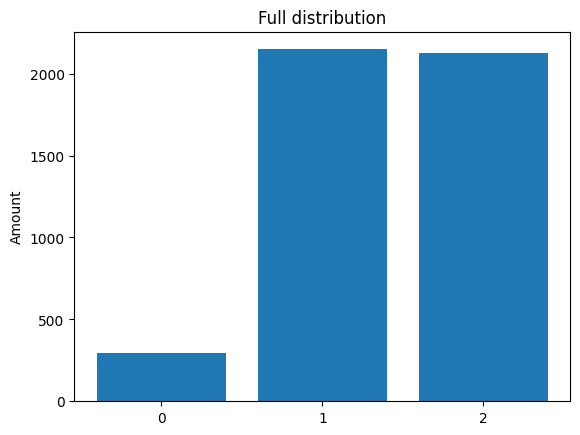

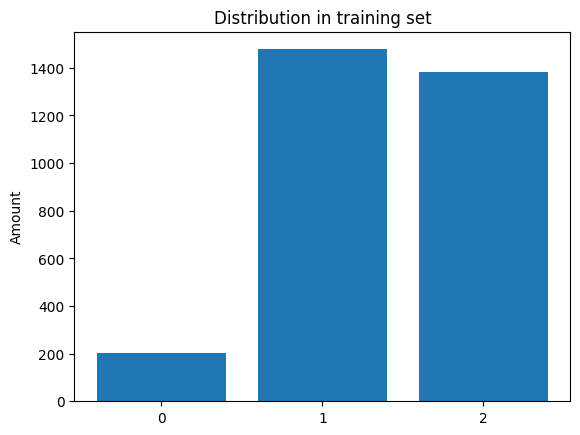

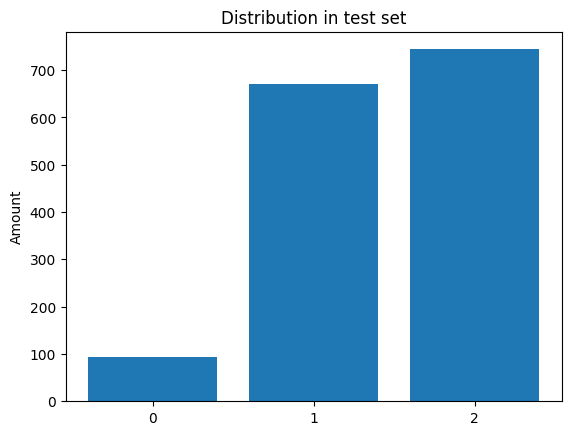

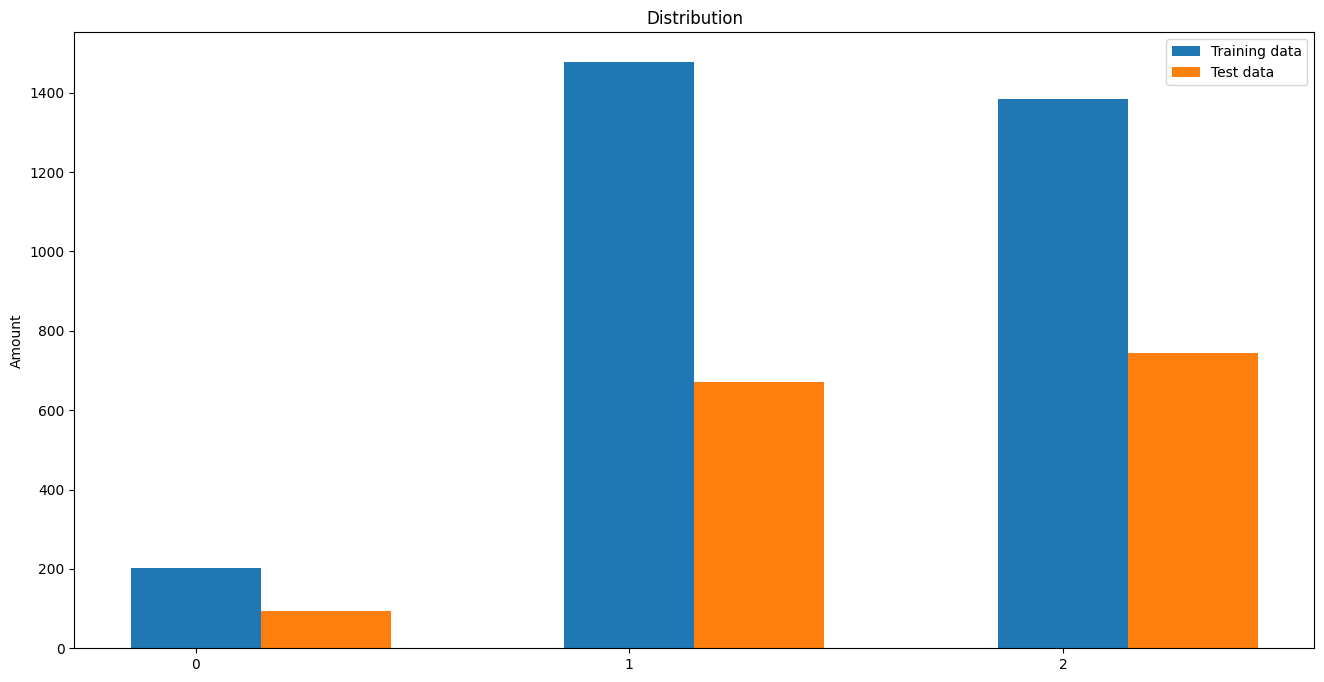


Example sequence from training set: [1 1 1 2 2 1 2 2 2 1 2 2 2 2 2] and its label: 2

Example sequence from test set: [2 1 0 1 2 1 2 0 2 2 1 2 1 0 2] and its label: 1


Gaussian Naive Bayes accuracy: 46.19%
Random forest classifier accuracy: 46.72%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3728 - loss: 1.0940 - val_accuracy: 0.4930 - val_loss: 0.9371
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4609 - loss: 0.9319 - val_accuracy: 0.4930 - val_loss: 0.9163
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4570 - loss: 0.9196 - val_accuracy: 0.4447 - val_loss: 0.9062
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4880 - loss: 0.8965 - val_accuracy: 0.4447 - val_loss: 0.8997
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4823 - loss: 0.9052 - val_accuracy: 0.4447 - val_loss: 0.8963
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4963 - loss: 0.8907 - val_accuracy: 0.4447 - val_loss

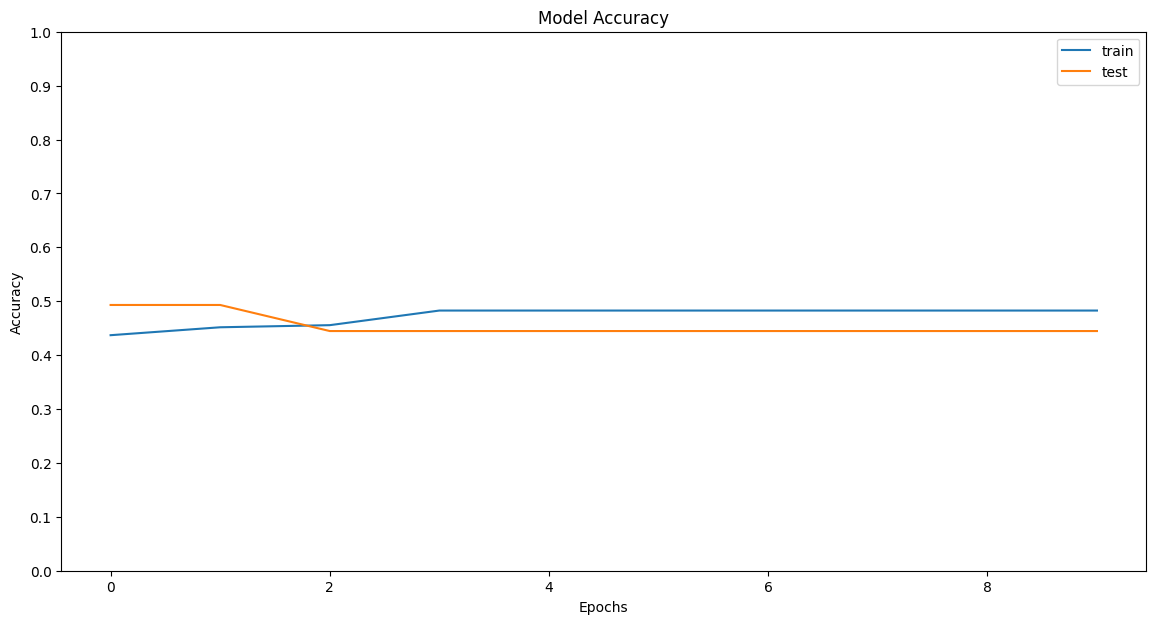

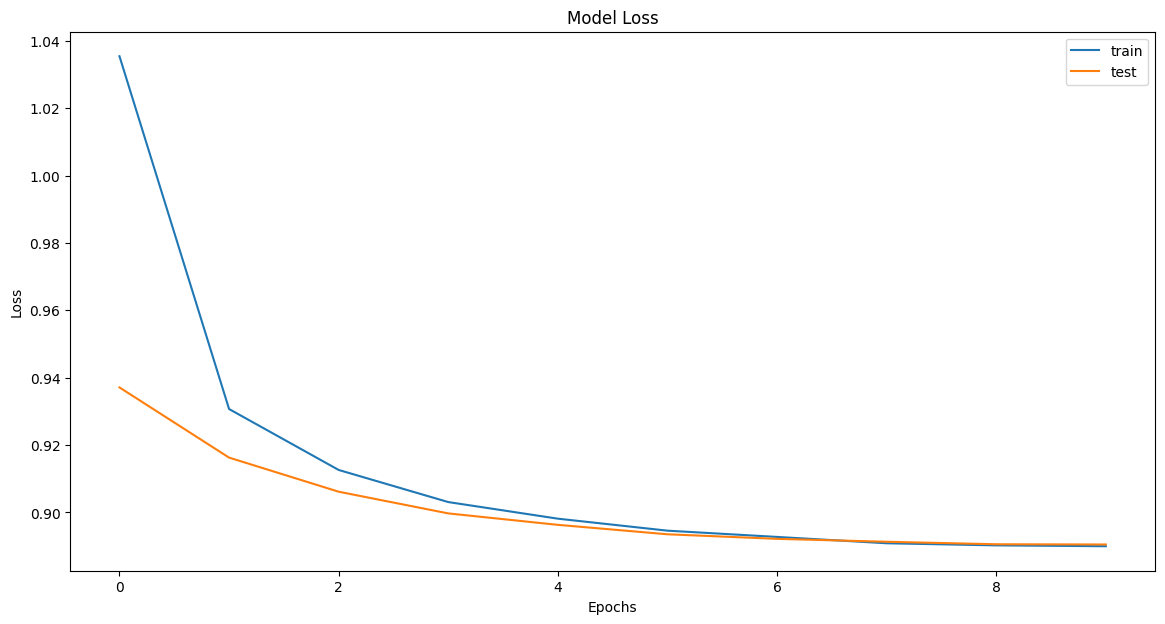

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 44.47%


For threshold set to 0.40, correctness is: 44.47%
For threshold set to 0.45, correctness is: 44.47%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4519 - loss: 1.0062 - val_accuracy: 0.4930 - val_loss: 0.9353
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4514 - loss: 0.9377 - val_accuracy: 0.4930 - val_loss: 0.9162
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4638 - loss: 0.9193 - val_accuracy: 0.4447 - val_loss: 0.9056
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4641 - loss: 0.9090 - val_accuracy: 0.4447 - val_loss: 0.9000
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

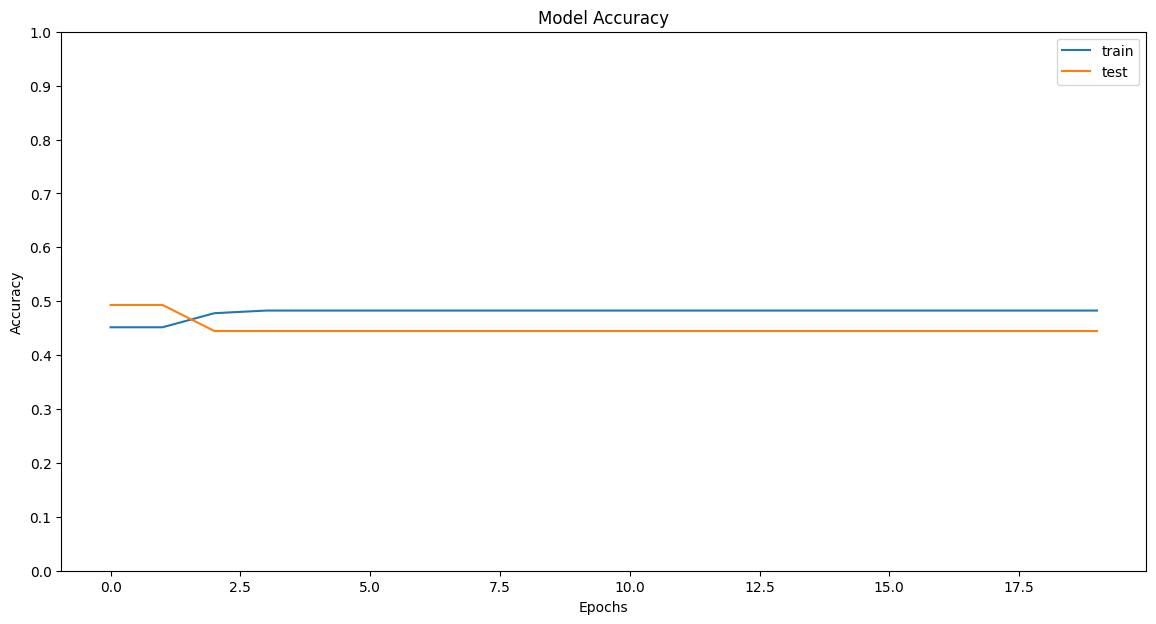

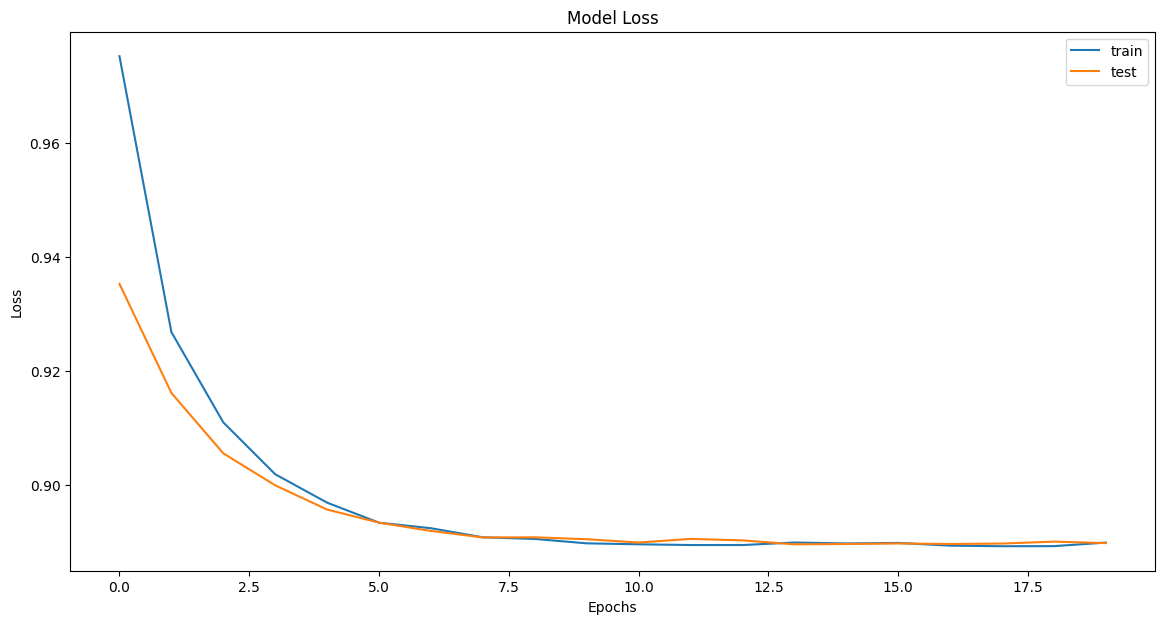

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 44.47%


For threshold set to 0.40, correctness is: 44.47%
For threshold set to 0.45, correctness is: 44.47%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4452 - loss: 0.9781 - val_accuracy: 0.4930 - val_loss: 0.9195
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 0.9154 - val_accuracy: 0.4447 - val_loss: 0.9062
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4847 - loss: 0.9120 - val_accuracy: 0.4447 - val_loss: 0.8995
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4956 - loss: 0.8989 - val_accuracy: 0.4447 - val_loss: 0.8951
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

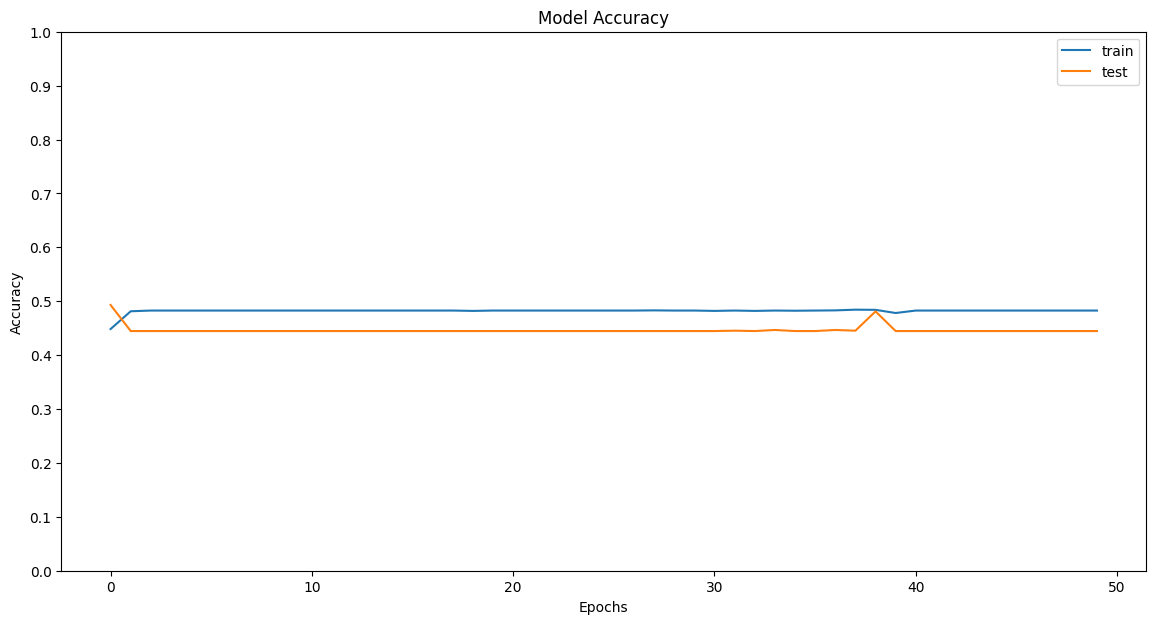

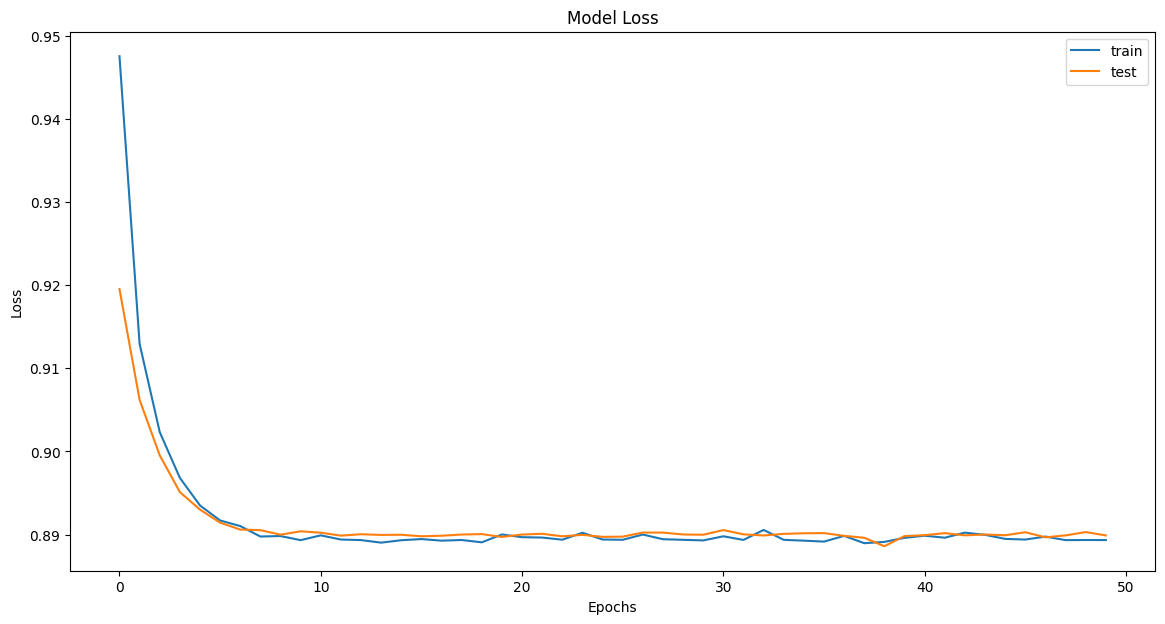

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 44.47%


For threshold set to 0.40, correctness is: 44.47%
For threshold set to 0.45, correctness is: 44.47%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



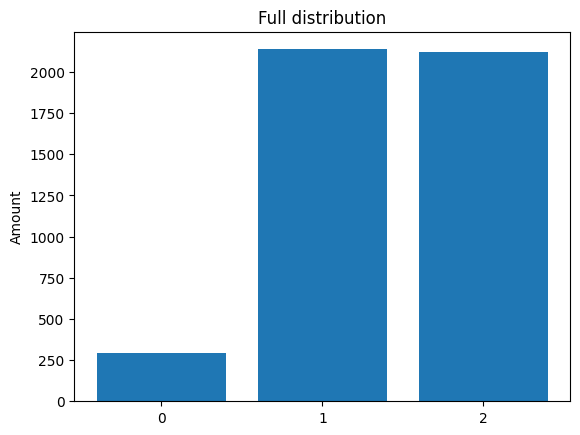

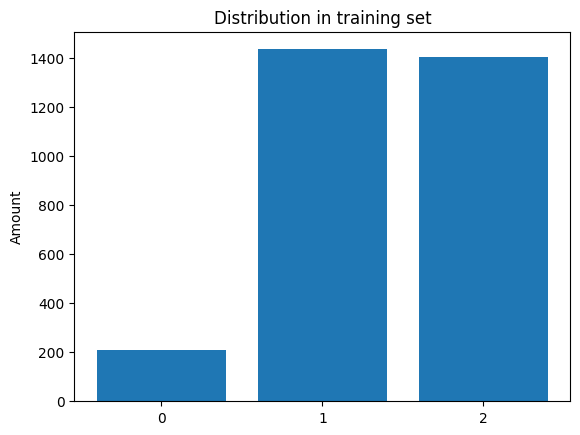

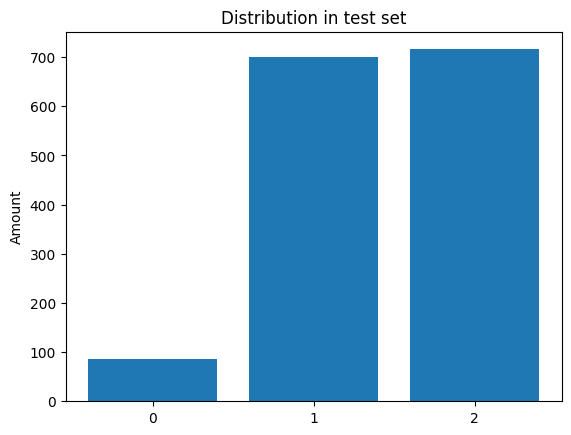

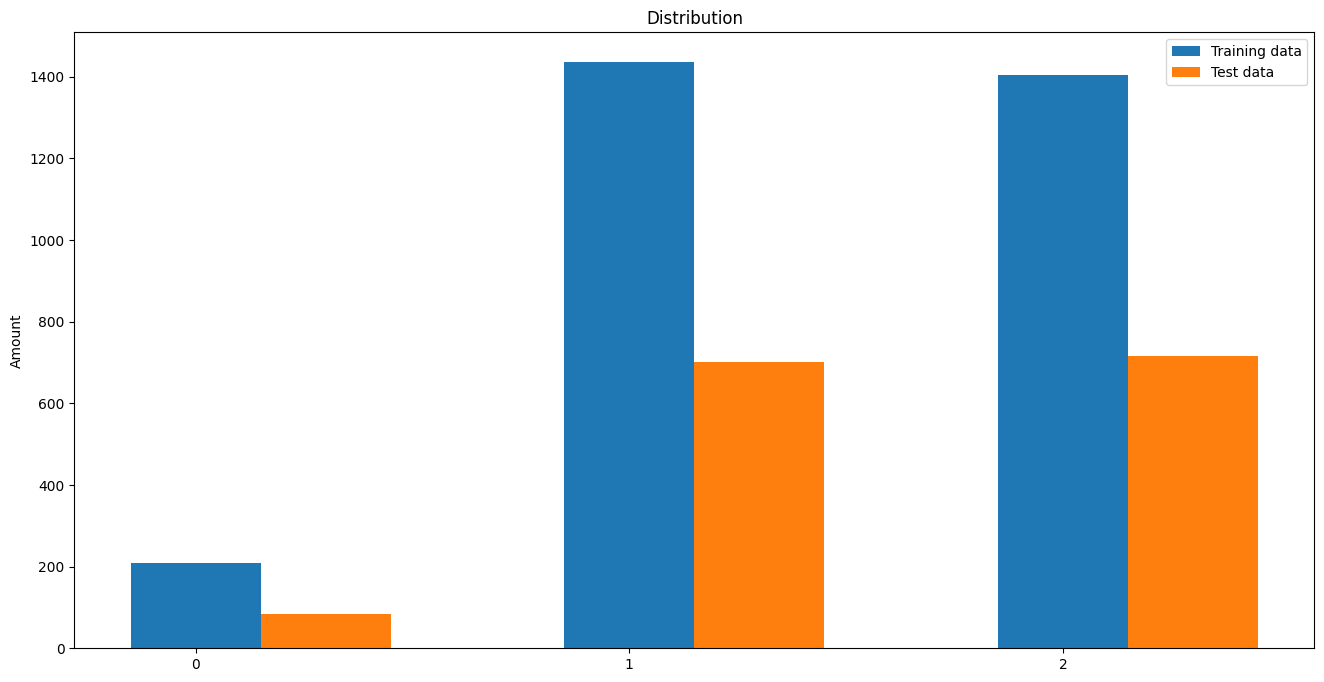


Example sequence from training set: [2 2 1 2 1 1 1 0 1 1 1 1 1 1 1 1 2 2 2 1] and its label: 1

Example sequence from test set: [2 2 1 2 2 1 1 1 1 0 2 1 2 2 2 2 1 2 2 2] and its label: 2


Gaussian Naive Bayes accuracy: 47.07%
Random forest classifier accuracy: 50.07%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4706 - loss: 1.0625 - val_accuracy: 0.4667 - val_loss: 0.9620
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4874 - loss: 0.9577 - val_accuracy: 0.4767 - val_loss: 0.9279
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4744 - loss: 0.9335 - val_accuracy: 0.4667 - val_loss: 0.9095
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4621 - loss: 0.9294 - val_accuracy: 0.4640 - val_loss: 0.8953
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4708 - loss: 0.9156 - val_accuracy: 0.4667 - val_loss: 0.8891
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4571 - loss: 0.9059 - val_accurac

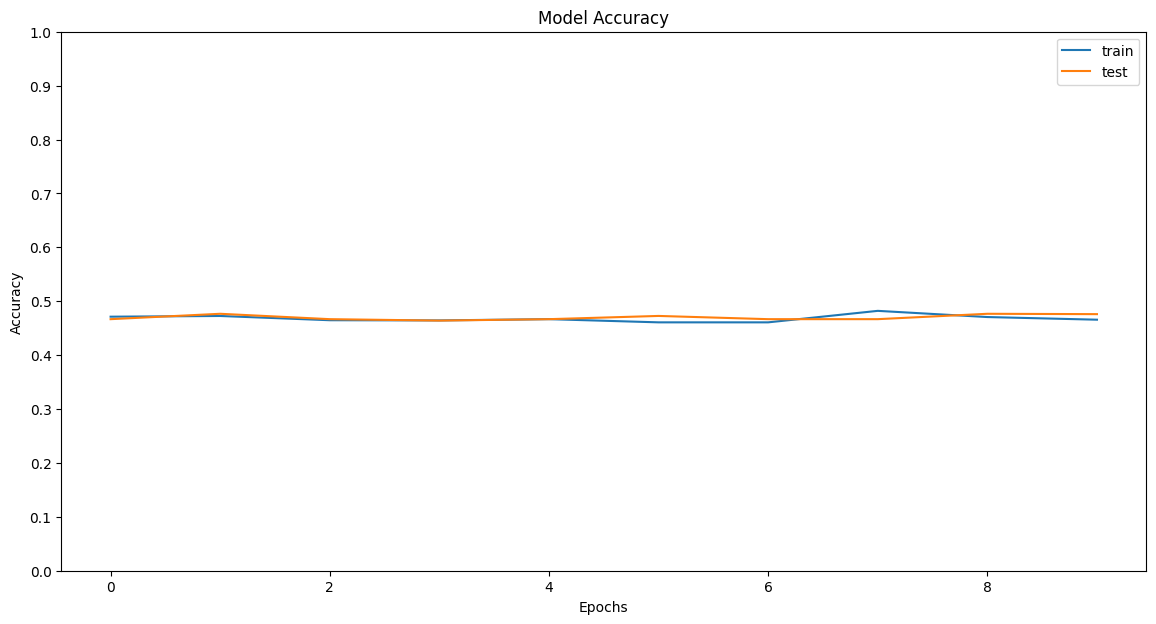

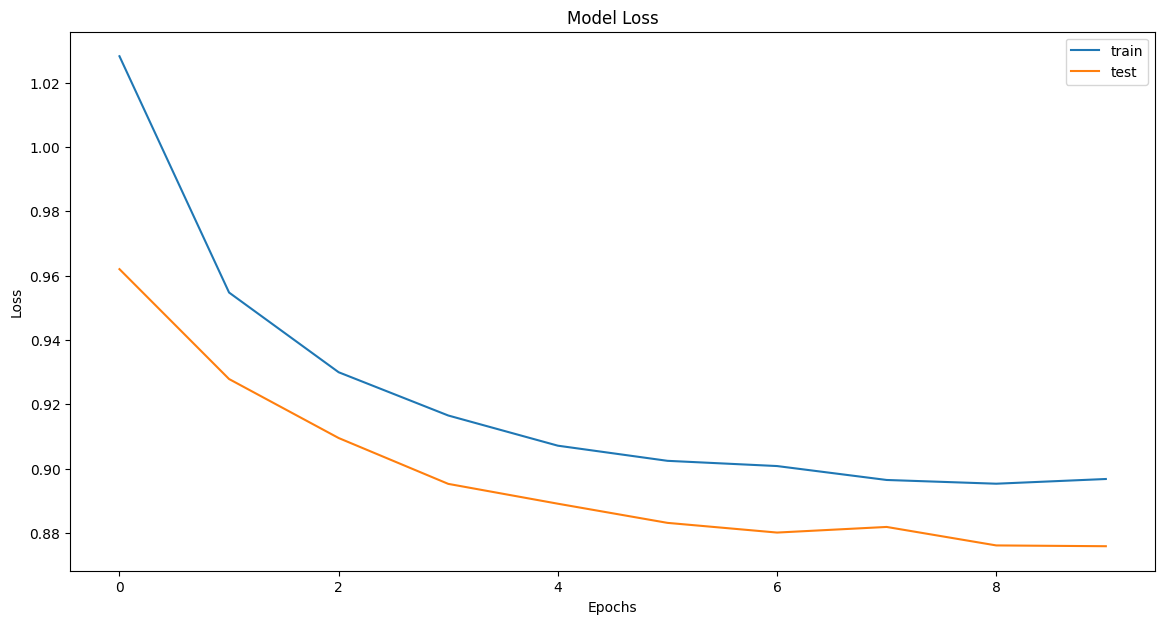

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 47.60%


For threshold set to 0.40, correctness is: 47.60%
For threshold set to 0.45, correctness is: 47.60%
For threshold set to 0.50, correctness is: 55.71%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4112 - loss: 1.0612 - val_accuracy: 0.4667 - val_loss: 0.9745
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4670 - loss: 0.9697 - val_accuracy: 0.4667 - val_loss: 0.9235
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4769 - loss: 0.9282 - val_accuracy: 0.4674 - val_loss: 0.9004
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4728 - loss: 0.9066 - val_accuracy: 0.4674 - val_loss: 0.8891
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3

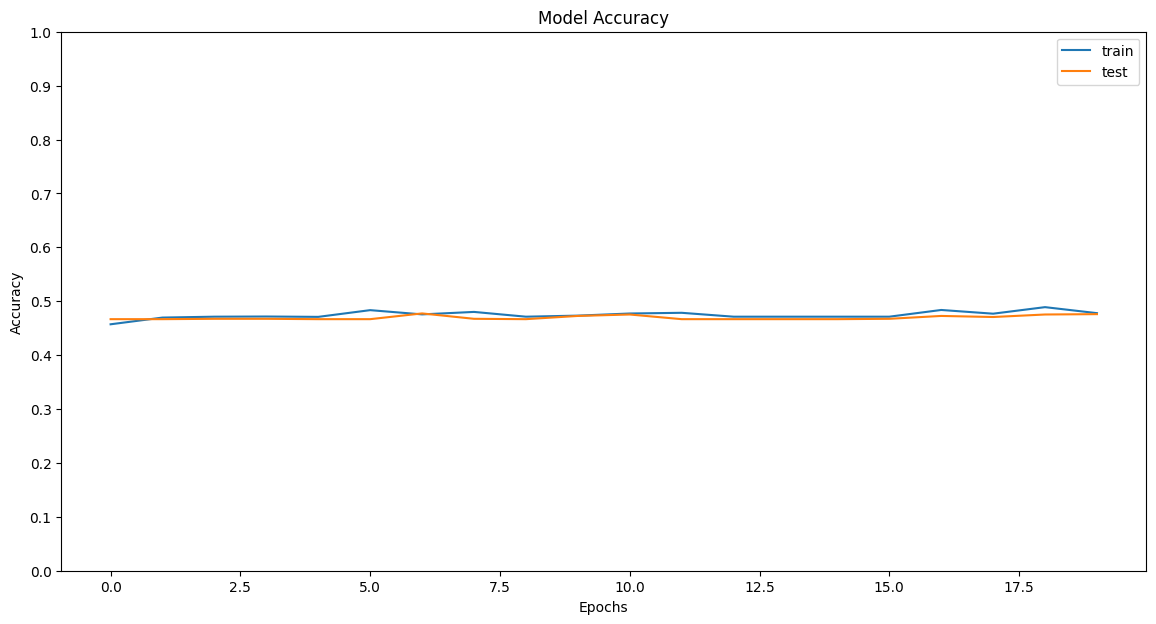

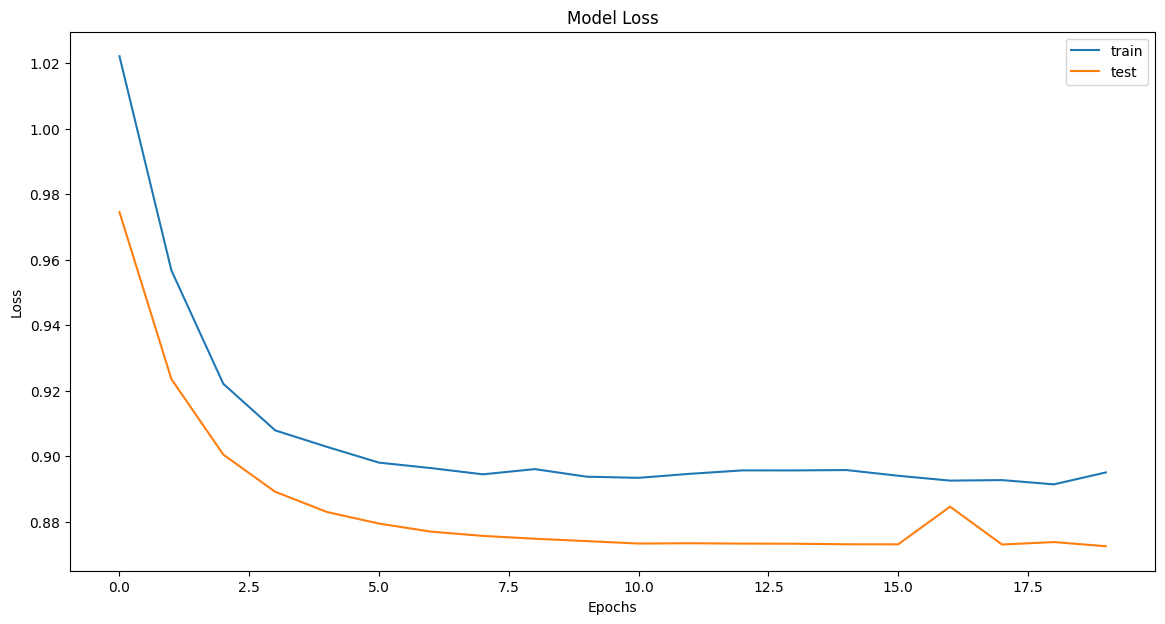

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 47.60%


For threshold set to 0.40, correctness is: 47.60%
For threshold set to 0.45, correctness is: 47.60%
For threshold set to 0.50, correctness is: 59.09%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4771 - loss: 1.0156 - val_accuracy: 0.4667 - val_loss: 0.9434
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4667 - loss: 0.9408 - val_accuracy: 0.4667 - val_loss: 0.9161
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4647 - loss: 0.9270 - val_accuracy: 0.4674 - val_loss: 0.8989
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4849 - loss: 0.9140 - val_accuracy: 0.4760 - val_loss: 0.8897
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2

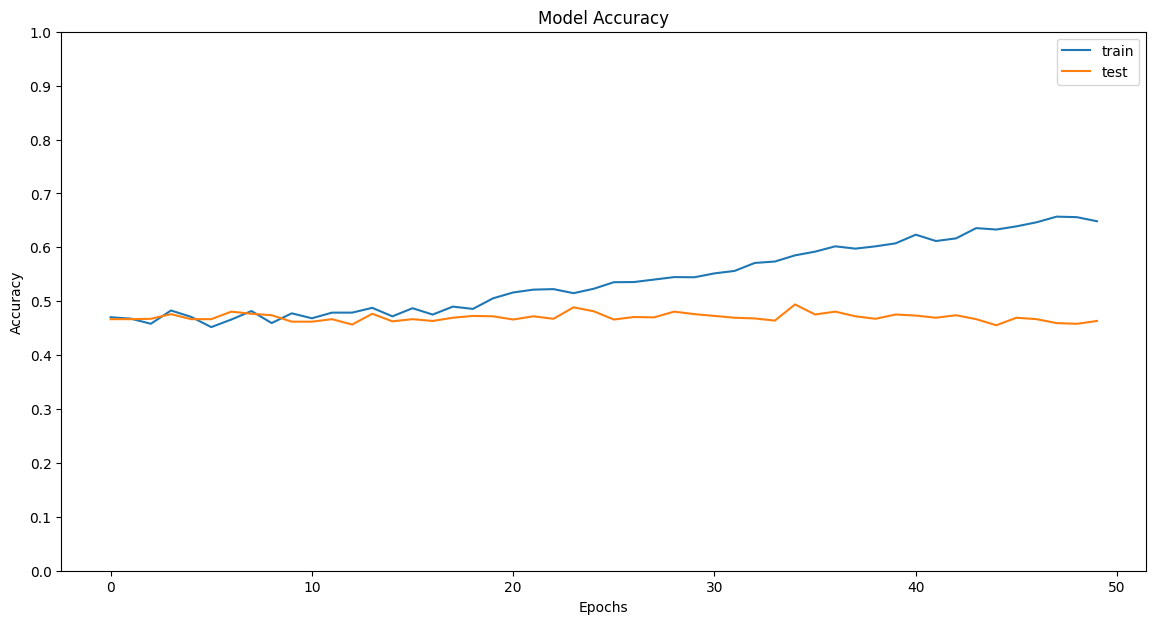

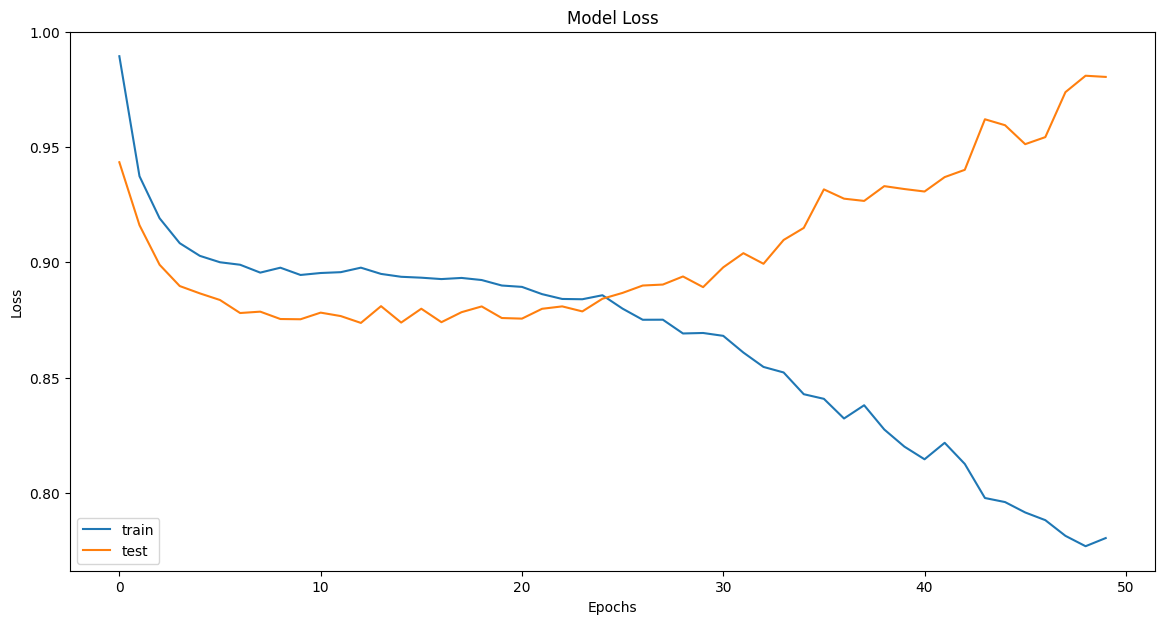

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 46.34%


For threshold set to 0.40, correctness is: 46.36%
For threshold set to 0.45, correctness is: 46.94%
For threshold set to 0.50, correctness is: 47.93%
For threshold set to 0.55, correctness is: 47.04%
For threshold set to 0.60, correctness is: 47.49%
For threshold set to 0.65, correctness is: 47.36%
For threshold set to 0.70, correctness is: 47.98%
For threshold set to 0.75, correctness is: 37.50%
For threshold set to 0.80, correctness is: 50.00%
No data reaching 0.85 threshold



(40,)



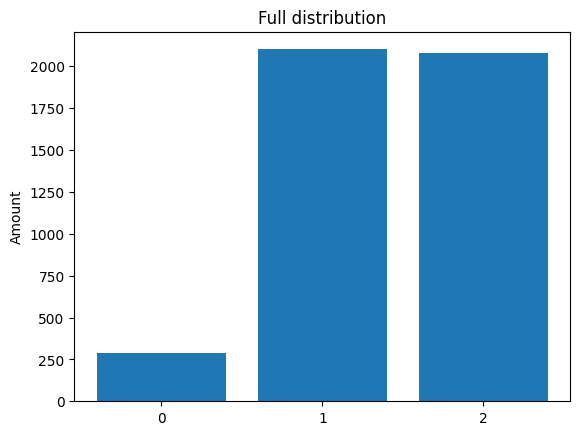

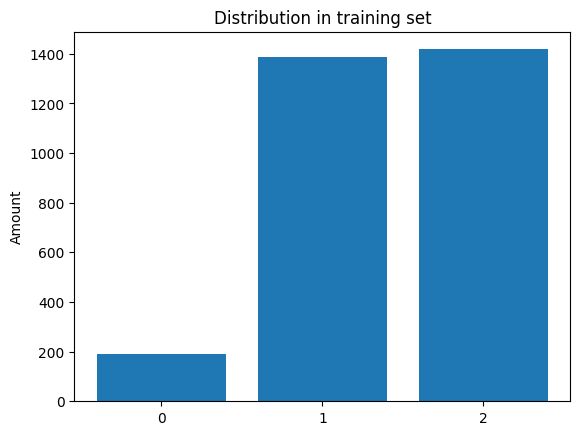

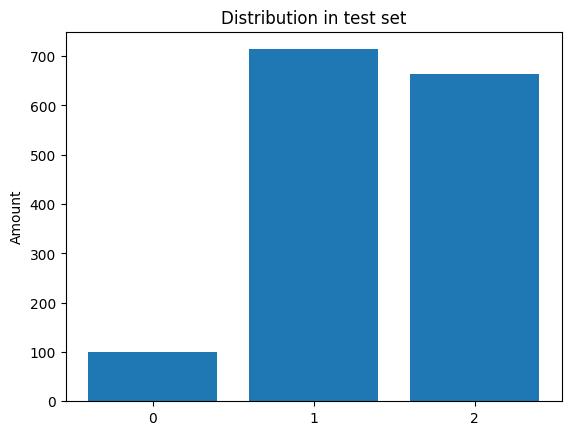

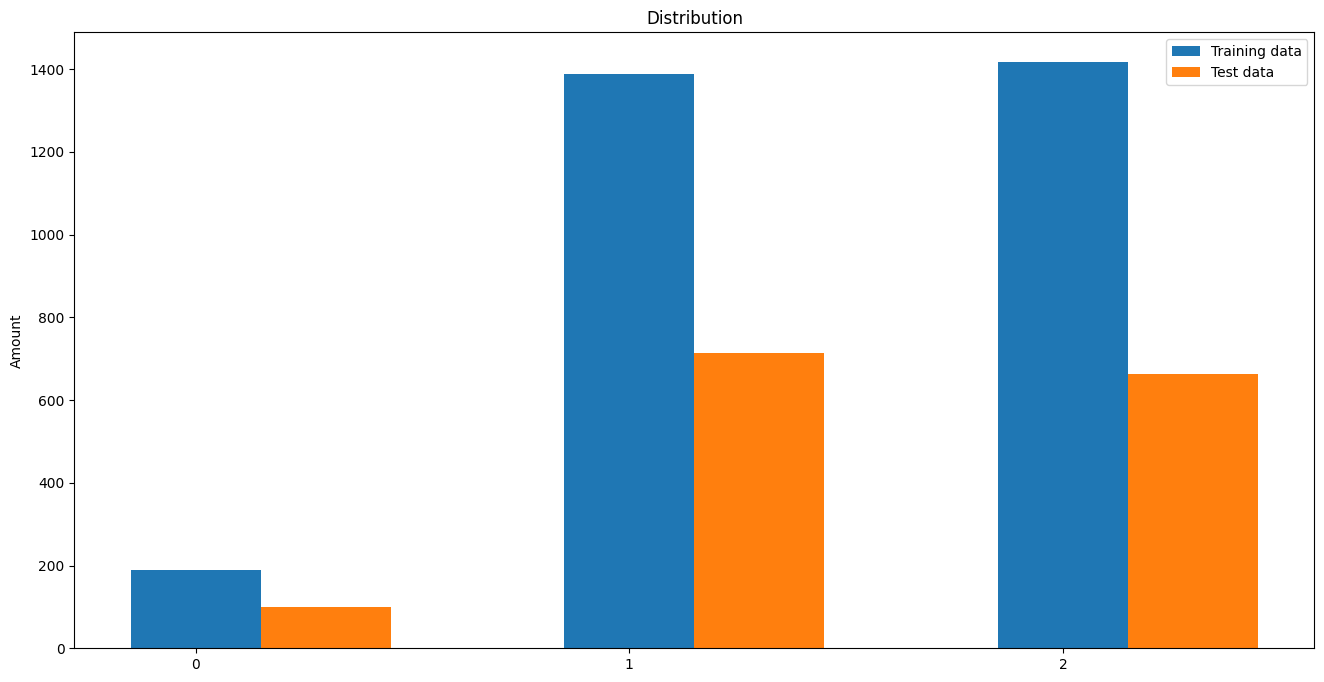


Example sequence from training set: [1 0 1 1 2 2 1 2 2 2 1 1 2 2 1 1 1 1 2 2 1 2 2 2 1 2 2 2 0 1 1 1 0 0 2 1 2
 2 1 2] and its label: 1

Example sequence from test set: [2 1 2 2 1 2 2 1 2 1 1 0 2 1 2 2 0 1 1 2 1 2 2 1 2 0 1 1 1 1 2 2 1 2 2 1 2
 2 2 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.75%
Random forest classifier accuracy: 47.49%


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.3044 - loss: 1.0350 - val_accuracy: 0.4837 - val_loss: 0.9206
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4646 - loss: 0.9180 - val_accuracy: 0.4837 - val_loss: 0.9075
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4553 - loss: 0.9027 - val_accuracy: 0.4837 - val_loss: 0.9003
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4628 - loss: 0.9048 - val_accuracy: 0.4837 - val_loss: 0.8962
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4518 - loss: 0.8930 - val_accuracy: 0.4492 - val_loss: 0.8937
Epoch 6/10
94/9

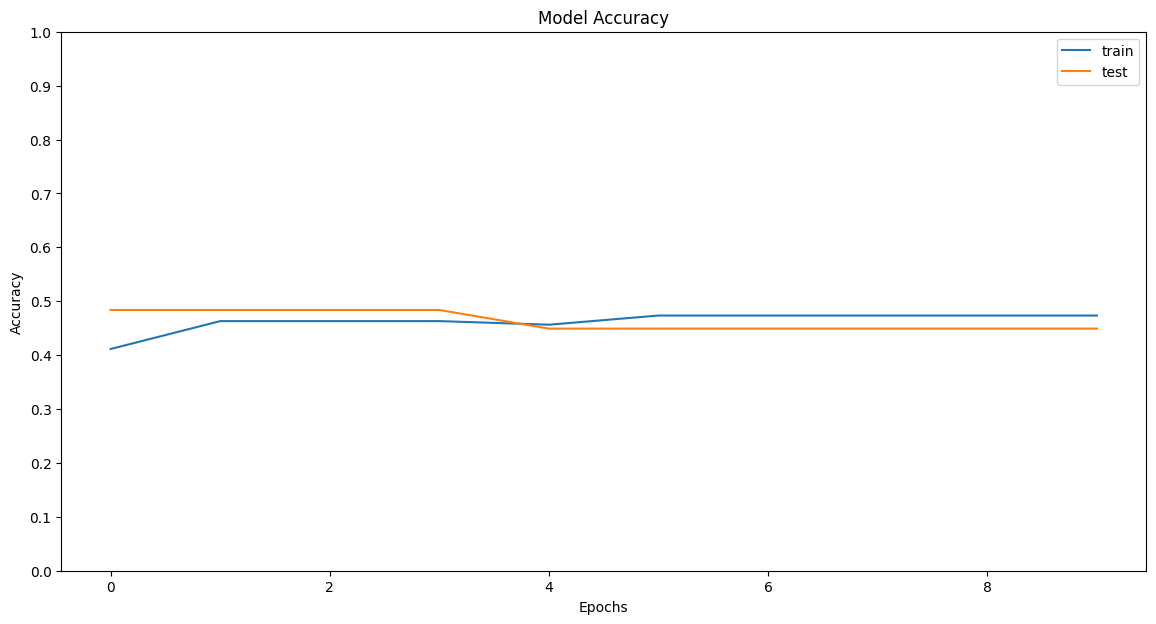

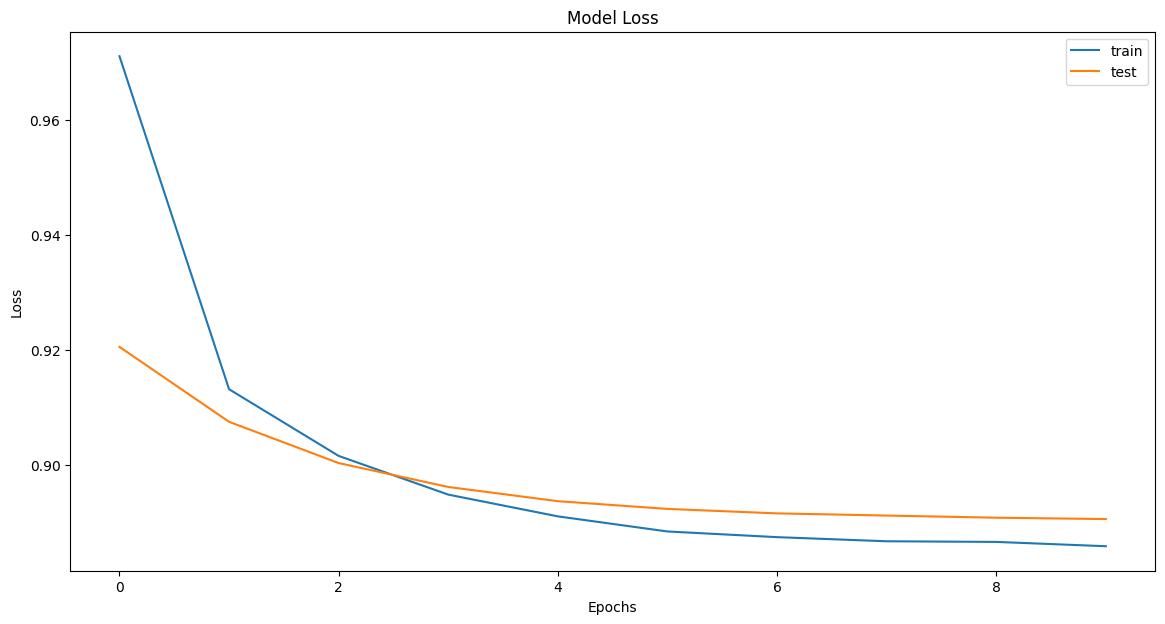

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 44.92%


For threshold set to 0.40, correctness is: 44.92%
For threshold set to 0.45, correctness is: 44.92%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4648 - loss: 1.0149 - val_accuracy: 0.4837 - val_loss: 0.9415
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4655 - loss: 0.9385 - val_accuracy: 0.4837 - val_loss: 0.9203
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4672 - loss: 0.9174 - val_accuracy: 0.4492 - val_loss: 0.9093
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4660 - loss: 0.9020 - val_accuracy: 0.4837 - val_loss: 0.9009
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

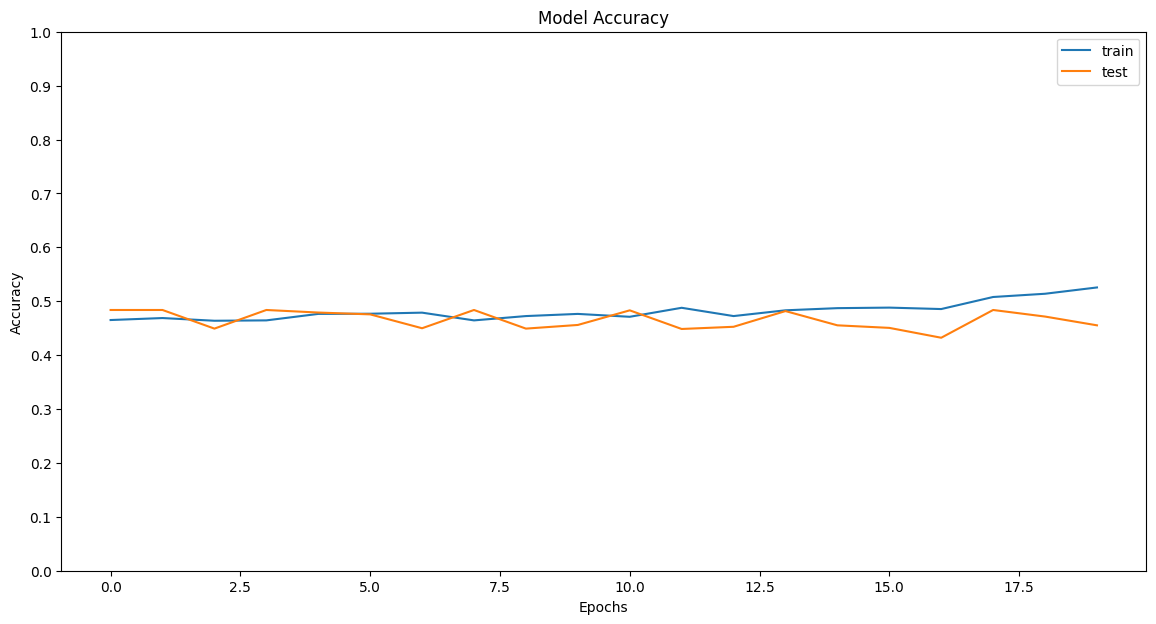

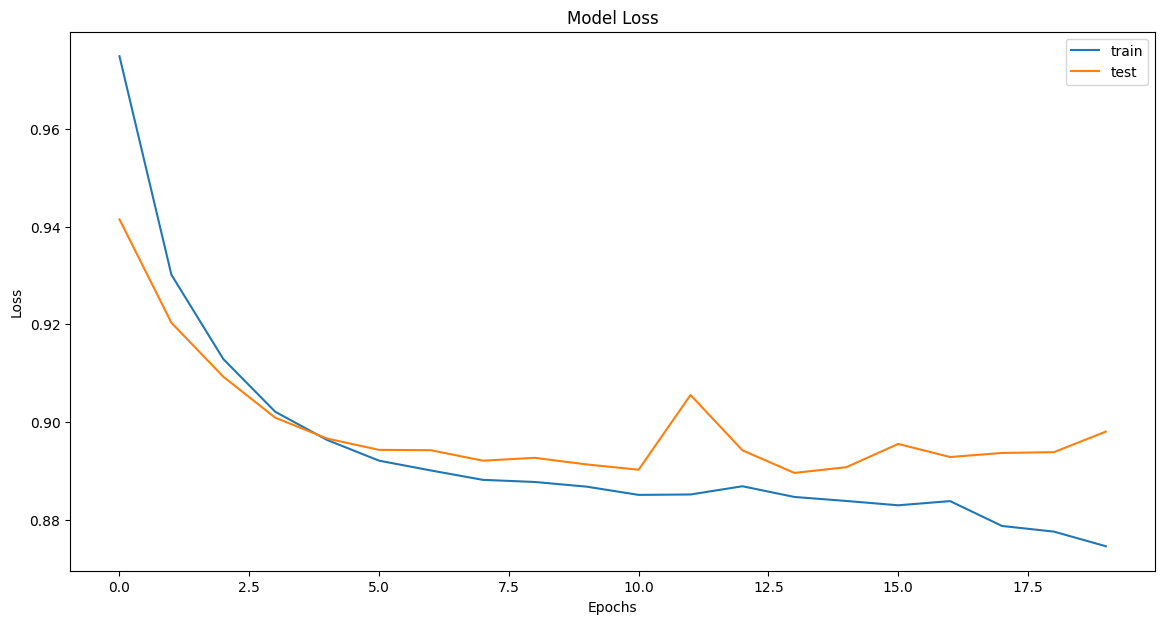

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 45.53%


For threshold set to 0.40, correctness is: 45.53%
For threshold set to 0.45, correctness is: 45.53%
For threshold set to 0.50, correctness is: 47.13%
For threshold set to 0.55, correctness is: 0.00%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4746 - loss: 1.0025 - val_accuracy: 0.4837 - val_loss: 0.9522
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4804 - loss: 0.9308 - val_accuracy: 0.4492 - val_loss: 0.9162
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 0.9119 - val_accuracy: 0.4492 - val_loss: 0.9068
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4776 - loss: 0.8915 - val_accuracy: 0.4512 - val_loss: 0.8971
Epoch 5/50
94/94 ━━━━━━━━

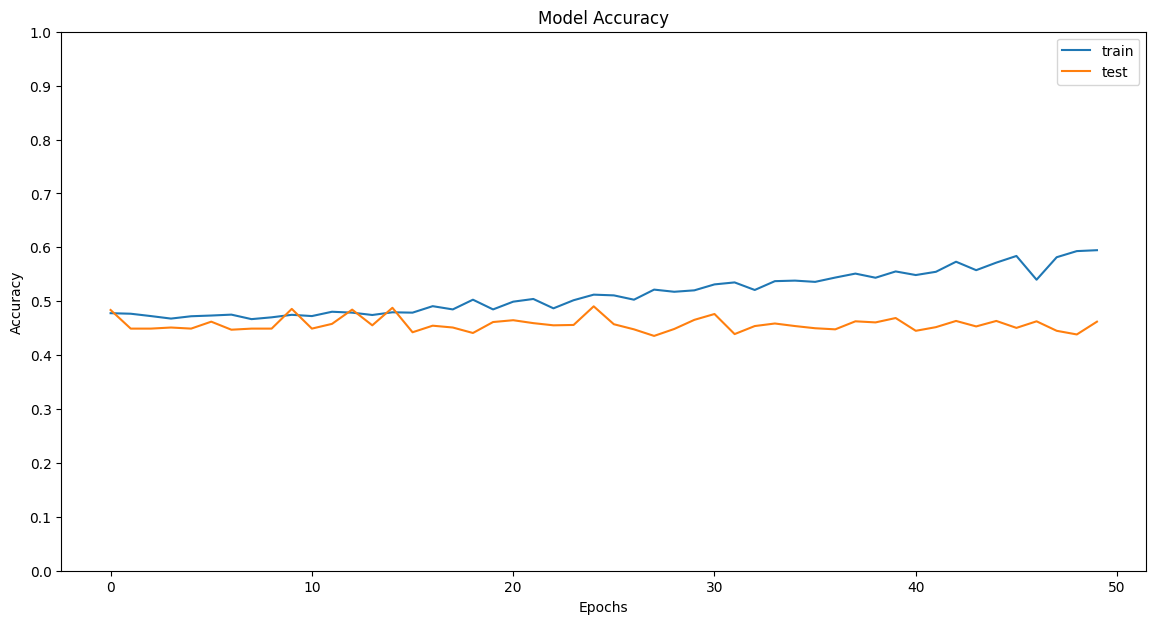

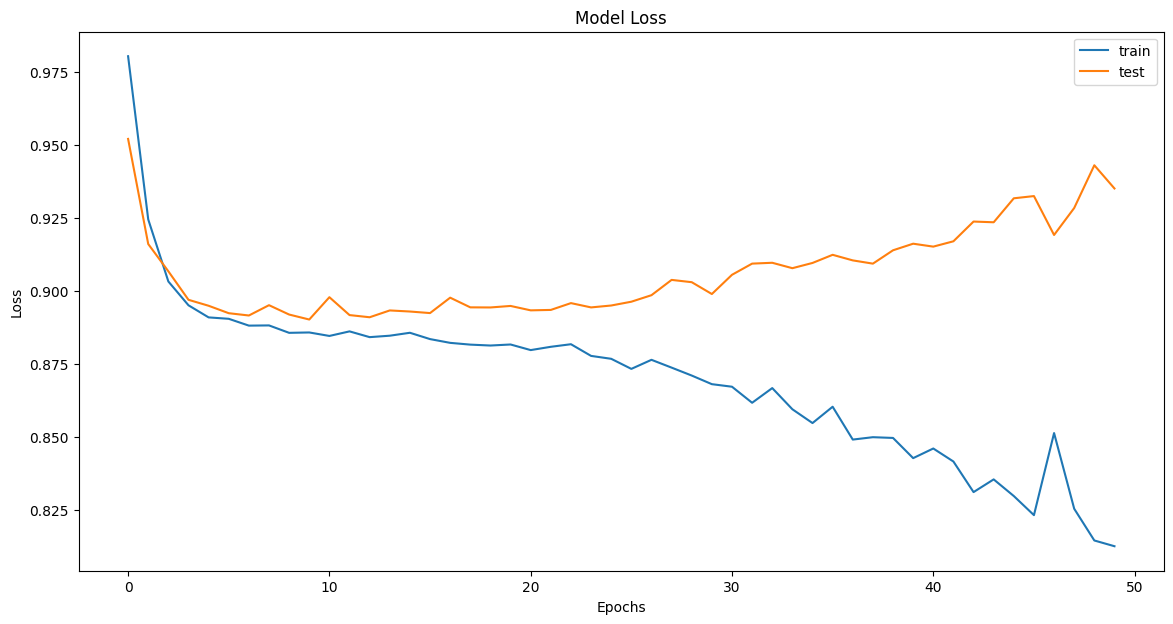

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.21%


For threshold set to 0.40, correctness is: 46.38%
For threshold set to 0.45, correctness is: 46.70%
For threshold set to 0.50, correctness is: 46.38%
For threshold set to 0.55, correctness is: 46.30%
For threshold set to 0.60, correctness is: 43.85%
For threshold set to 0.65, correctness is: 43.98%
For threshold set to 0.70, correctness is: 43.56%
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 20, Epoch: 10, Accuracy: 47.60%
Chunk size: 20, Epoch: 20, Accuracy: 47.60%
Chunk size: 5, Epoch: 10, Accuracy: 46.98%

Data from file: csgofastcom.csv


Example sequence: ['black', 'black', 'red', 'red', 'red', 'black', 'red', 'black', 'black', 'green', 'black', 'black']

red: Counter({1: 407, 2: 178, 3: 78, 4: 42, 5: 23, 6: 12, 7: 2, 9: 1, 8: 1})
black: Counter({1: 416, 2: 181, 3: 79, 4: 39, 6: 12, 5: 10, 7: 3, 8: 2, 9: 2})
green: Counter({1:

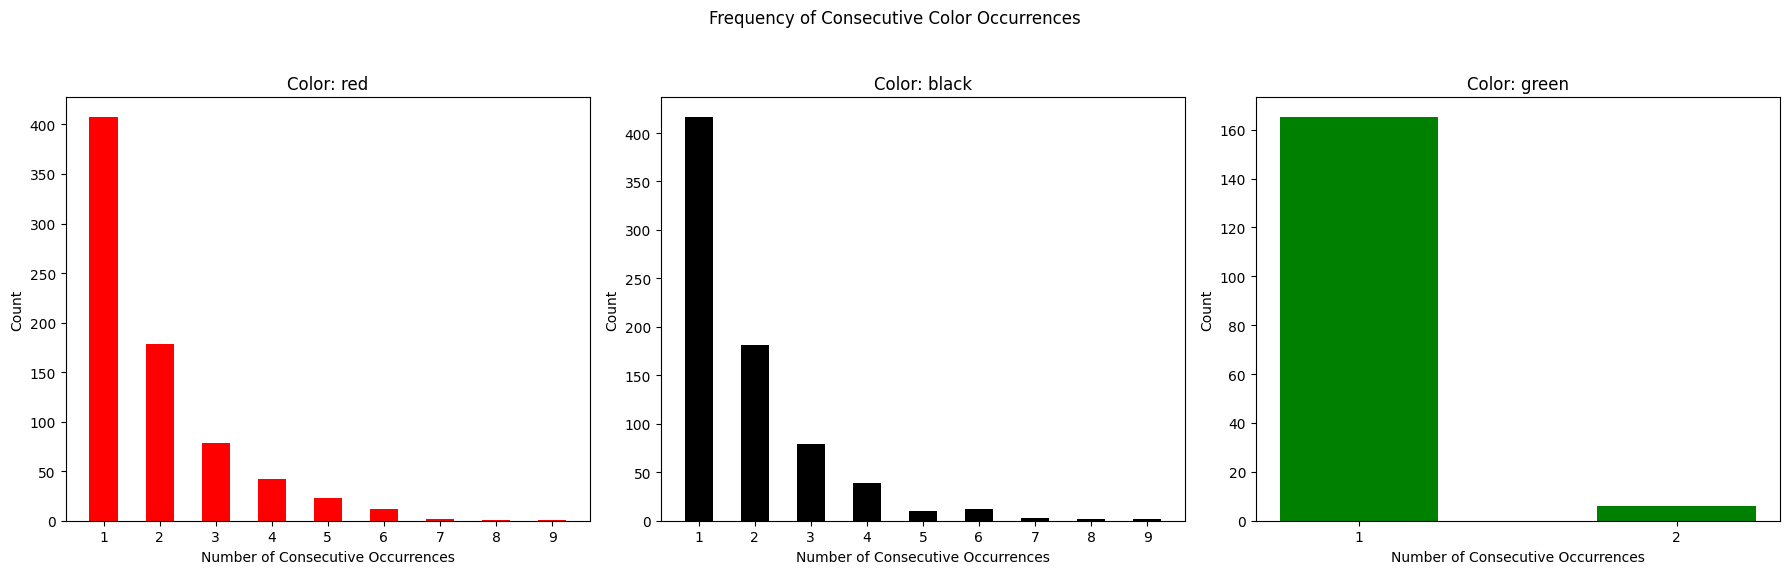

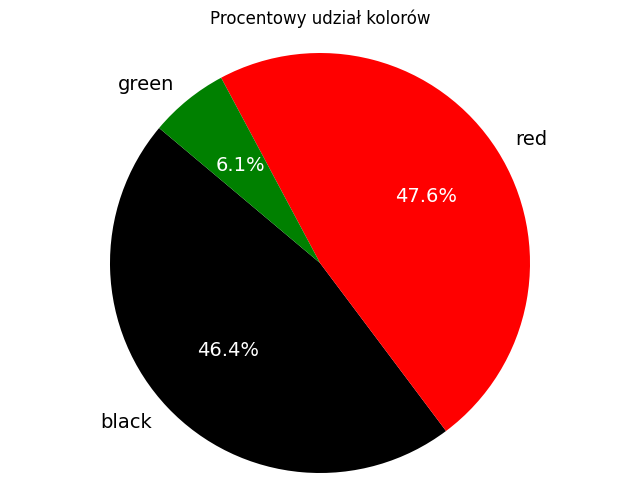


(2,)



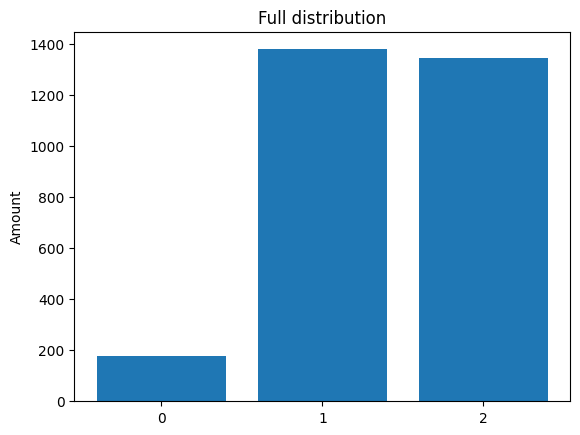

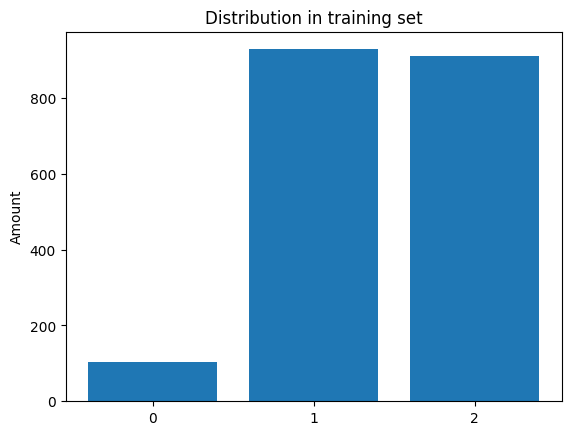

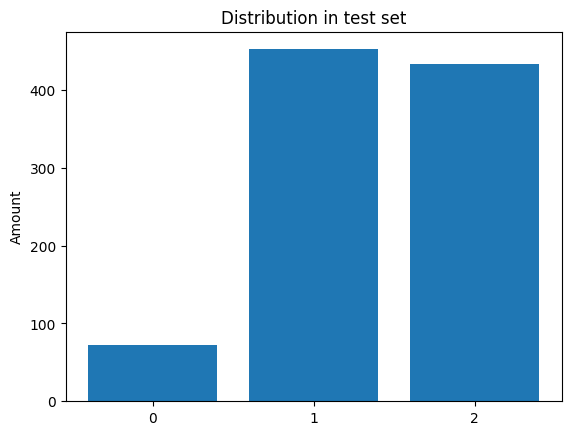

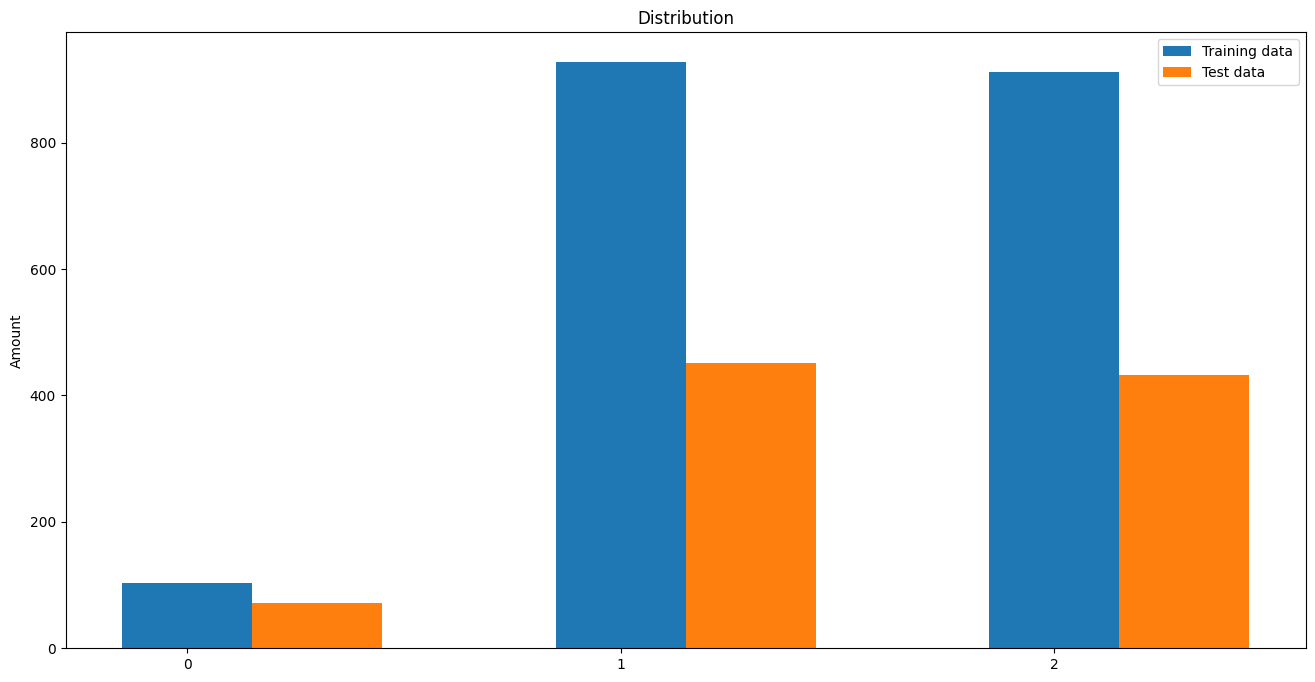


Example sequence from training set: [1 2] and its label: 2

Example sequence from test set: [1 2] and its label: 2


Gaussian Naive Bayes accuracy: 45.98%
Random forest classifier accuracy: 45.66%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.4699 - loss: 1.0019 - val_accuracy: 0.4525 - val_loss: 0.9587
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4656 - loss: 0.9381 - val_accuracy: 0.4525 - val_loss: 0.9363
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.9016 - val_accuracy: 0.4514 - val_loss: 0.9232
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4867 - loss: 0.9043 - val_accuracy: 0.4765 - val_loss: 0.9162
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4879 - loss: 0.8869 - val_accuracy: 0.4765 - val_loss: 0.9121
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4957 - loss: 0.8697 - val_accuracy: 0.4723 - val_loss: 0.9097
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

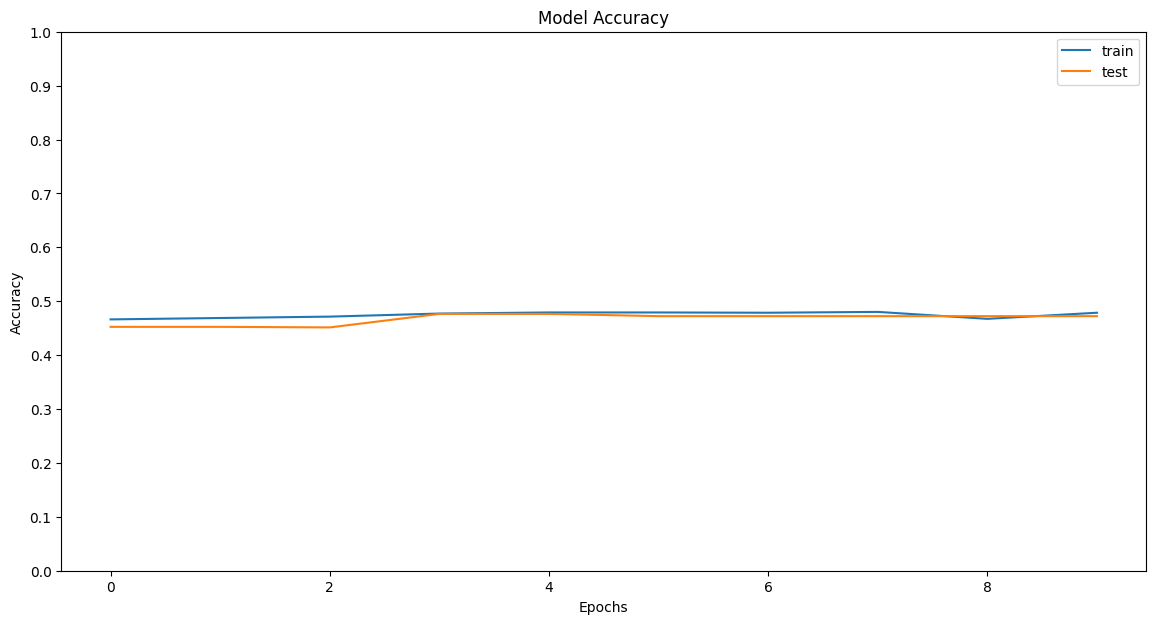

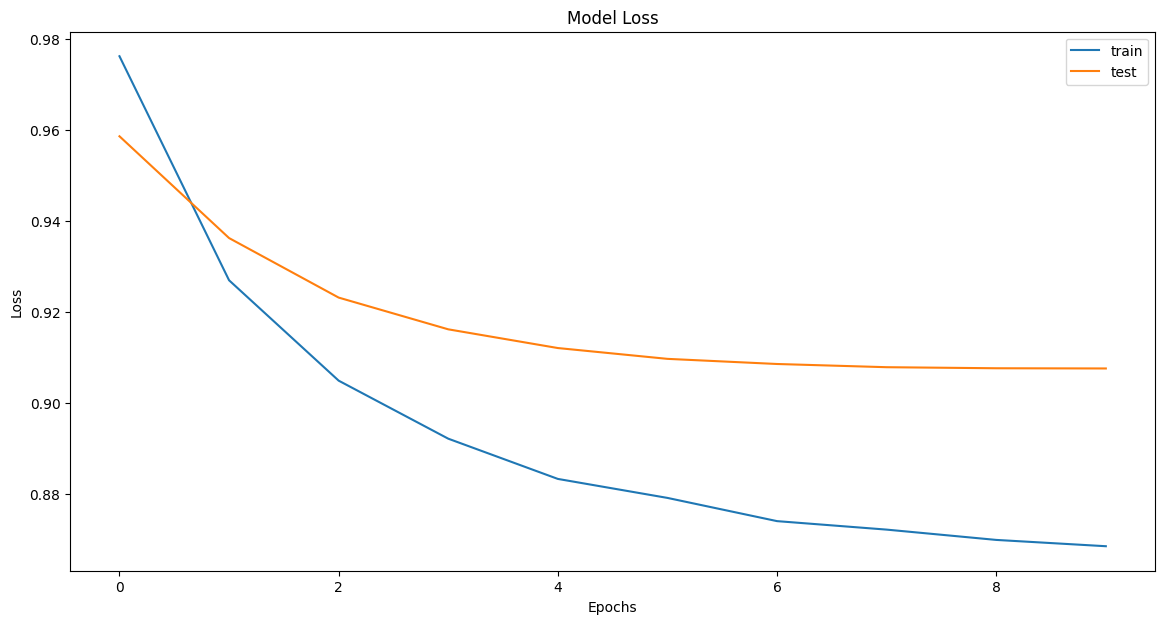

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 47.23%


For threshold set to 0.40, correctness is: 47.23%
For threshold set to 0.45, correctness is: 47.23%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4574 - loss: 0.9930 - val_accuracy: 0.4525 - val_loss: 0.9485
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4661 - loss: 0.9248 - val_accuracy: 0.4525 - val_loss: 0.9323
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4463 - loss: 0.9131 - val_accuracy: 0.4525 - val_loss: 0.9226
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 0.8920 - val_accuracy: 0.4525 - val_loss: 0.9166
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

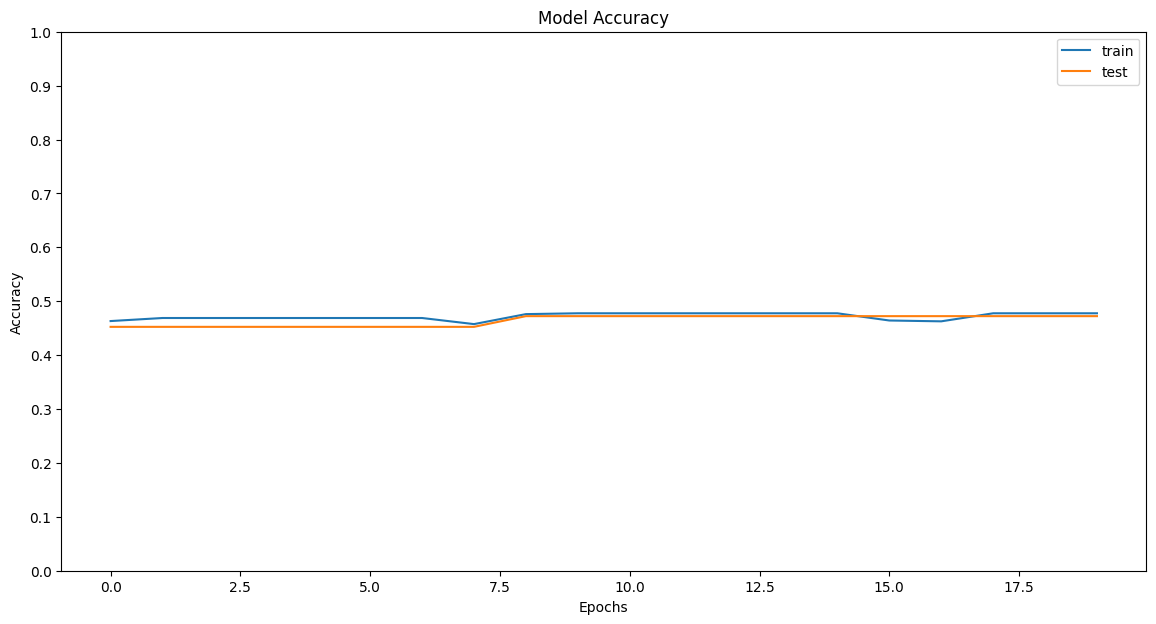

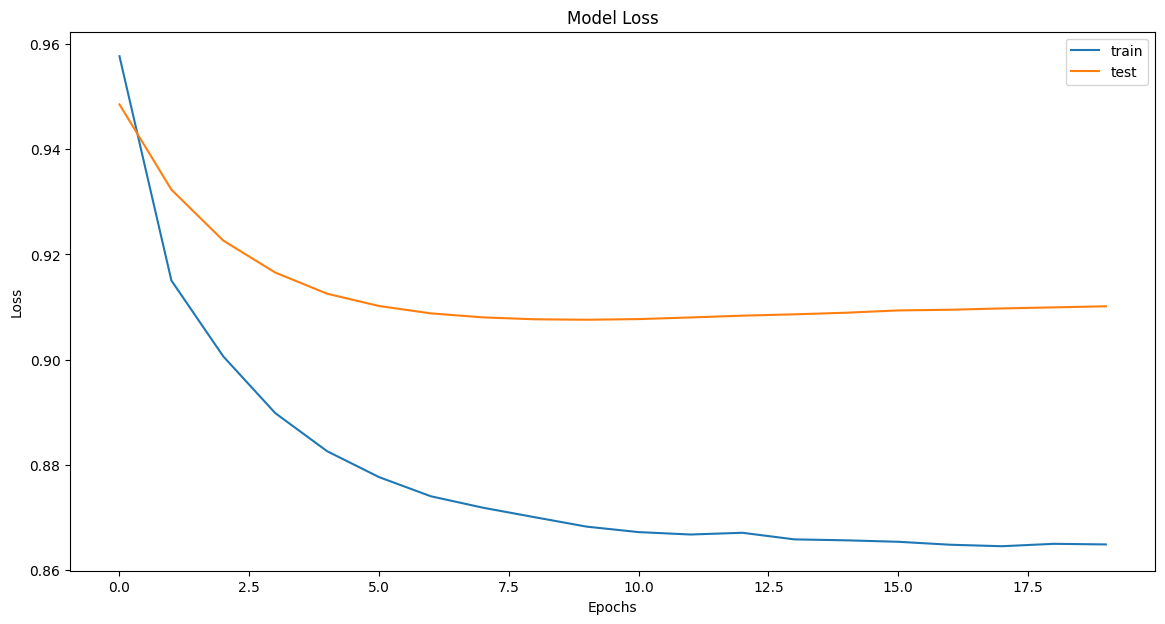

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.23%


For threshold set to 0.40, correctness is: 47.23%
For threshold set to 0.45, correctness is: 47.23%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4738 - loss: 1.0502 - val_accuracy: 0.4525 - val_loss: 0.9540
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4845 - loss: 0.9215 - val_accuracy: 0.4525 - val_loss: 0.9379
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4645 - loss: 0.9127 - val_accuracy: 0.4525 - val_loss: 0.9273
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4734 - loss: 0.8967 - val_accuracy: 0.4525 - val_loss: 0.9201
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

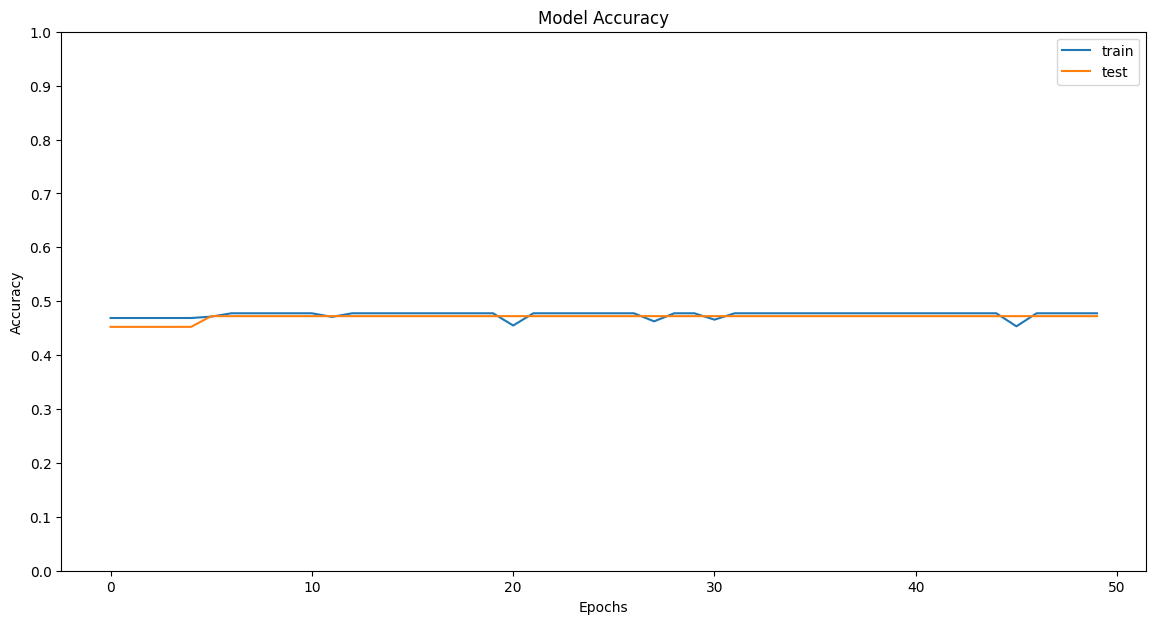

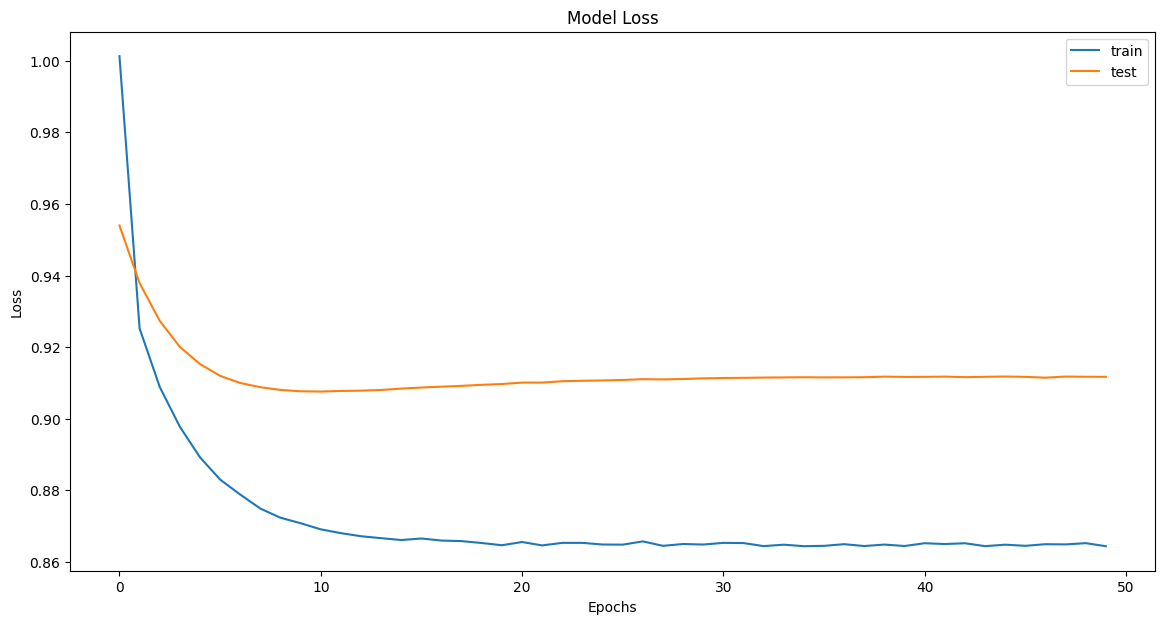

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.23%


For threshold set to 0.40, correctness is: 47.23%
For threshold set to 0.45, correctness is: 47.23%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



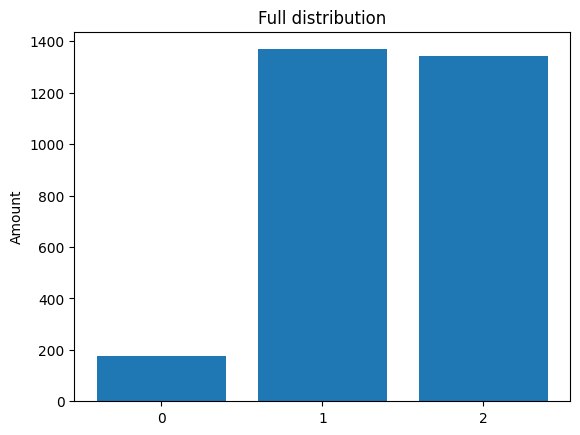

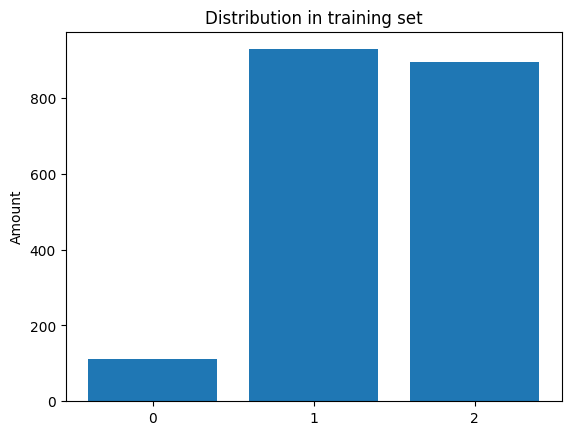

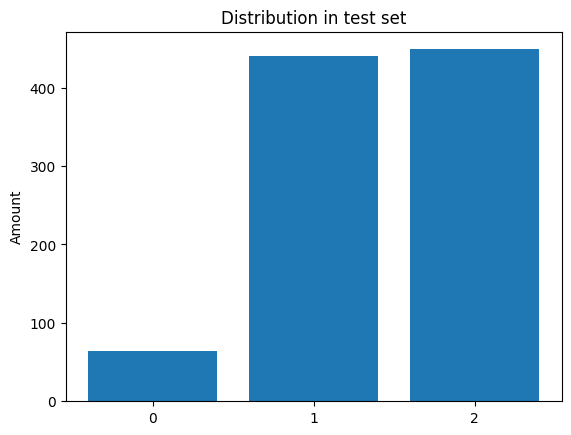

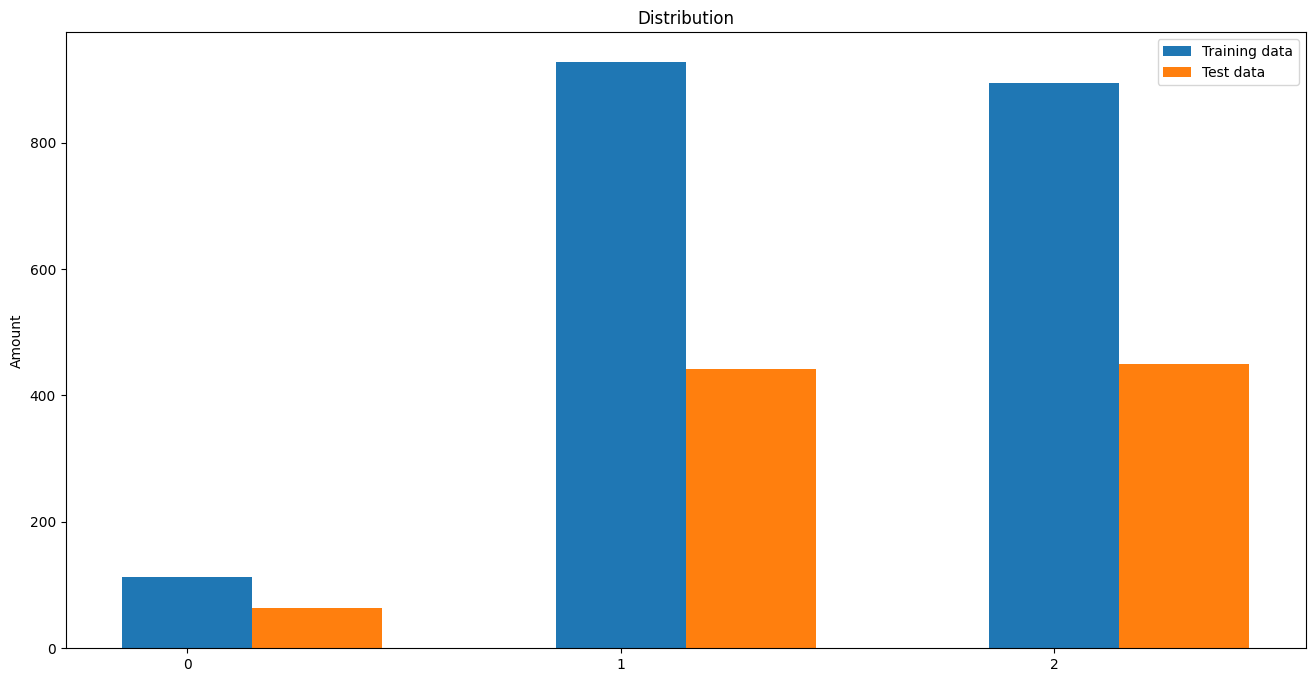


Example sequence from training set: [1 1 2 2 1] and its label: 1

Example sequence from test set: [2 1 2 2 2] and its label: 2


Gaussian Naive Bayes accuracy: 44.13%
Random forest classifier accuracy: 46.75%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.3424 - loss: 1.0871 - val_accuracy: 0.4623 - val_loss: 1.0093
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 0.9759 - val_accuracy: 0.4623 - val_loss: 0.9650
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4970 - loss: 0.9478 - val_accuracy: 0.4591 - val_loss: 0.9436
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4513 - loss: 0.9357 - val_accuracy: 0.4706 - val_loss: 0.9294
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4845 - loss: 0.9319 - val_accuracy: 0.4623 - val_loss: 0.9211
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4798 - loss: 0.9068 - val_accuracy: 0.4654 - val_loss: 0.9116
Epoch 7/10
61/61 ━━━━━━━━━━━━━━

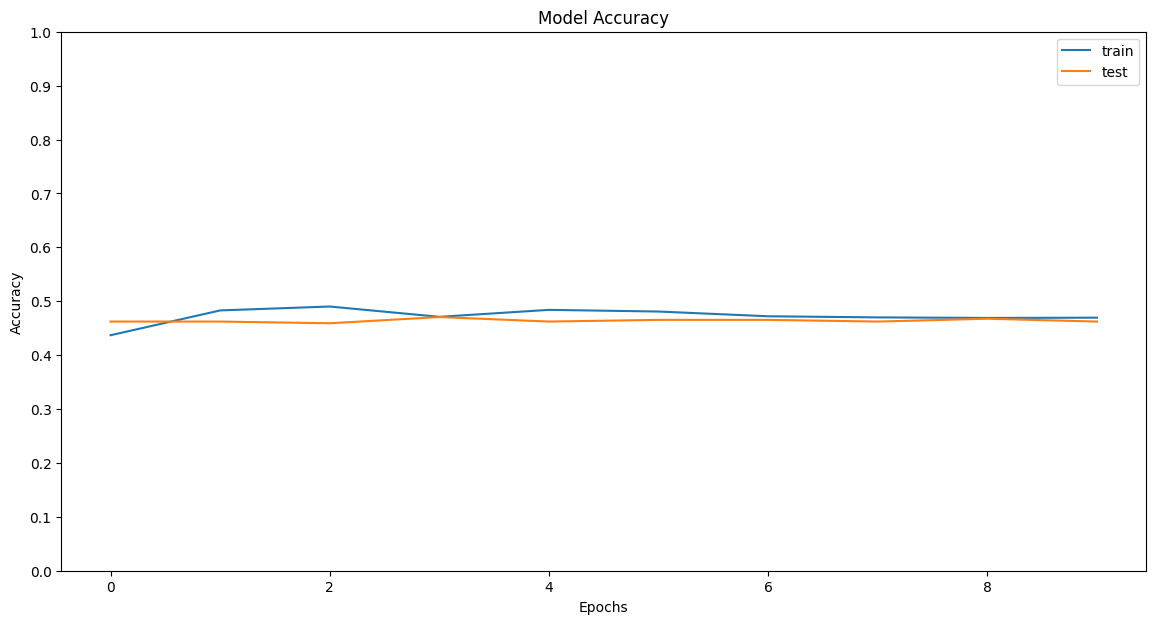

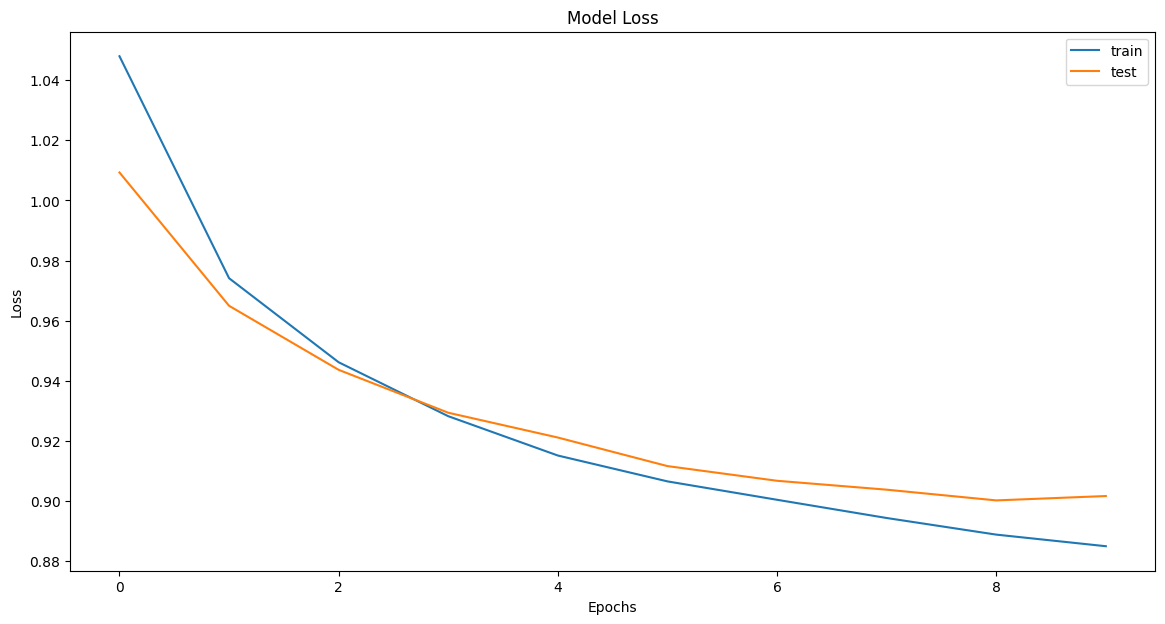

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 46.23%


For threshold set to 0.40, correctness is: 46.23%
For threshold set to 0.45, correctness is: 46.23%
For threshold set to 0.50, correctness is: 40.00%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4698 - loss: 1.0638 - val_accuracy: 0.4623 - val_loss: 1.0148
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4619 - loss: 0.9883 - val_accuracy: 0.4654 - val_loss: 0.9663
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4530 - loss: 0.9537 - val_accuracy: 0.4706 - val_loss: 0.9455
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4837 - loss: 0.9297 - val_accuracy: 0.4706 - val_loss: 0.9310
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3

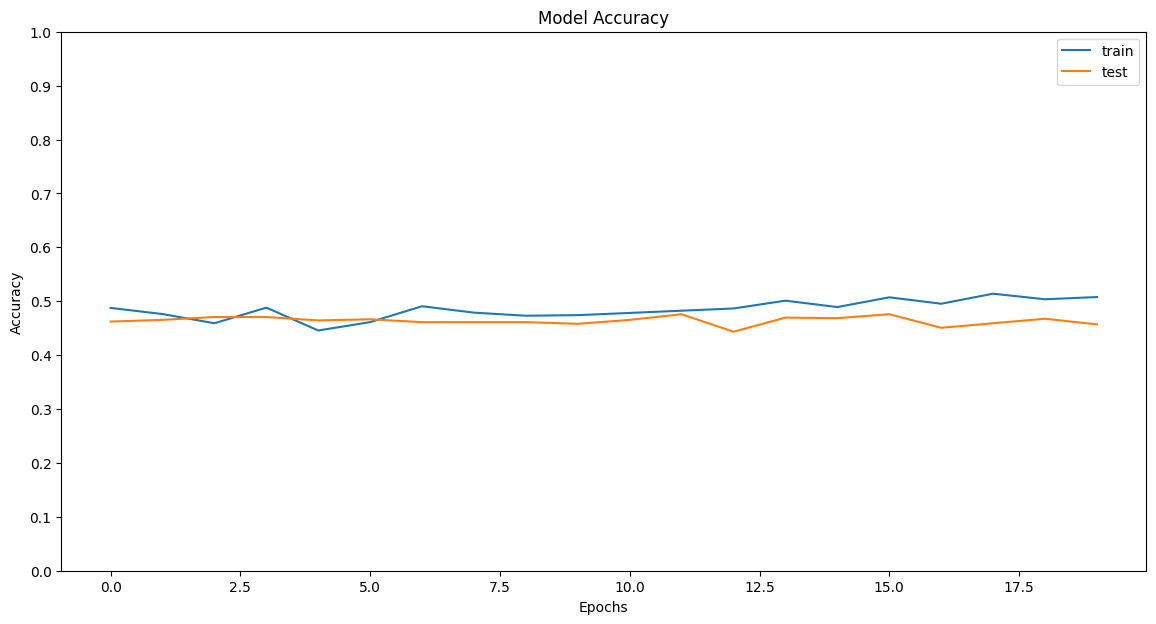

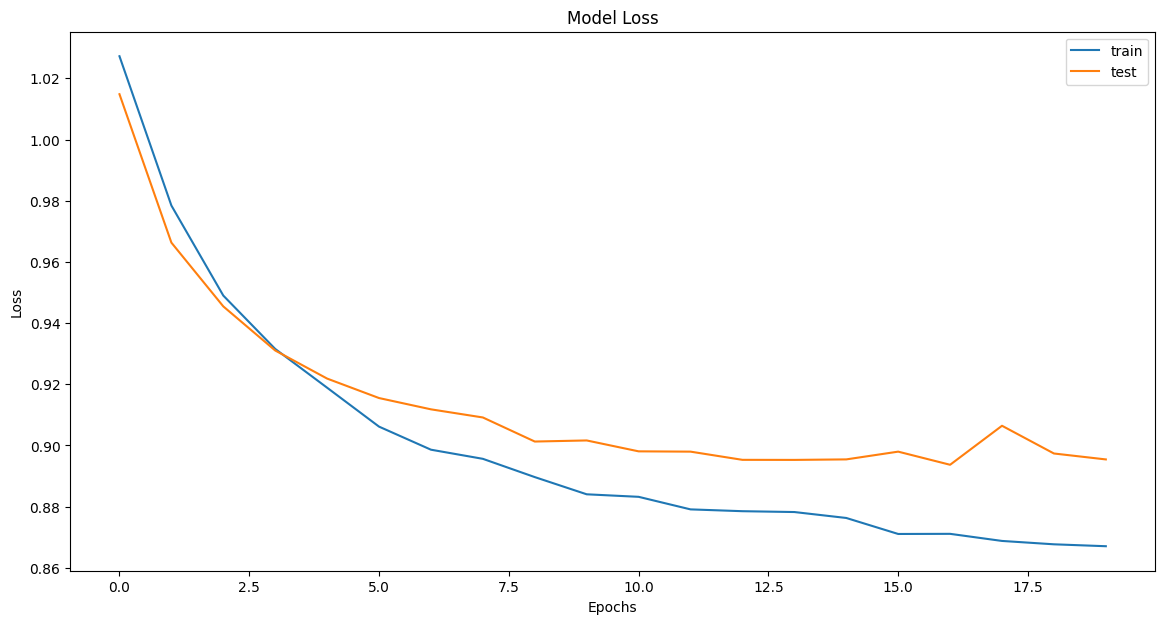

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 45.70%


For threshold set to 0.40, correctness is: 45.70%
For threshold set to 0.45, correctness is: 45.70%
For threshold set to 0.50, correctness is: 50.62%
For threshold set to 0.55, correctness is: 52.46%
For threshold set to 0.60, correctness is: 41.67%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4292 - loss: 1.0287 - val_accuracy: 0.4623 - val_loss: 0.9387
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4614 - loss: 0.9346 - val_accuracy: 0.4623 - val_loss: 0.9234
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4687 - loss: 0.9090 - val_accuracy: 0.4623 - val_loss: 0.9134
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4818 - loss: 0.8977 - val_accuracy: 0.4623 - val_loss: 0.9069
Epoch 

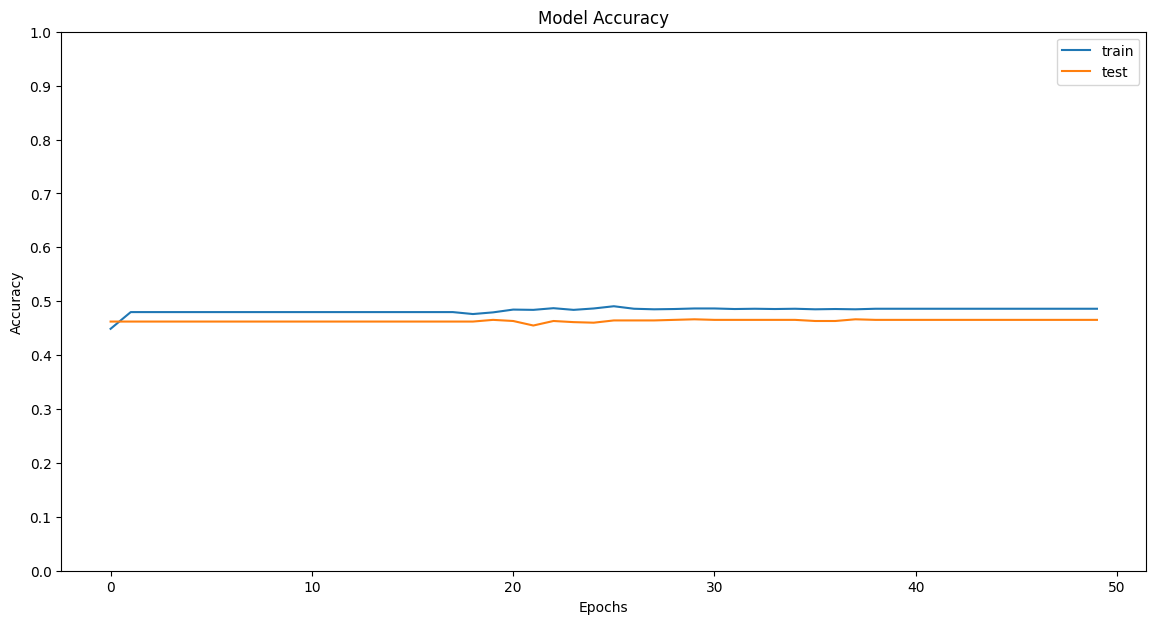

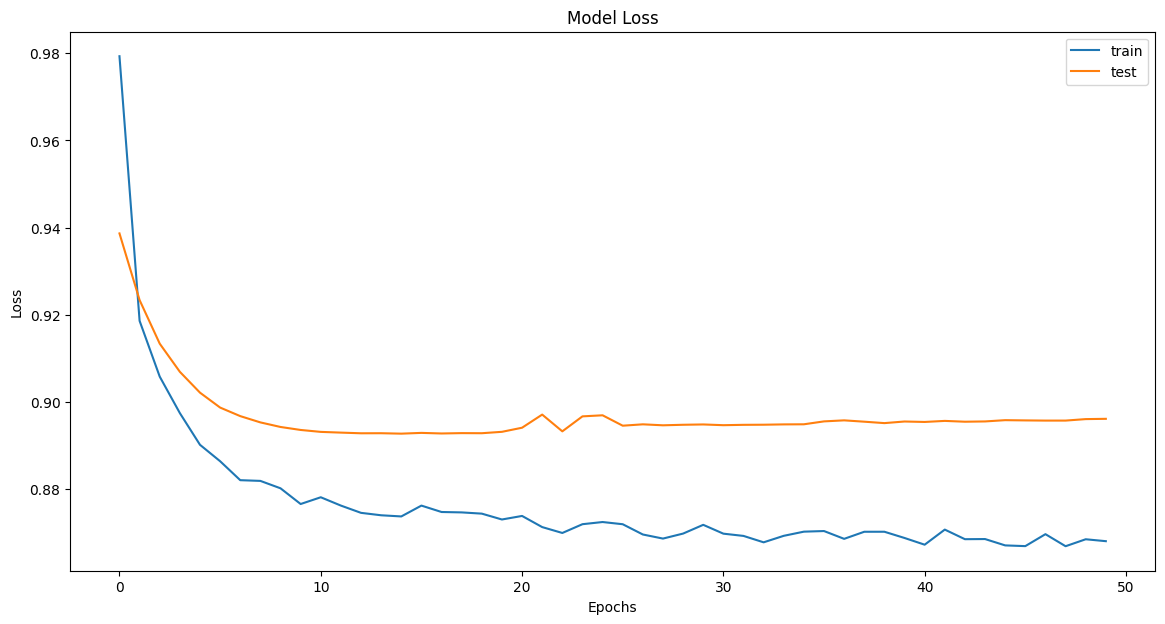

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Modal accuracy on test set: 46.54%


For threshold set to 0.40, correctness is: 46.54%
For threshold set to 0.45, correctness is: 46.54%
For threshold set to 0.50, correctness is: 66.67%
For threshold set to 0.55, correctness is: 57.14%
For threshold set to 0.60, correctness is: 50.00%
For threshold set to 0.65, correctness is: 100.00%
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



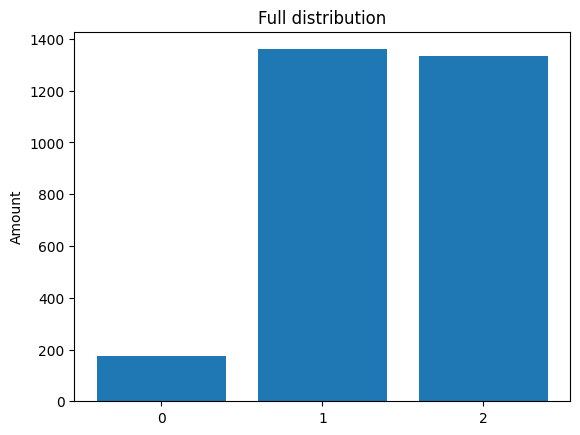

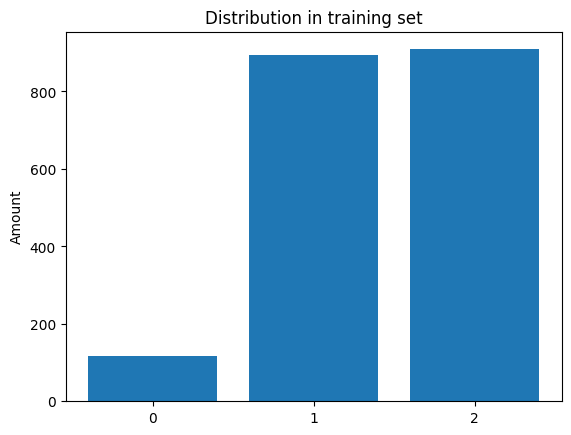

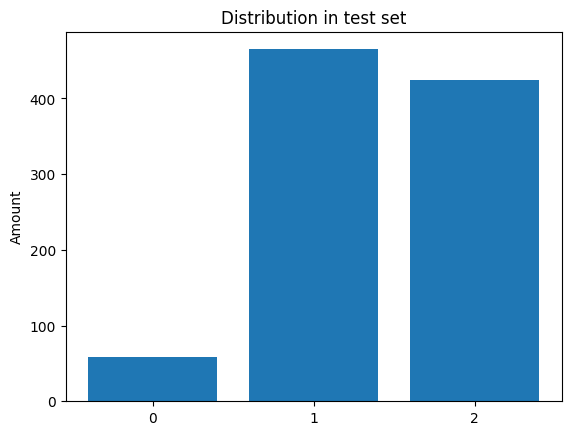

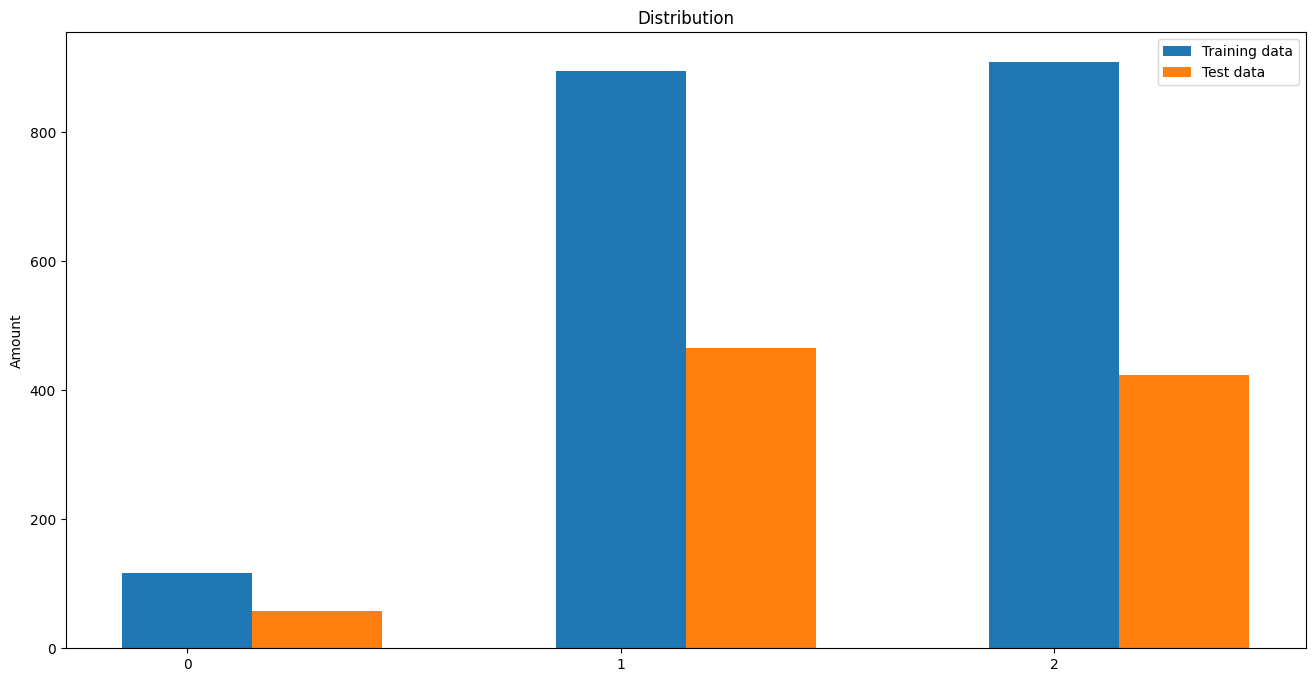


Example sequence from training set: [1 2 1 2 1 1 1 1 2 2] and its label: 1

Example sequence from test set: [2 1 1 1 1 2 1 2 2 1] and its label: 1


Gaussian Naive Bayes accuracy: 43.29%
Random forest classifier accuracy: 45.30%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4779 - loss: 0.9786 - val_accuracy: 0.4477 - val_loss: 0.9328
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4695 - loss: 0.9254 - val_accuracy: 0.4477 - val_loss: 0.9154
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4787 - loss: 0.8982 - val_accuracy: 0.4477 - val_loss: 0.9029
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4798 - loss: 0.8964 - val_accuracy: 0.4477 - val_loss: 0.8983
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4583 - loss: 0.8928 - val_accuracy: 0.4477 - val_loss: 0.8929
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4763 - loss: 0.8859 - val_accuracy: 0.4477 - val_loss: 0.8898
Epoch 7/10


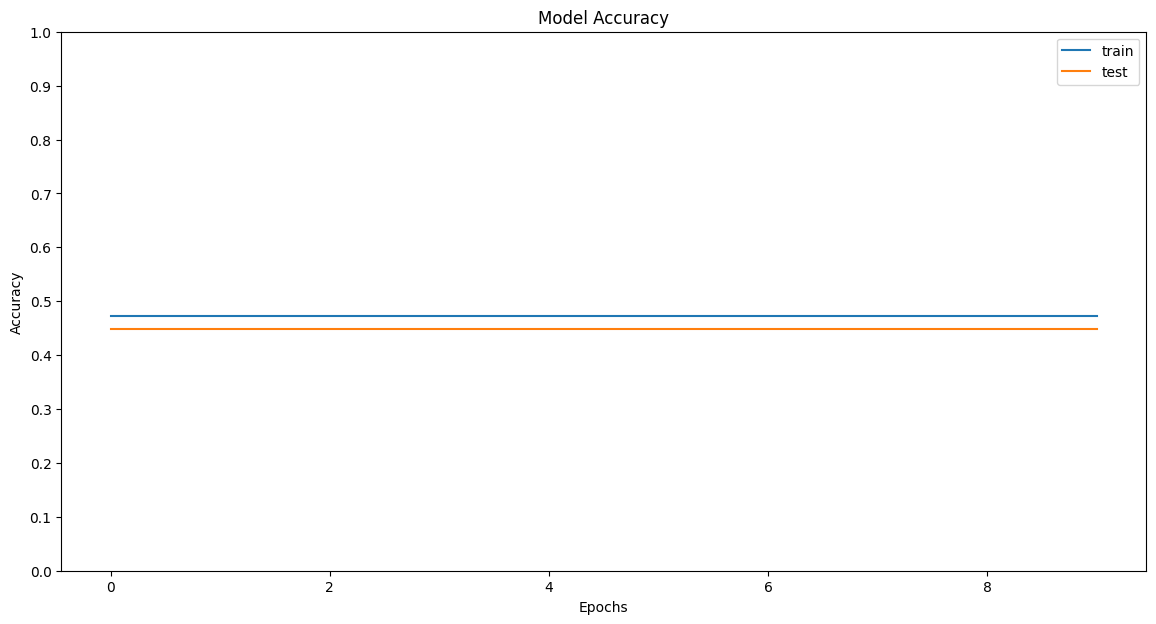

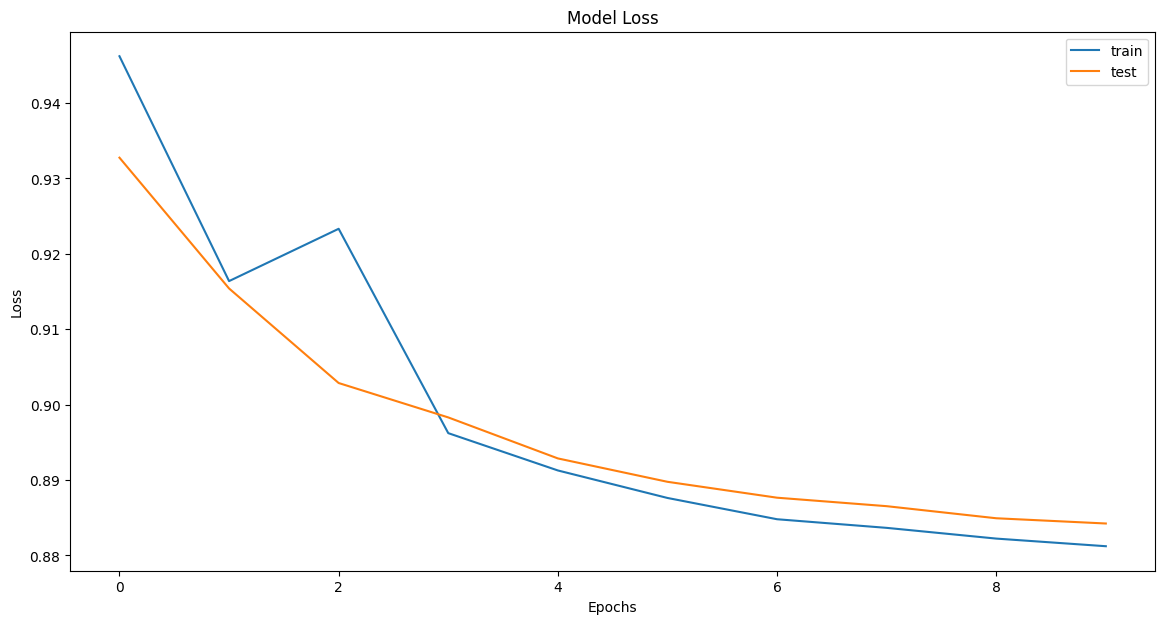

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 44.77%


For threshold set to 0.40, correctness is: 44.77%
For threshold set to 0.45, correctness is: 44.77%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4479 - loss: 0.9695 - val_accuracy: 0.4477 - val_loss: 0.9290
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 0.9201 - val_accuracy: 0.4477 - val_loss: 0.9144
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 0.8990 - val_accuracy: 0.4477 - val_loss: 0.9052
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4609 - loss: 0.8995 - val_accuracy: 0.4477 - val_loss: 0.8978
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

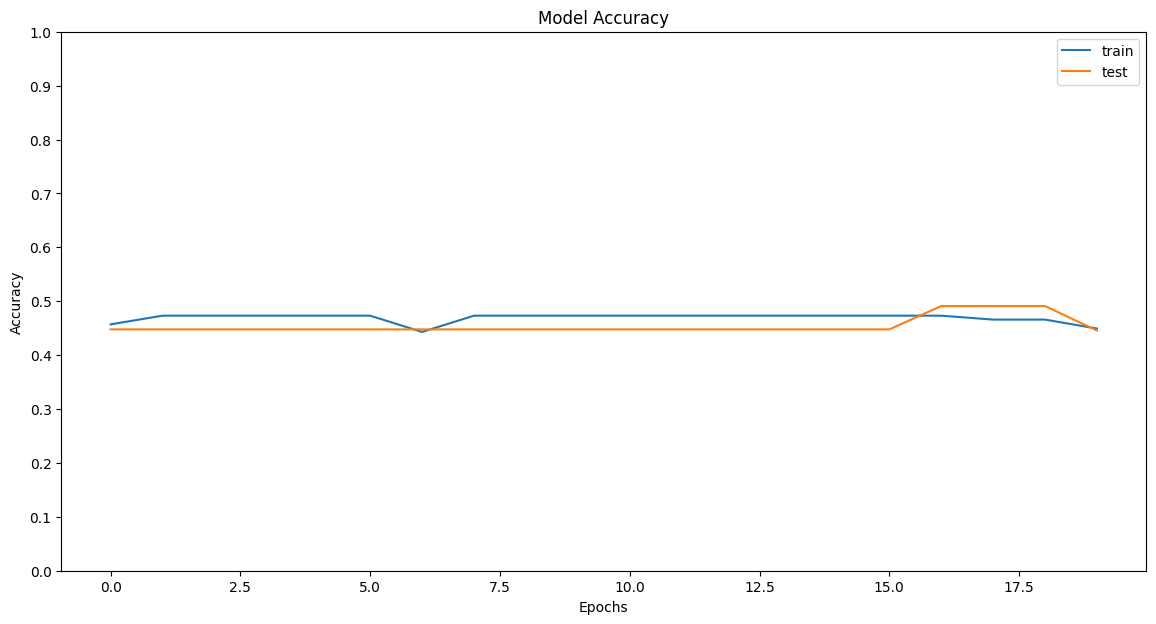

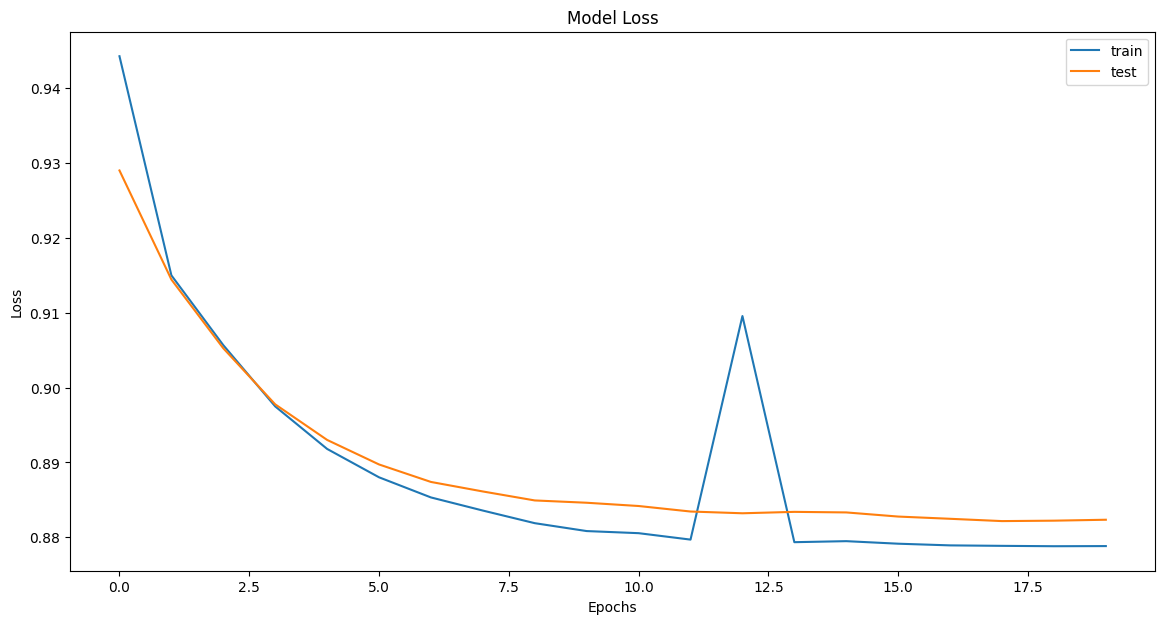

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.56%


For threshold set to 0.40, correctness is: 44.56%
For threshold set to 0.45, correctness is: 44.56%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4570 - loss: 1.0320 - val_accuracy: 0.4910 - val_loss: 0.9812
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4494 - loss: 0.9682 - val_accuracy: 0.4910 - val_loss: 0.9268
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4548 - loss: 0.9332 - val_accuracy: 0.4910 - val_loss: 0.9102
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4713 - loss: 0.9020 - val_accuracy: 0.4910 - val_loss: 0.9012
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

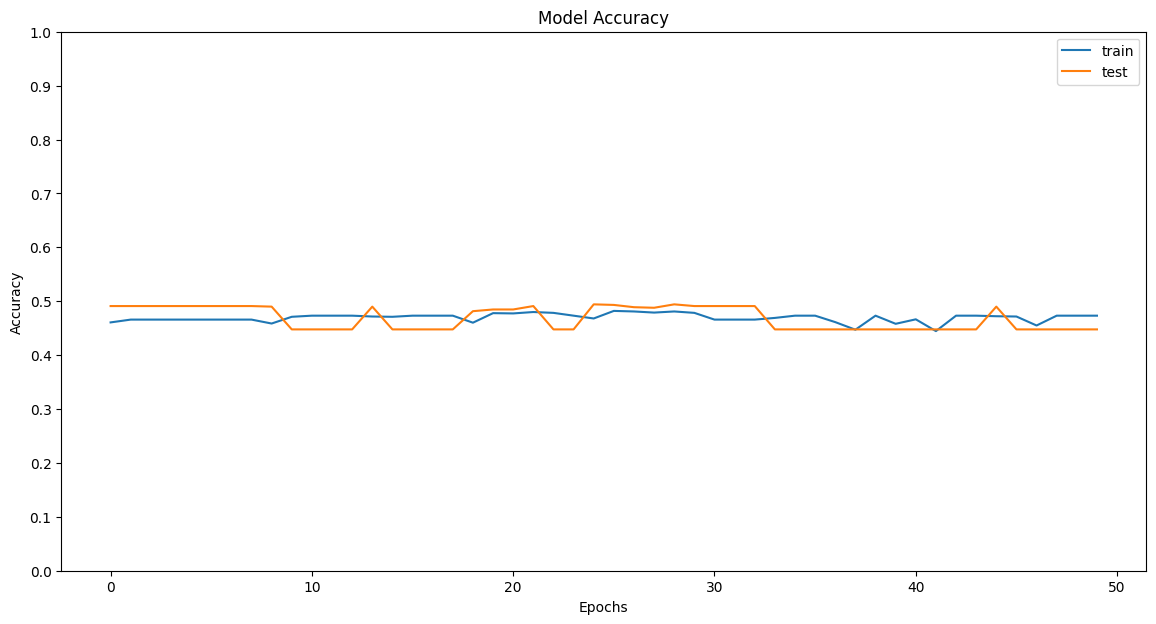

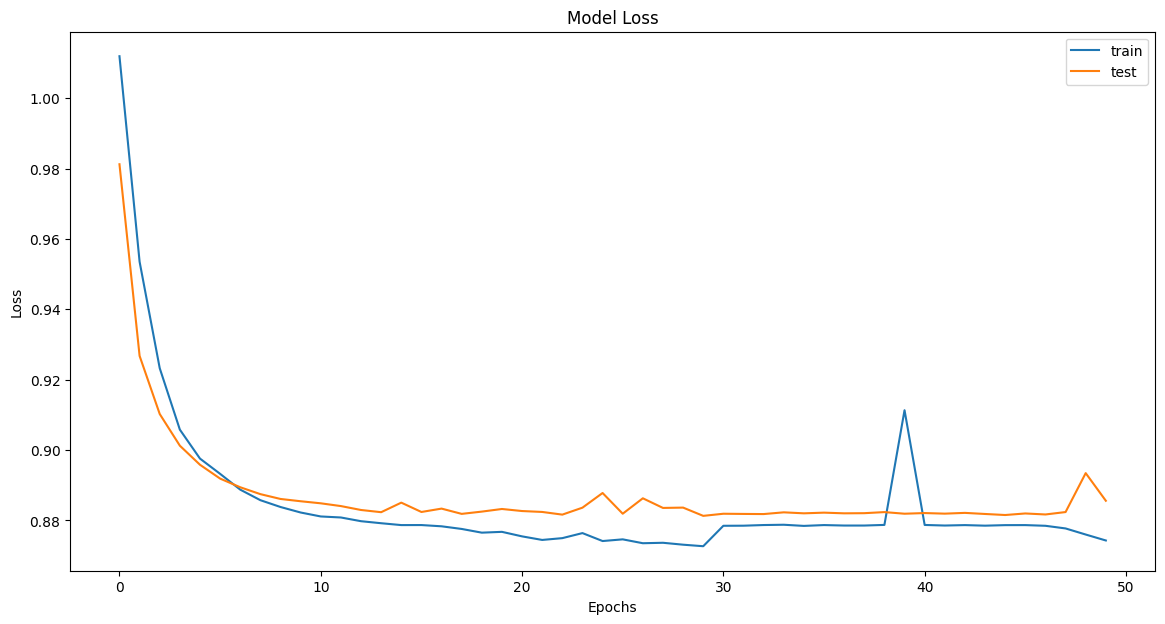

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.77%


For threshold set to 0.40, correctness is: 44.77%
For threshold set to 0.45, correctness is: 44.77%
For threshold set to 0.50, correctness is: 48.39%
For threshold set to 0.55, correctness is: 41.67%
For threshold set to 0.60, correctness is: 42.86%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



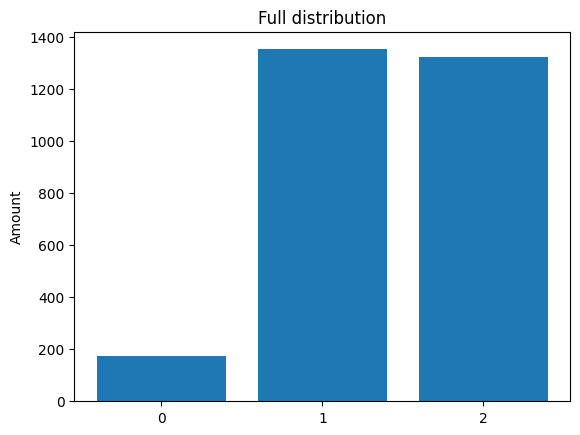

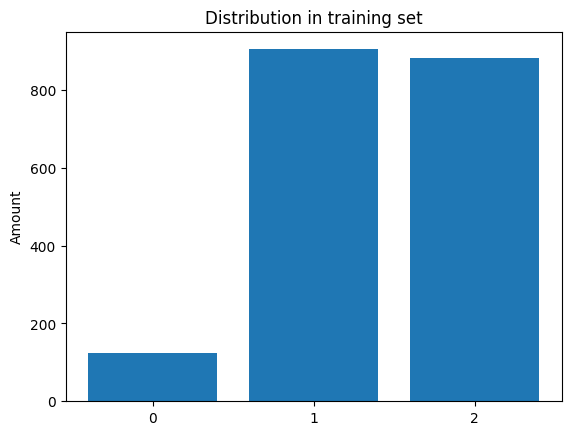

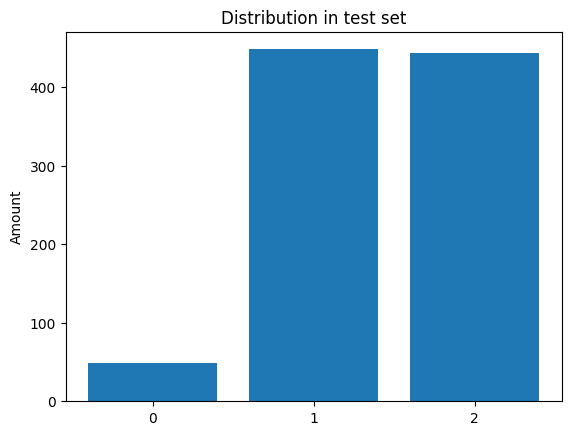

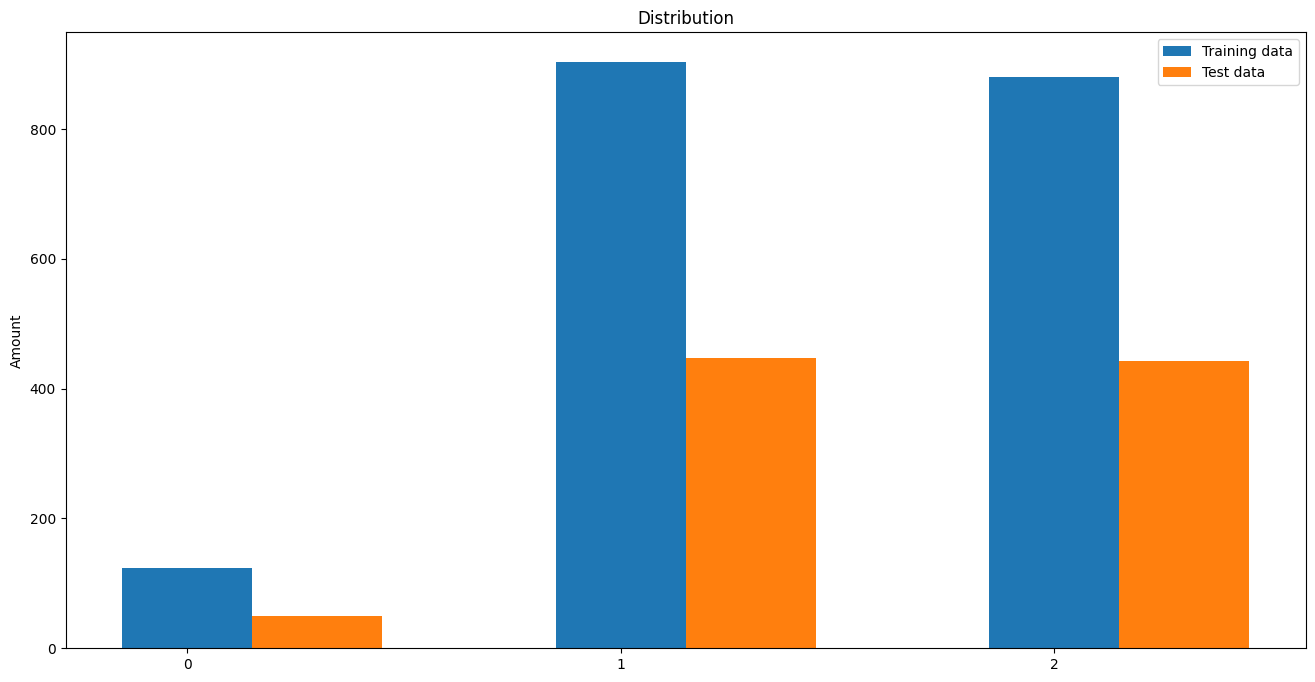


Example sequence from training set: [1 2 1 2 2 1 2 2 2 1 1 2 1 1 2] and its label: 1

Example sequence from test set: [2 2 2 1 2 2 2 1 1 1 1 1 1 0 1] and its label: 1


Gaussian Naive Bayes accuracy: 47.87%
Random forest classifier accuracy: 45.53%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4471 - loss: 1.0363 - val_accuracy: 0.4713 - val_loss: 0.8945
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4650 - loss: 0.9048 - val_accuracy: 0.4713 - val_loss: 0.8857
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4707 - loss: 0.9007 - val_accuracy: 0.4734 - val_loss: 0.8801
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 0.8859 - val_accuracy: 0.4766 - val_loss: 0.8762
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4777 - loss: 0.8987 - val_accuracy: 0.4766 - val_loss: 0.8736
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4740 - loss: 0.9010 - val_accuracy: 0.4766 - val_loss

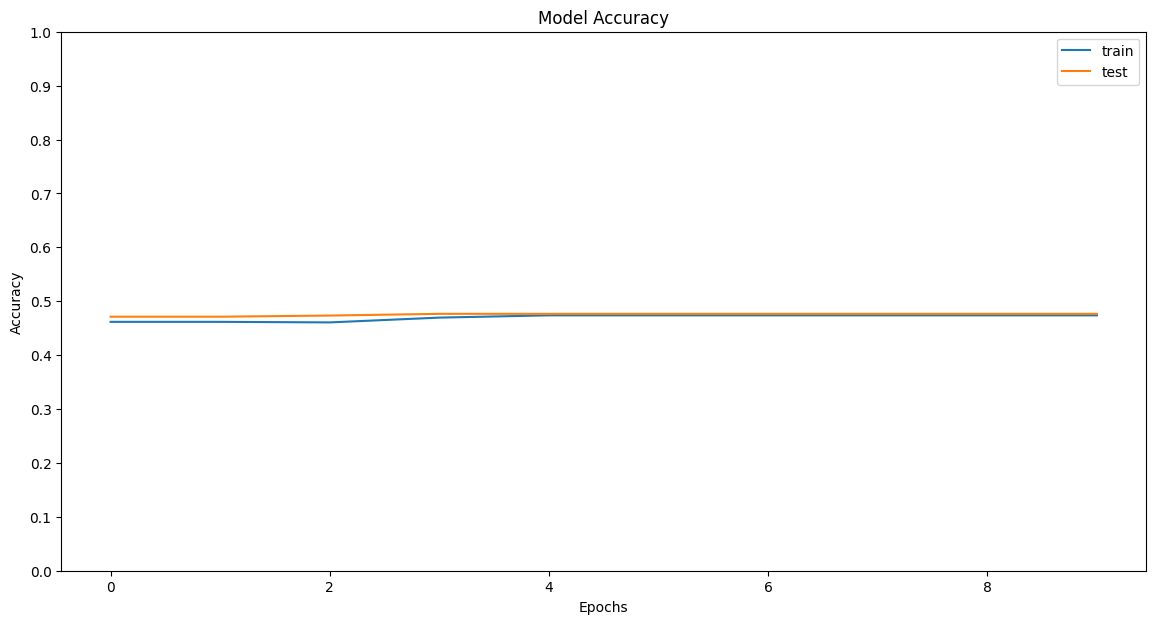

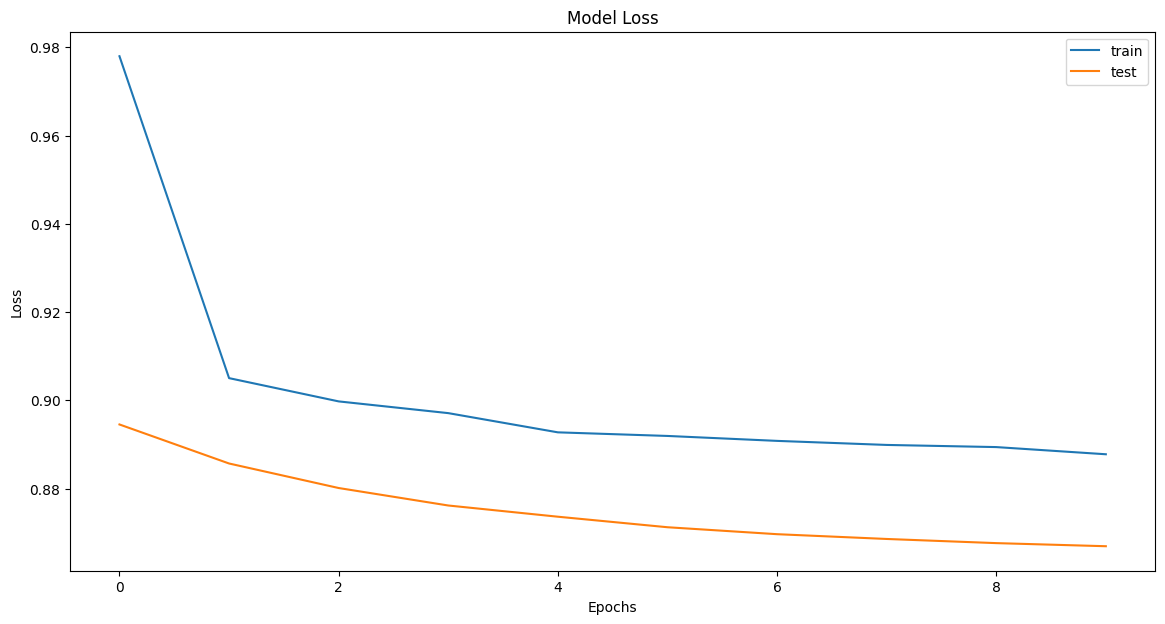

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 47.66%


For threshold set to 0.40, correctness is: 47.66%
For threshold set to 0.45, correctness is: 47.66%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3774 - loss: 1.0405 - val_accuracy: 0.4766 - val_loss: 0.9258
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4651 - loss: 0.9410 - val_accuracy: 0.4766 - val_loss: 0.9091
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4666 - loss: 0.9173 - val_accuracy: 0.4766 - val_loss: 0.8974
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4874 - loss: 0.9096 - val_accuracy: 0.4766 - val_loss: 0.8891
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

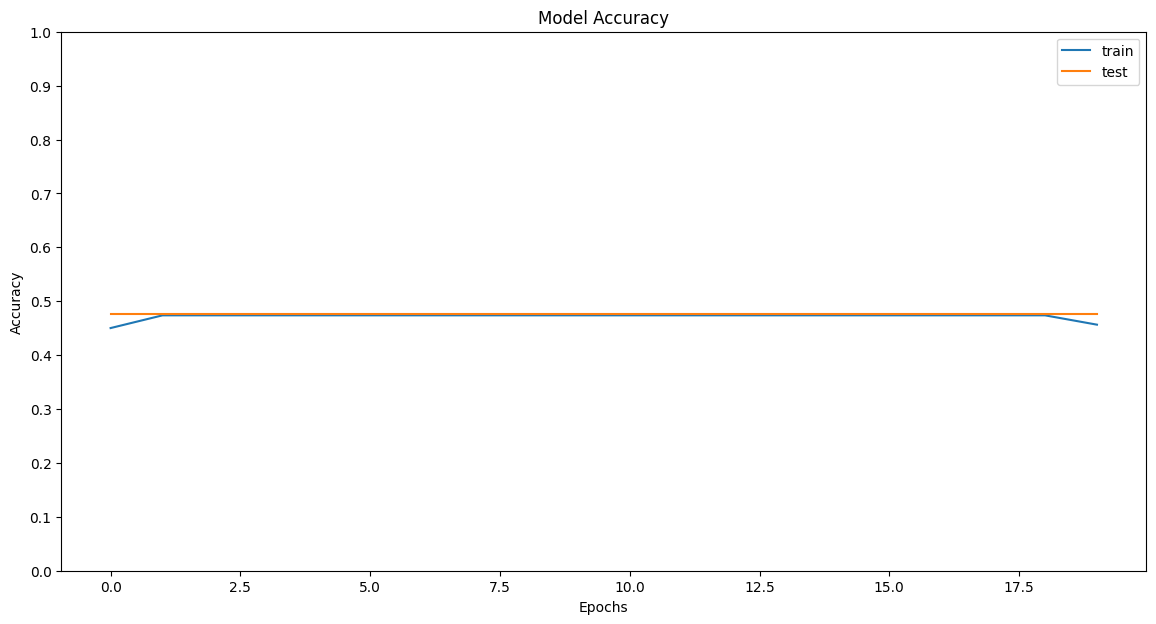

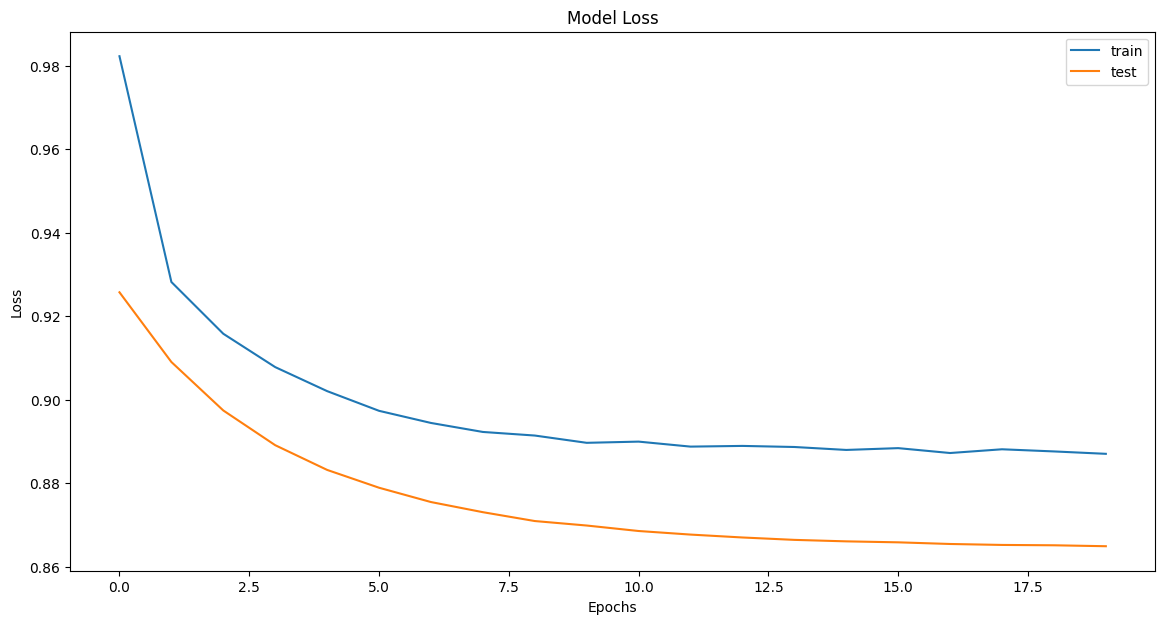

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.66%


For threshold set to 0.40, correctness is: 47.66%
For threshold set to 0.45, correctness is: 47.66%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3750 - loss: 1.0929 - val_accuracy: 0.4713 - val_loss: 1.0154
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 1.0078 - val_accuracy: 0.4734 - val_loss: 0.9706
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4629 - loss: 0.9767 - val_accuracy: 0.4713 - val_loss: 0.9452
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4576 - loss: 0.9538 - val_accuracy: 0.4713 - val_loss: 0.9283
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

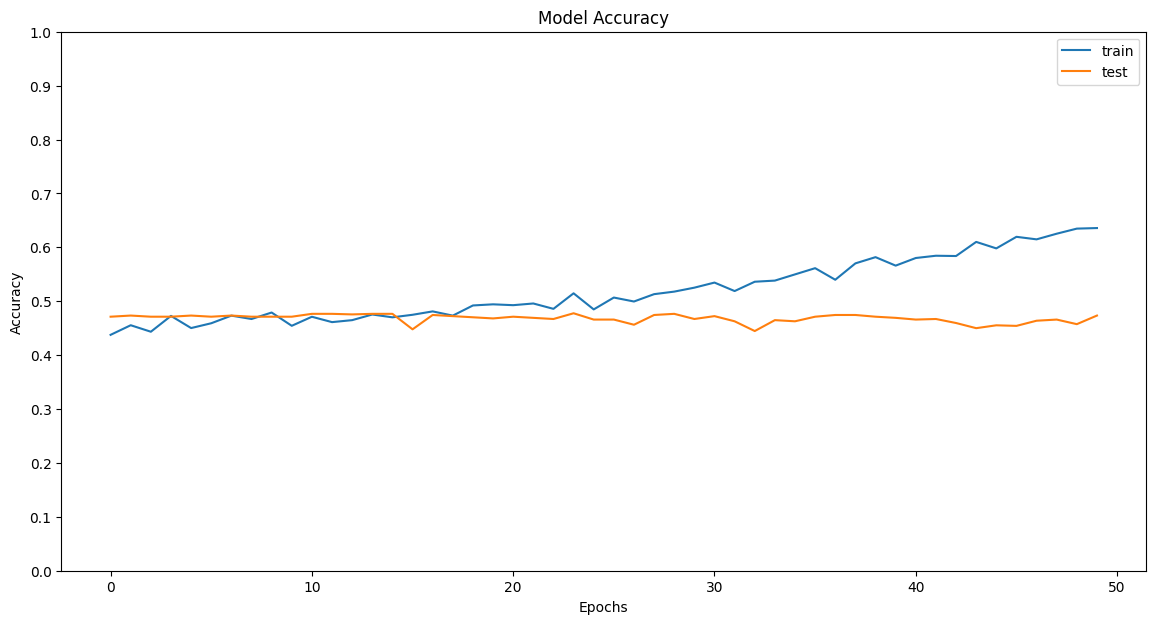

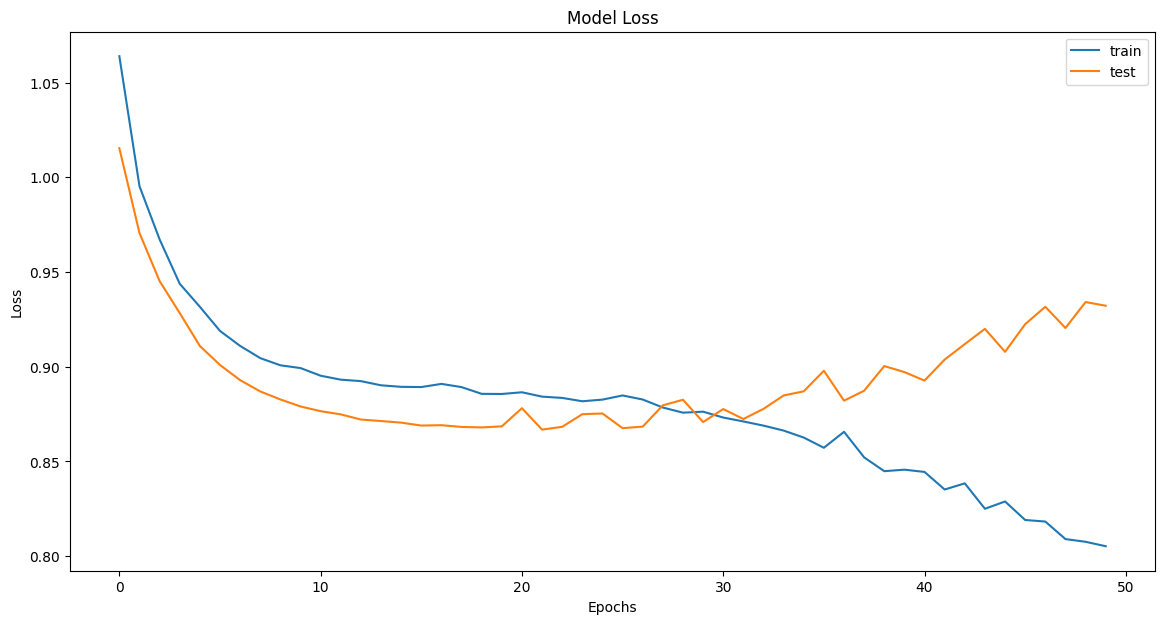

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.34%


For threshold set to 0.40, correctness is: 47.34%
For threshold set to 0.45, correctness is: 47.34%
For threshold set to 0.50, correctness is: 47.20%
For threshold set to 0.55, correctness is: 47.14%
For threshold set to 0.60, correctness is: 47.17%
For threshold set to 0.65, correctness is: 43.84%
For threshold set to 0.70, correctness is: 41.46%
For threshold set to 0.75, correctness is: 37.50%
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



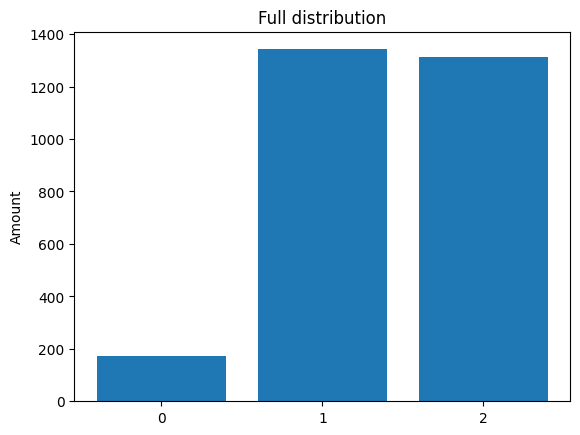

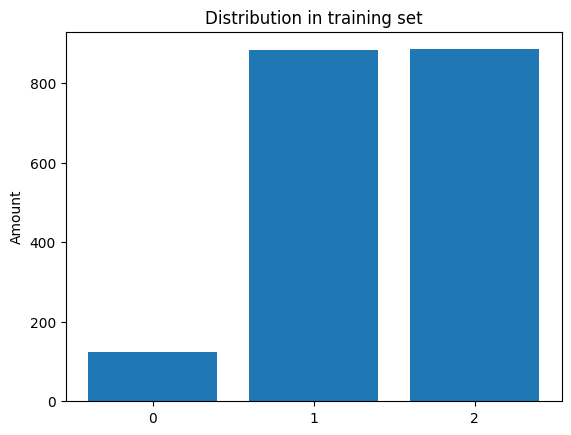

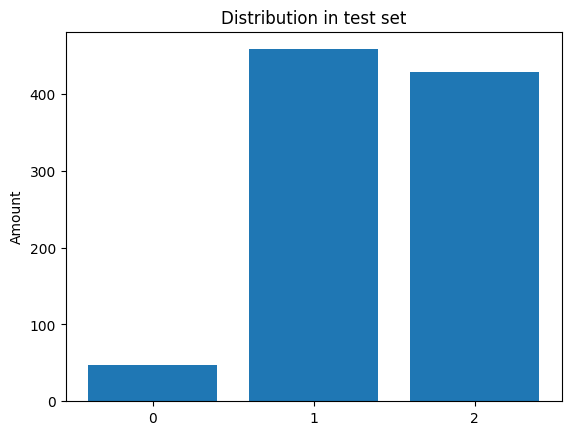

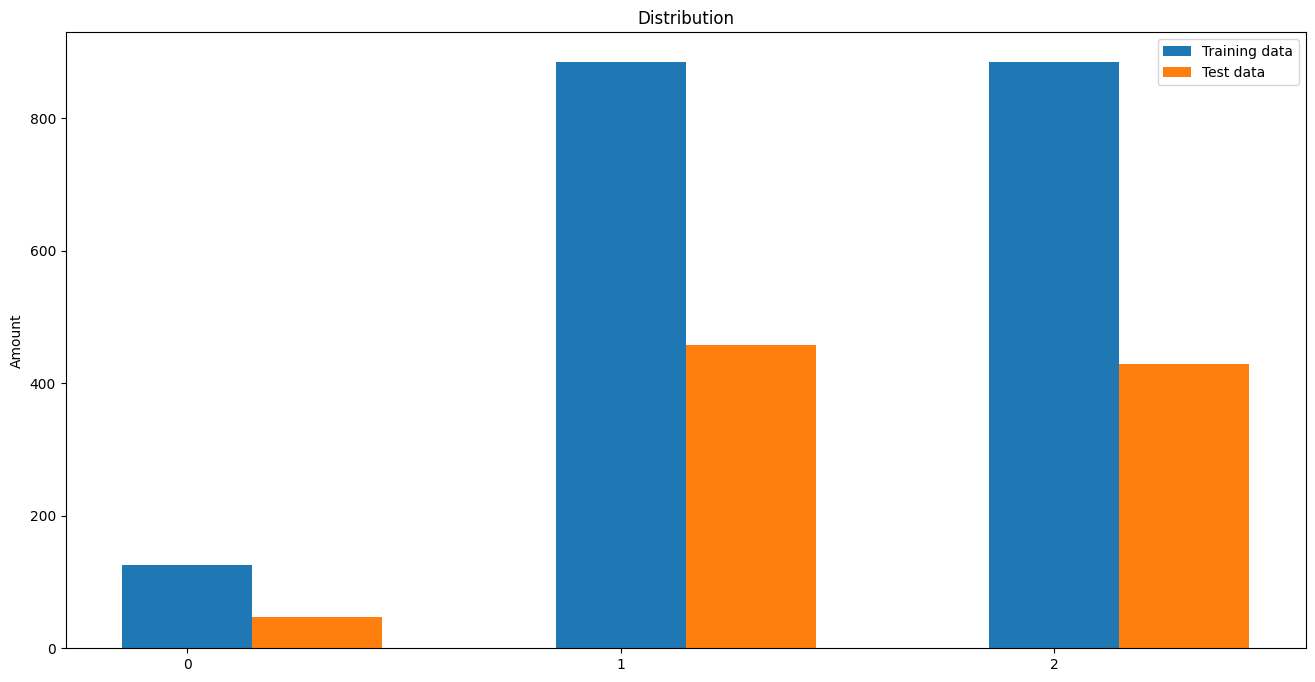


Example sequence from training set: [1 2 1 2 1 1 1 2 2 1 1 2 2 2 2 1 1 2 1 1] and its label: 1

Example sequence from test set: [1 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.68%
Random forest classifier accuracy: 48.07%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4393 - loss: 1.0298 - val_accuracy: 0.4593 - val_loss: 0.9734
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4767 - loss: 0.9662 - val_accuracy: 0.4593 - val_loss: 0.9466
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4661 - loss: 0.9540 - val_accuracy: 0.4593 - val_loss: 0.9268
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4612 - loss: 0.9328 - val_accuracy: 0.4593 - val_loss: 0.9122
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 0.9212 - val_accuracy: 0.4593 - val_loss: 0.9016
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4568 - loss: 0.9108 - val_accurac

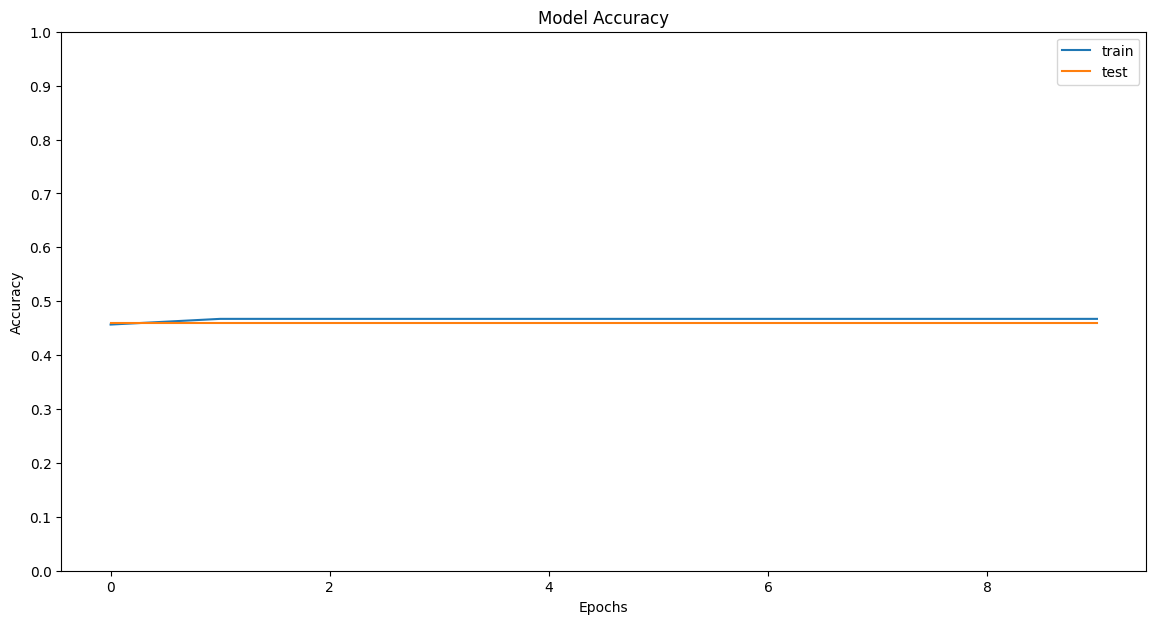

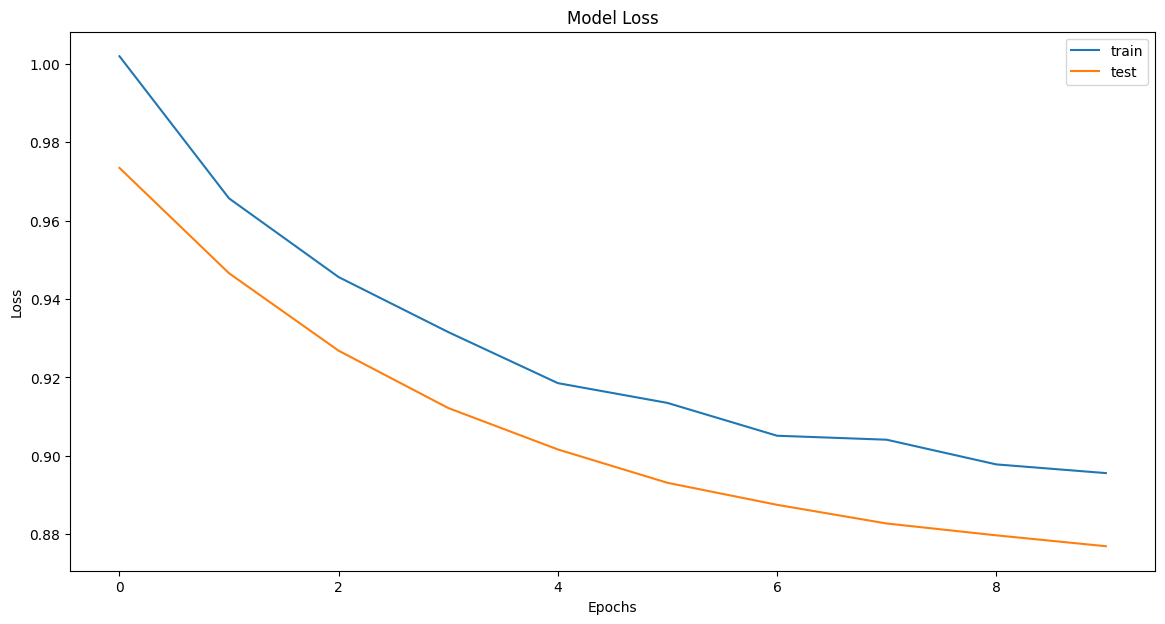

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 45.93%


For threshold set to 0.40, correctness is: 45.93%
For threshold set to 0.45, correctness is: 45.93%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4777 - loss: 1.0417 - val_accuracy: 0.4904 - val_loss: 0.9420
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4553 - loss: 0.9459 - val_accuracy: 0.4904 - val_loss: 0.9218
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4770 - loss: 0.9285 - val_accuracy: 0.4904 - val_loss: 0.9074
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4704 - loss: 0.9274 - val_accuracy: 0.4593 - val_loss: 0.8973
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

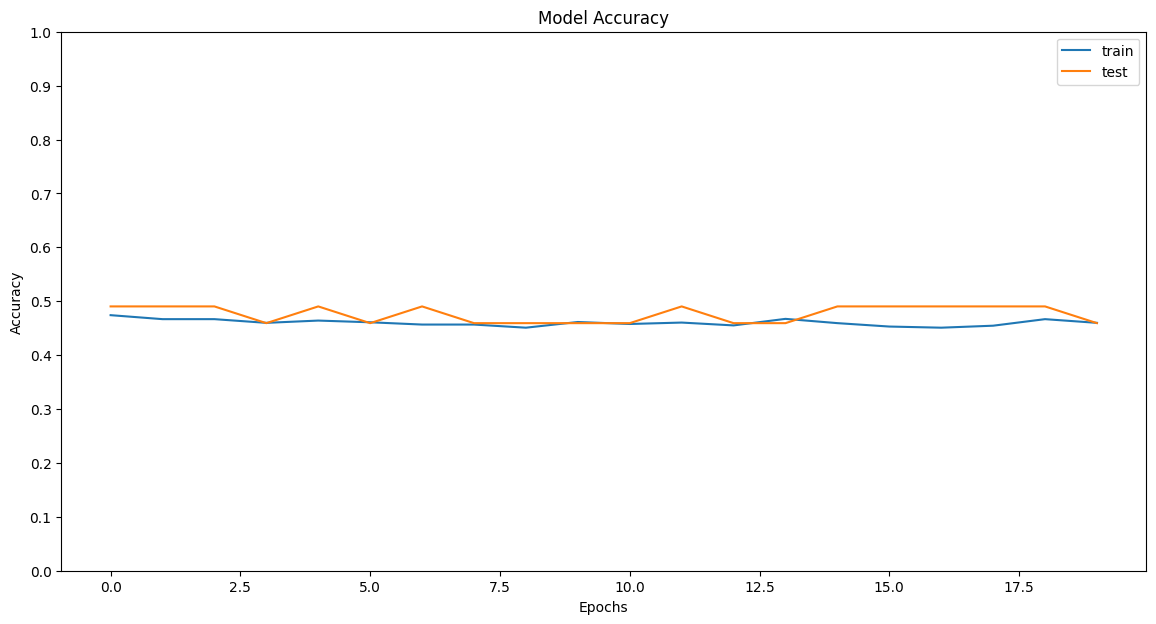

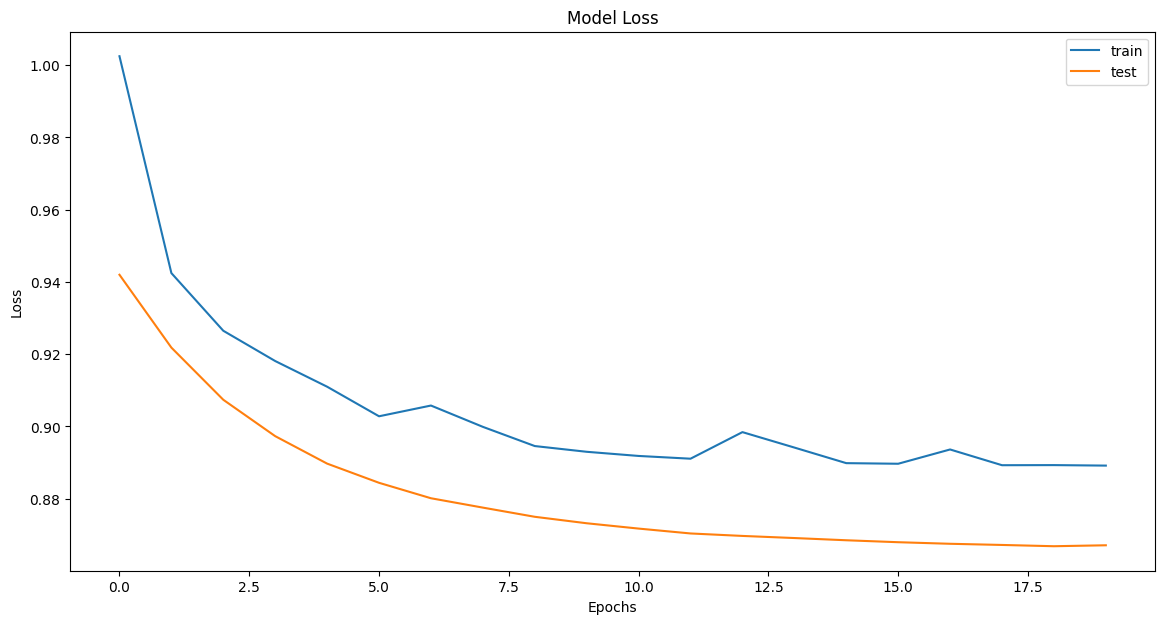

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 45.93%


For threshold set to 0.40, correctness is: 45.93%
For threshold set to 0.45, correctness is: 45.93%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4755 - loss: 0.9756 - val_accuracy: 0.4904 - val_loss: 0.9158
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4586 - loss: 0.9305 - val_accuracy: 0.4904 - val_loss: 0.9009
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4922 - loss: 0.9143 - val_accuracy: 0.4904 - val_loss: 0.8914
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4472 - loss: 0.9075 - val_accuracy: 0.4904 - val_loss: 0.8848
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

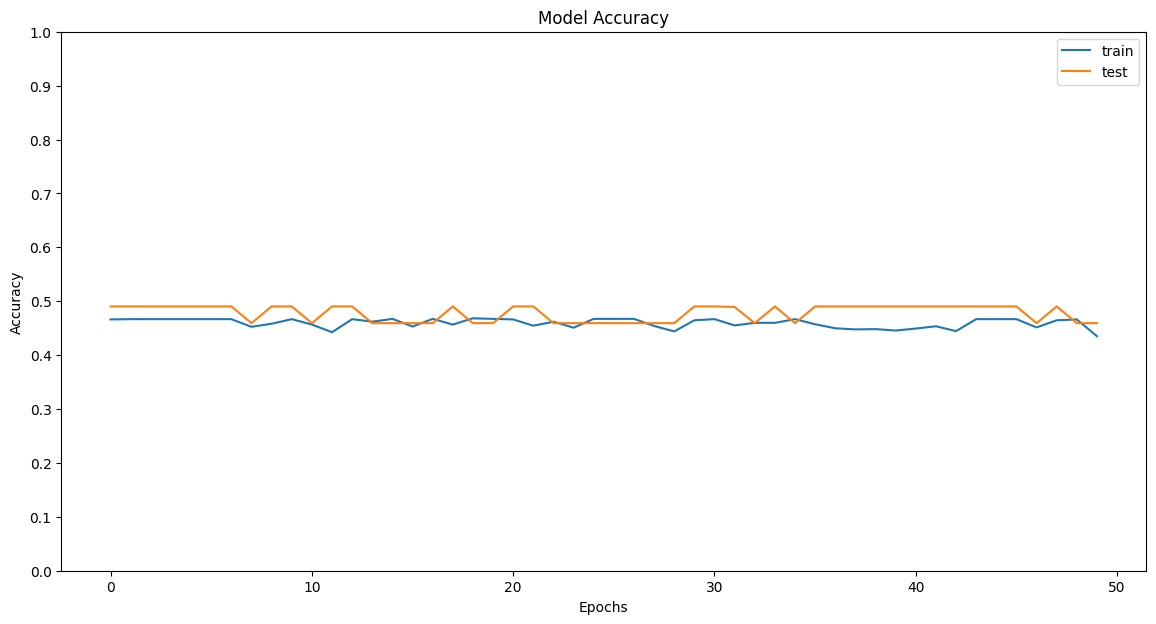

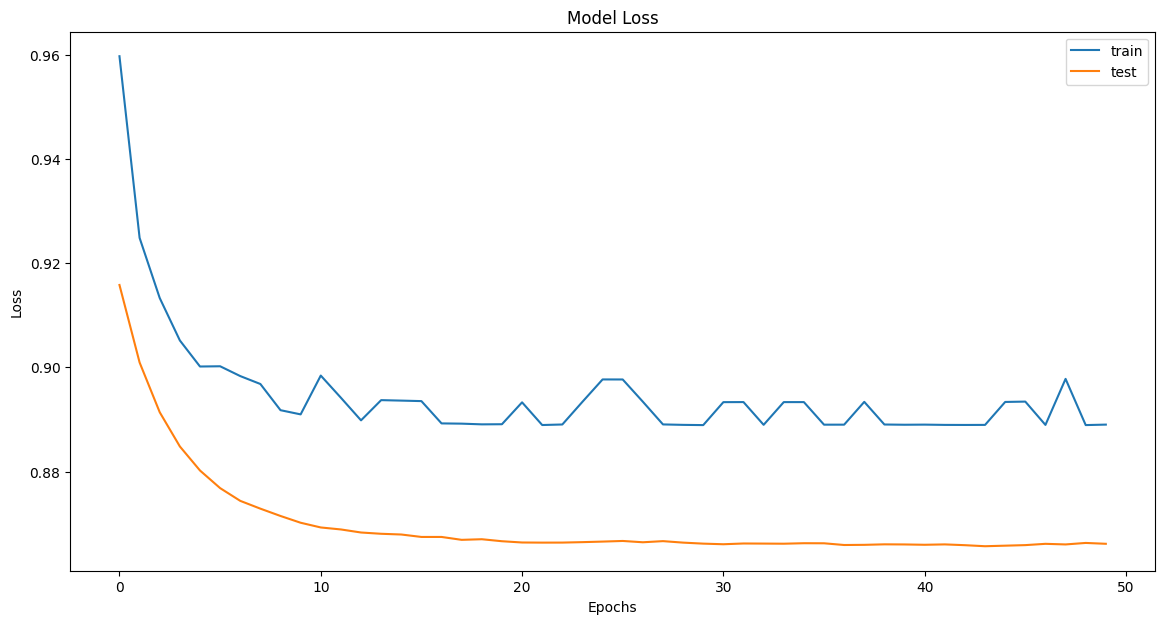

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 45.93%


For threshold set to 0.40, correctness is: 45.93%
For threshold set to 0.45, correctness is: 45.93%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



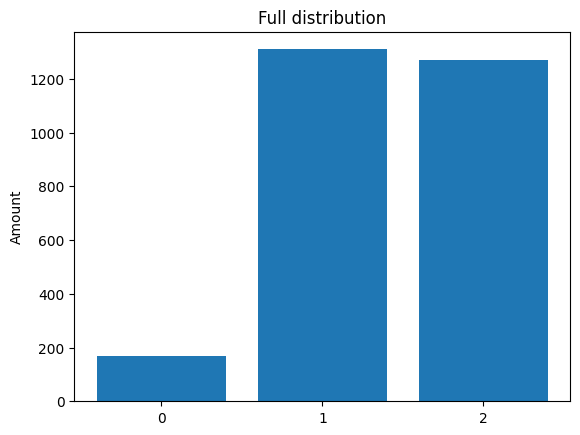

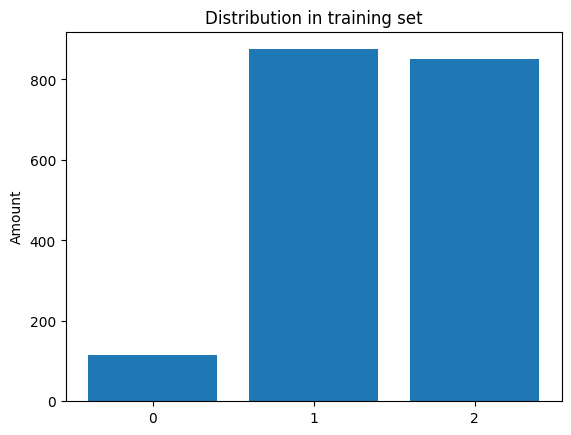

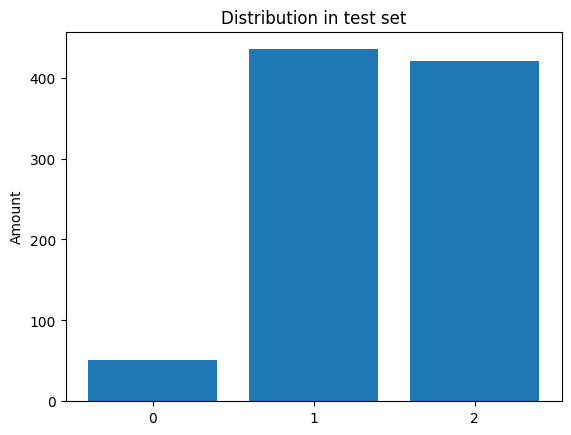

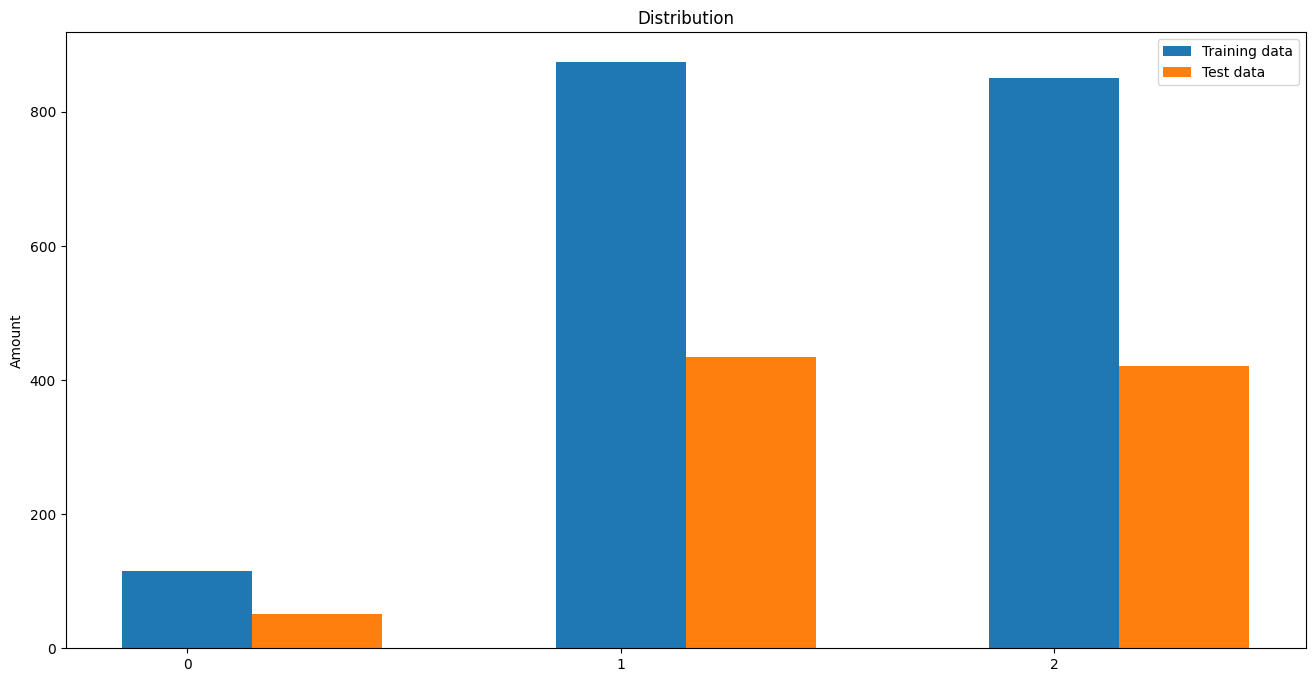


Example sequence from training set: [2 0 2 2 2 0 1 2 0 2 0 1 1 1 2 1 1 2 0 0 2 1 1 1 1 2 0 2 2 1 0 2 2 2 2 1 2
 1 1 2] and its label: 1

Example sequence from test set: [2 1 2 2 2 1 1 1 1 1 1 0 1 1 2 2 2 2 1 1 2 2 2 1 1 2 1 1 0 1 2 2 0 1 2 2 2
 1 1 1] and its label: 1


Gaussian Naive Bayes accuracy: 47.08%
Random forest classifier accuracy: 49.39%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4763 - loss: 1.0310 - val_accuracy: 0.4796 - val_loss: 0.9127
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4742 - loss: 0.9201 - val_accuracy: 0.4796 - val_loss: 0.9054
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4667 - loss: 0.9062 - val_accuracy: 0.4796 - val_loss: 0.8906
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4685 - loss: 0.9005 - val_accuracy: 0.4796 - val_loss: 0.8845
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4751 - loss: 0.8970 - val_accuracy: 0.4796 - val_loss: 0.8799
Epoch 6/10
58/5

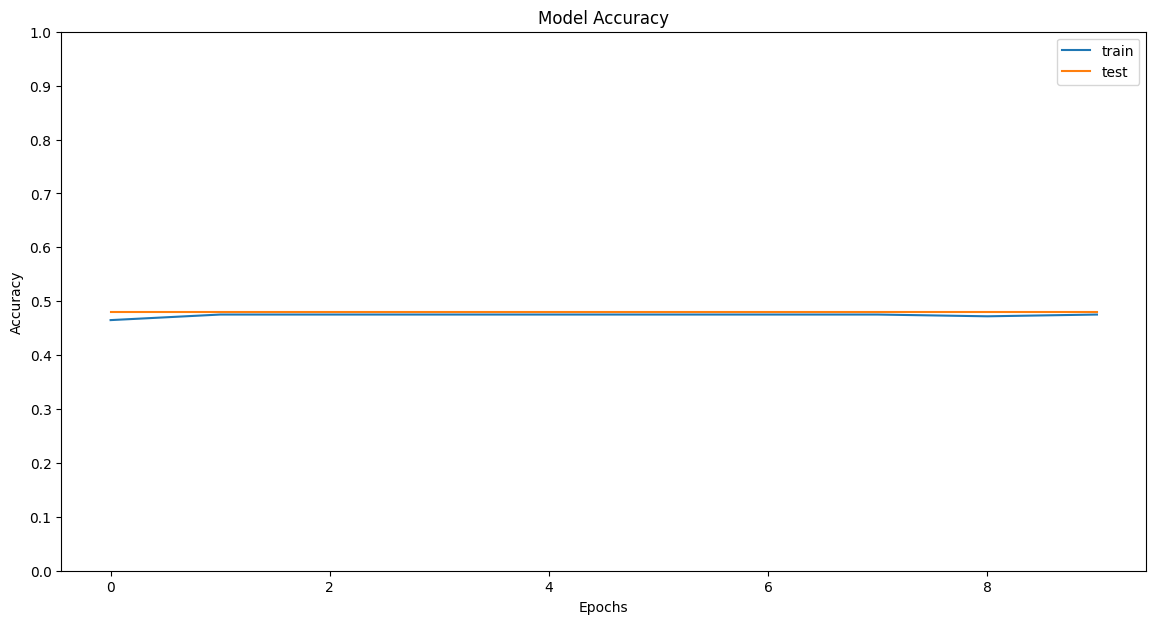

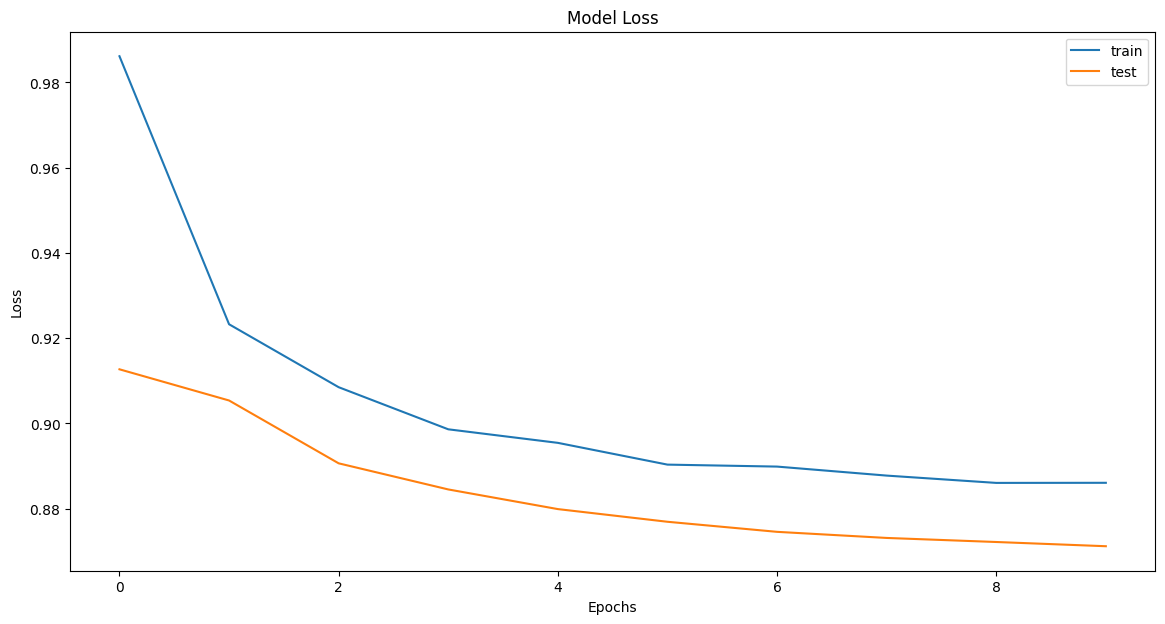

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Modal accuracy on test set: 47.96%


For threshold set to 0.40, correctness is: 47.96%
For threshold set to 0.45, correctness is: 47.96%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4742 - loss: 0.9705 - val_accuracy: 0.4796 - val_loss: 0.9030
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4775 - loss: 0.9005 - val_accuracy: 0.4796 - val_loss: 0.8939
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.8896 - val_accuracy: 0.4796 - val_loss: 0.8870
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4706 - loss: 0.8963 - val_accuracy: 0.4796 - val_loss: 0.8824
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

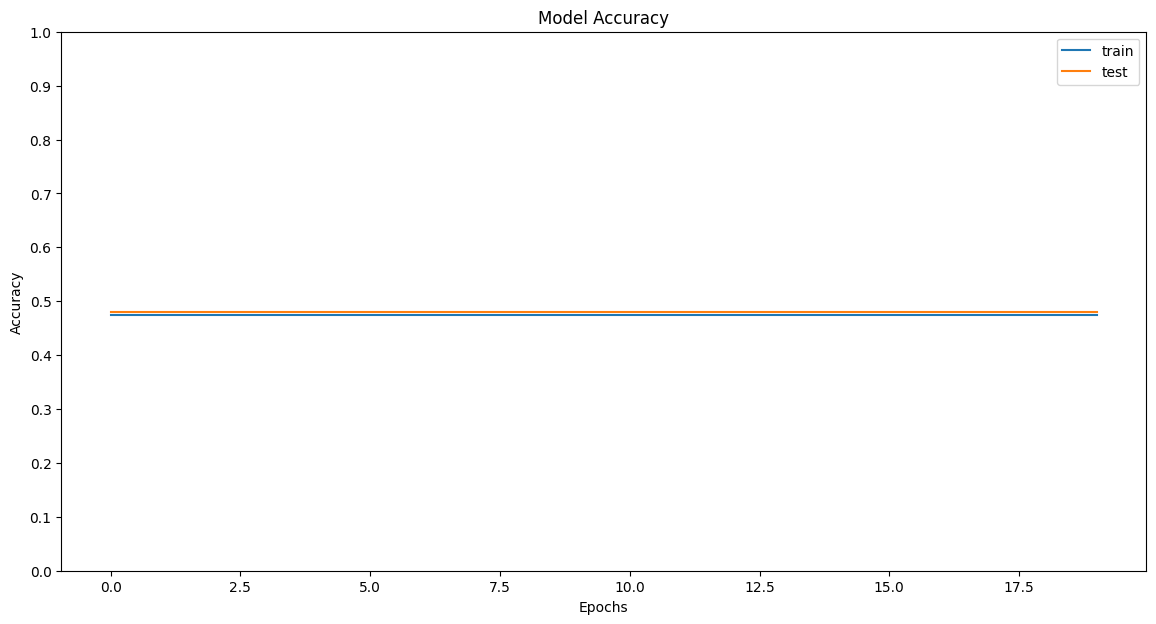

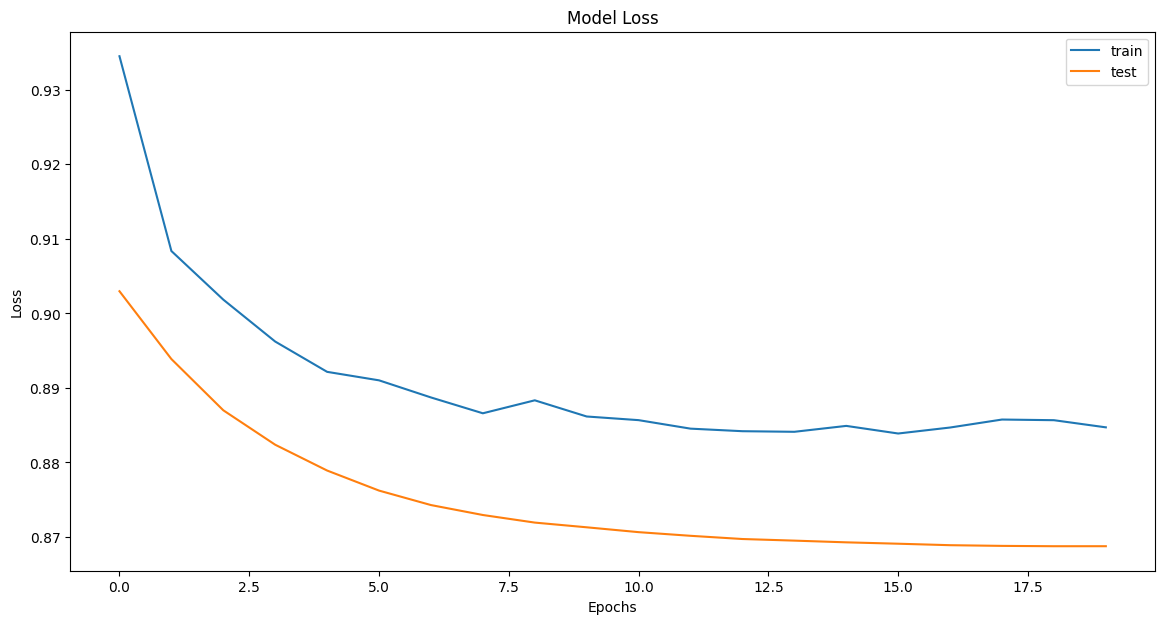

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 47.96%


For threshold set to 0.40, correctness is: 47.96%
For threshold set to 0.45, correctness is: 47.96%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4431 - loss: 1.0151 - val_accuracy: 0.4631 - val_loss: 0.9415
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4797 - loss: 0.9432 - val_accuracy: 0.4796 - val_loss: 0.9218
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4832 - loss: 0.9165 - val_accuracy: 0.4796 - val_loss: 0.9078
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4829 - loss: 0.9150 - val_accuracy: 0.4796 - val_loss: 0.8982
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

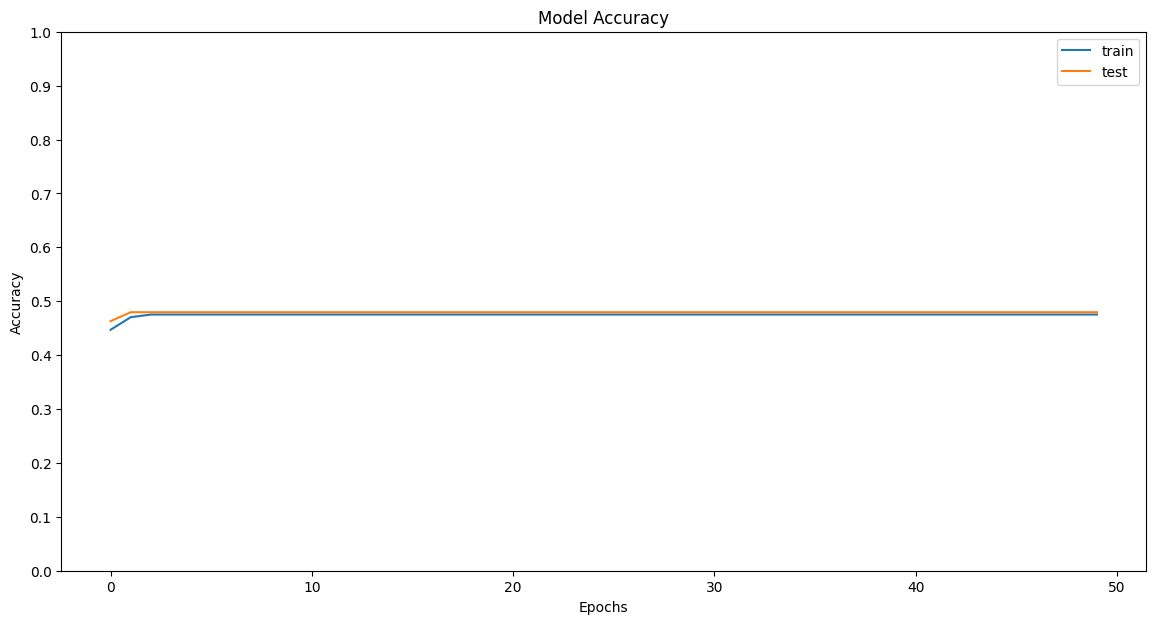

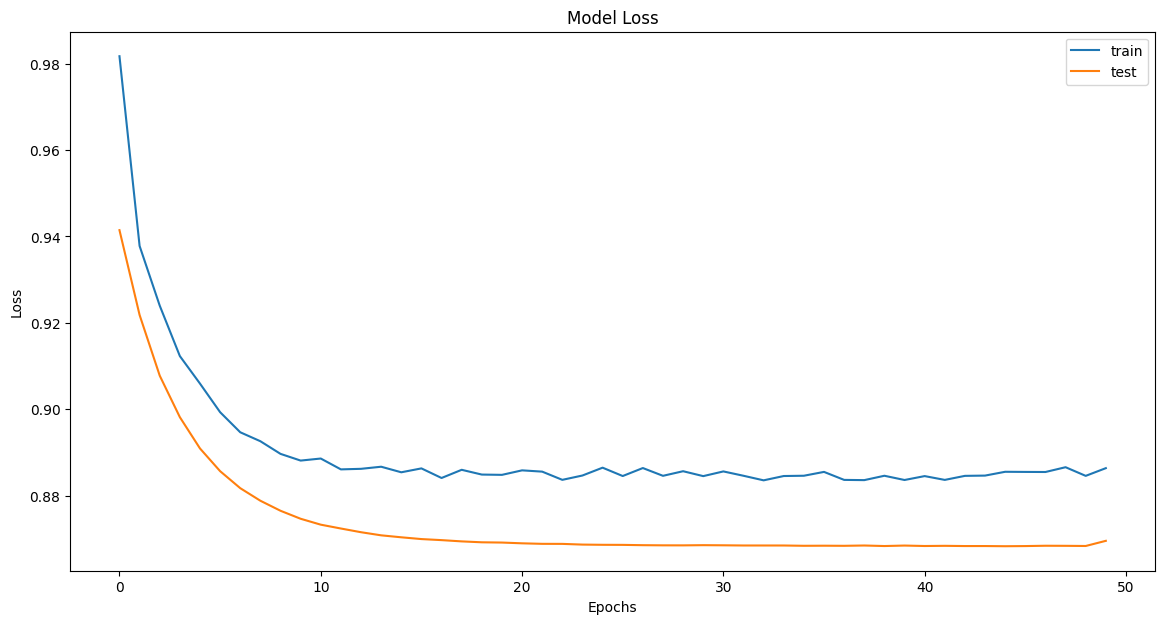

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 47.96%


For threshold set to 0.40, correctness is: 47.96%
For threshold set to 0.45, correctness is: 47.96%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 40, Epoch: 10, Accuracy: 47.96%
Chunk size: 40, Epoch: 20, Accuracy: 47.96%
Chunk size: 40, Epoch: 50, Accuracy: 47.96%

Data from file: plgbet.csv


Example sequence: ['red', 'black', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'green']

red: Counter({1: 366, 2: 180, 3: 99, 4: 29, 5: 13, 6: 9, 7: 4, 10: 2, 8: 1})
black: Counter({1: 387, 2: 164, 3: 90, 4: 40, 5: 19, 7: 6, 6: 5, 8: 2, 9: 1})
green: Counter({1: 171, 2: 6})




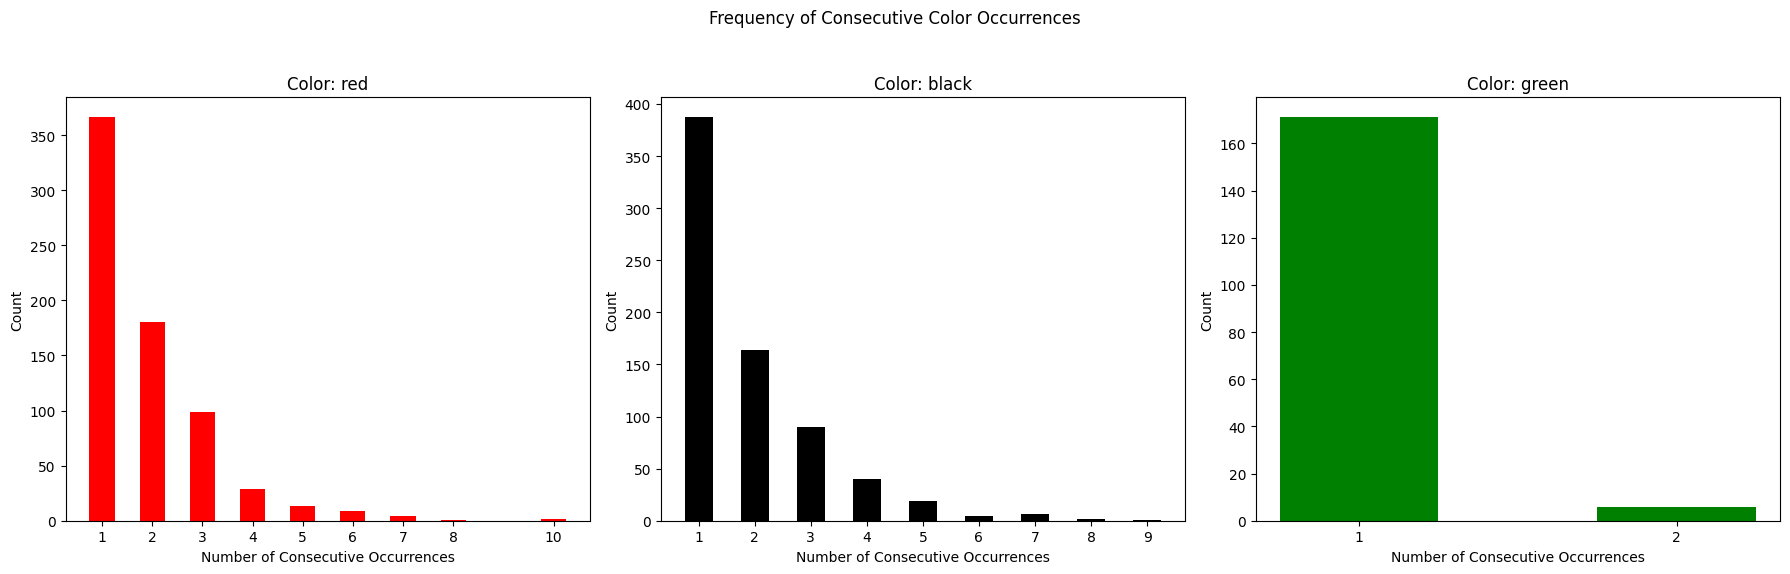

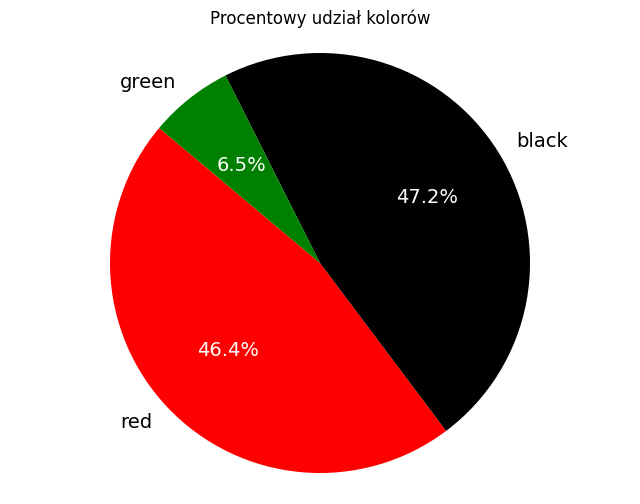


(2,)



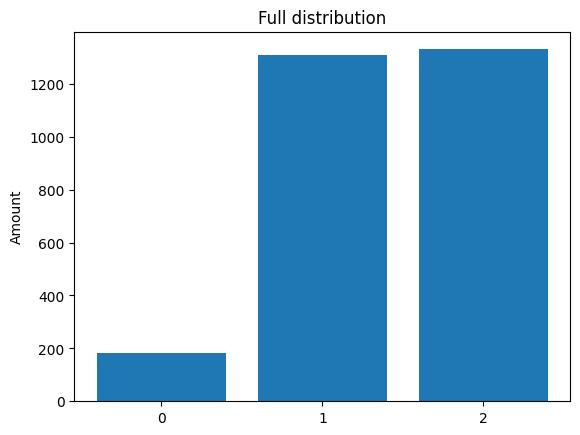

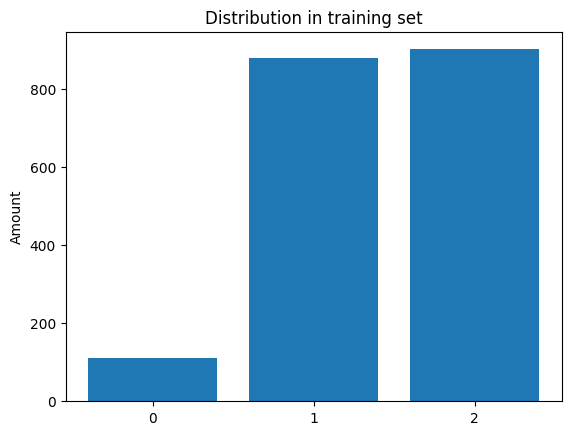

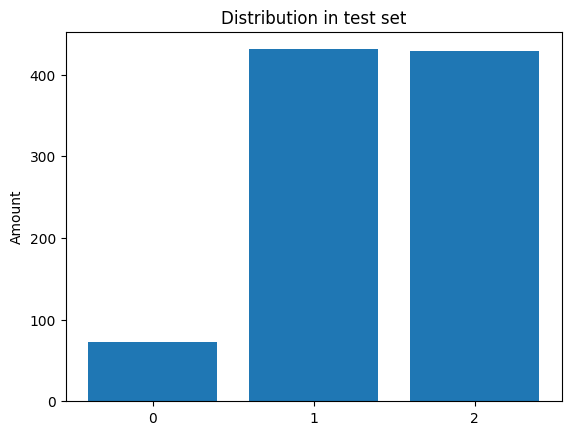

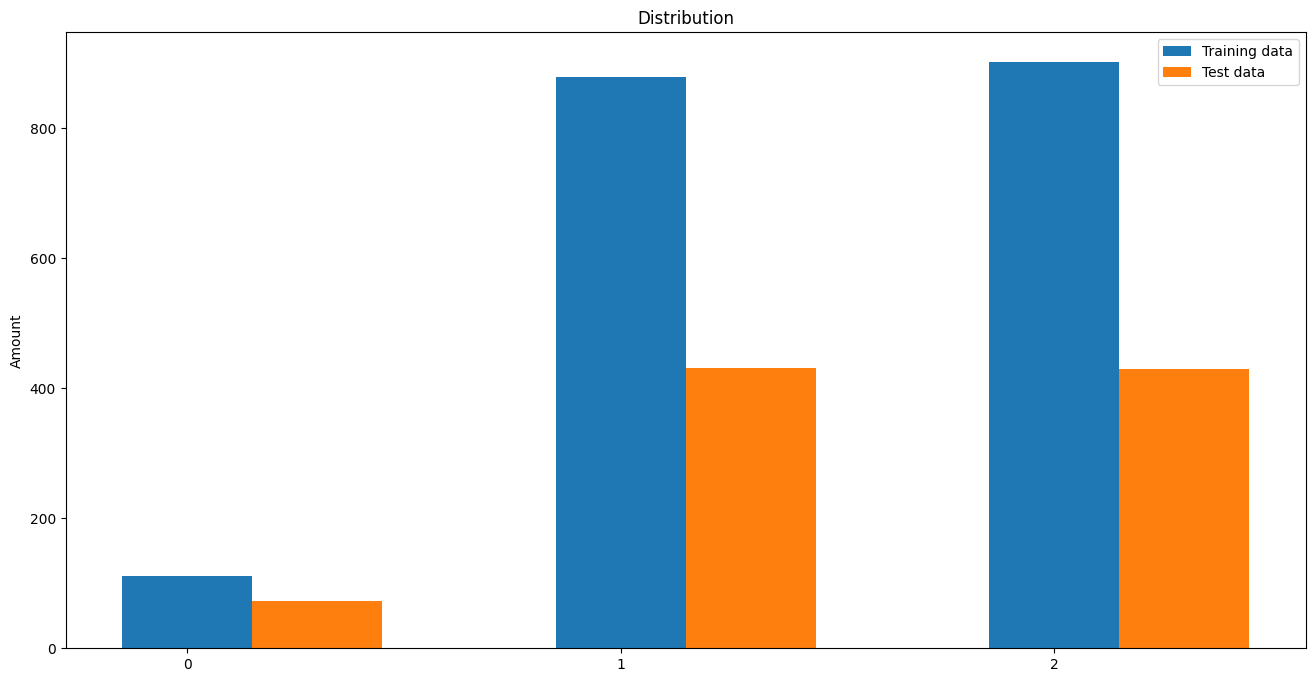


Example sequence from training set: [2 1] and its label: 1

Example sequence from test set: [1 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.14%
Random forest classifier accuracy: 46.24%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4195 - loss: 1.0955 - val_accuracy: 0.4624 - val_loss: 0.9981
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 0.9752 - val_accuracy: 0.4592 - val_loss: 0.9675
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4593 - loss: 0.9485 - val_accuracy: 0.4624 - val_loss: 0.9513
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4771 - loss: 0.9136 - val_accuracy: 0.4635 - val_loss: 0.9382
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4862 - loss: 0.9051 - val_accuracy: 0.4635 - val_loss: 0.9306
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4676 - loss: 0.8964 - val_accuracy: 0.4635 - val_loss: 0.9257
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

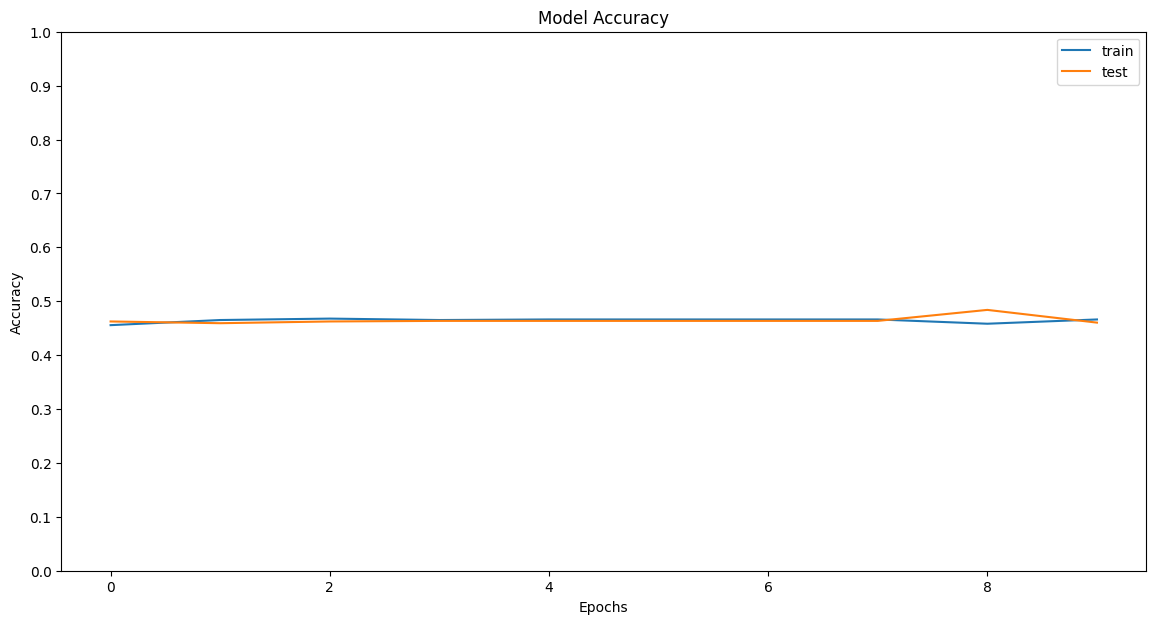

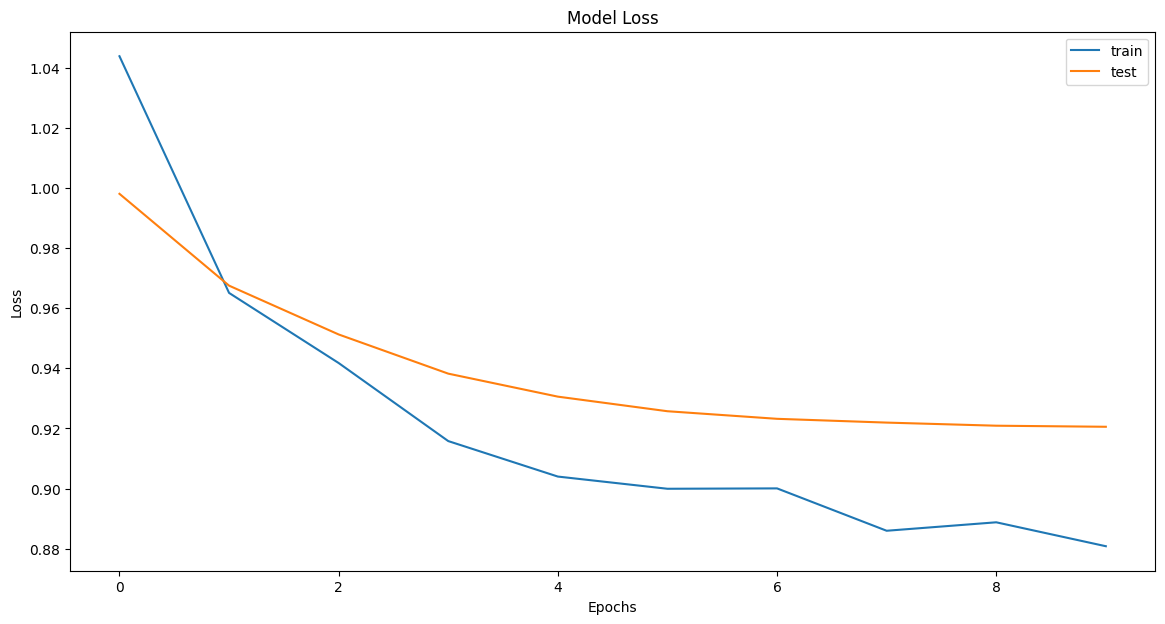

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 46.03%


For threshold set to 0.40, correctness is: 46.03%
For threshold set to 0.45, correctness is: 46.03%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4438 - loss: 1.0272 - val_accuracy: 0.4635 - val_loss: 0.9596
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4662 - loss: 0.9341 - val_accuracy: 0.4635 - val_loss: 0.9429
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4719 - loss: 0.9137 - val_accuracy: 0.4689 - val_loss: 0.9333
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4866 - loss: 0.9054 - val_accuracy: 0.4635 - val_loss: 0.9307
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

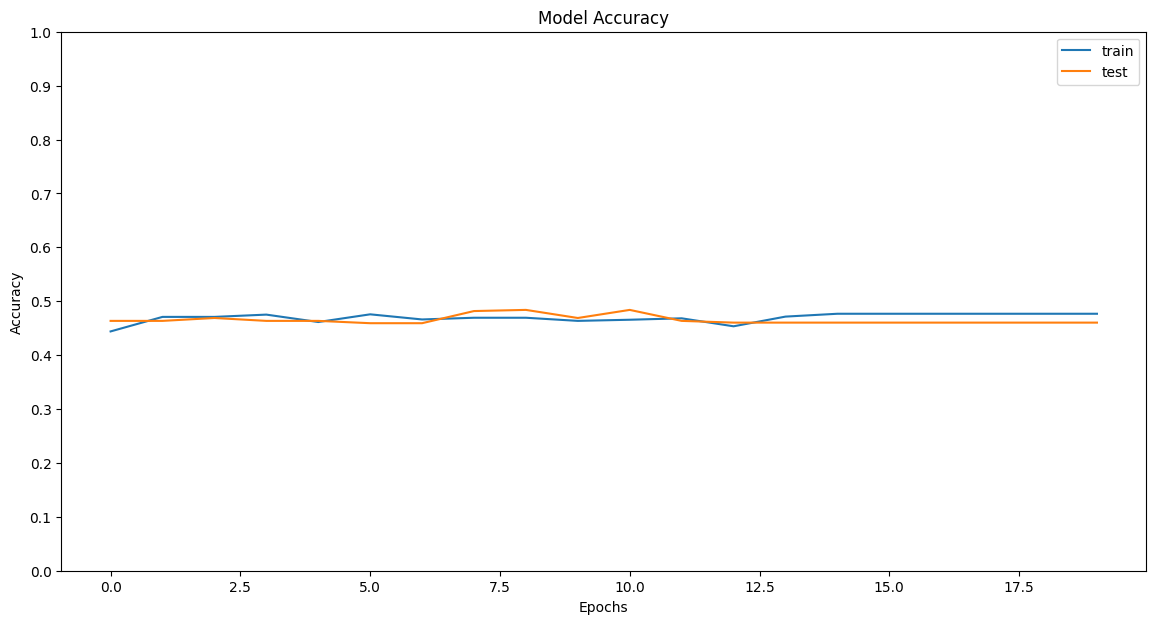

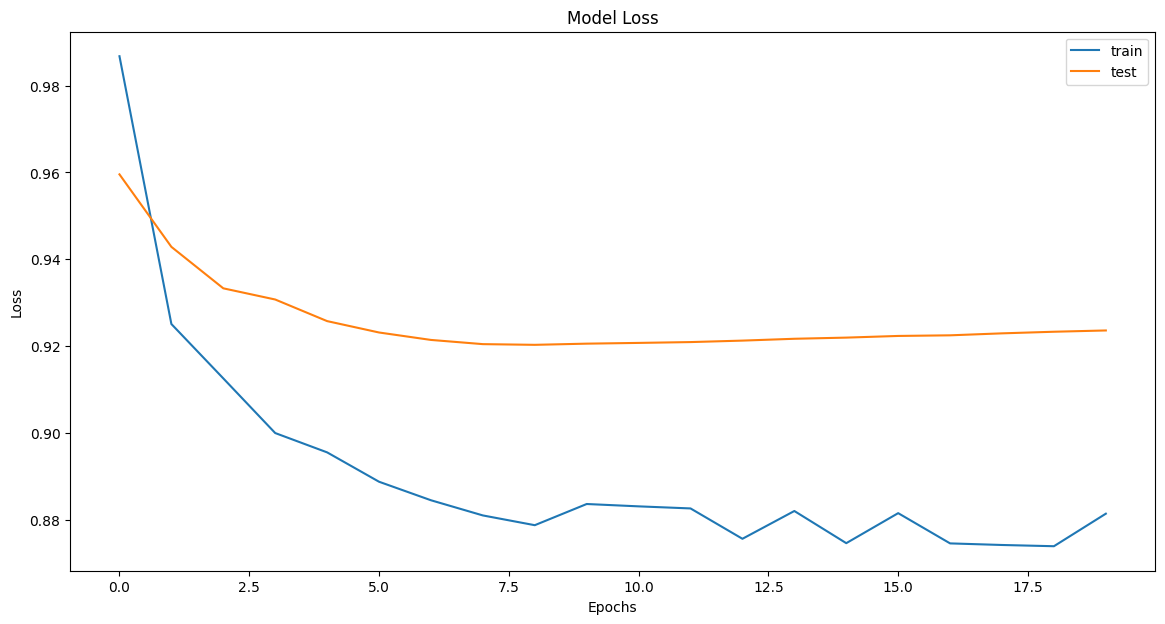

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 46.03%


For threshold set to 0.40, correctness is: 46.03%
For threshold set to 0.45, correctness is: 46.03%
For threshold set to 0.50, correctness is: 100.00%
For threshold set to 0.55, correctness is: 100.00%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3026 - loss: 1.0702 - val_accuracy: 0.4624 - val_loss: 0.9834
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4560 - loss: 0.9660 - val_accuracy: 0.4624 - val_loss: 0.9618
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4658 - loss: 0.9360 - val_accuracy: 0.4624 - val_loss: 0.9474
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4663 - loss: 0.9211 - val_accuracy: 0.4539 - val_loss: 0.9374
Epoch 5/50
60/60 ━━━━━

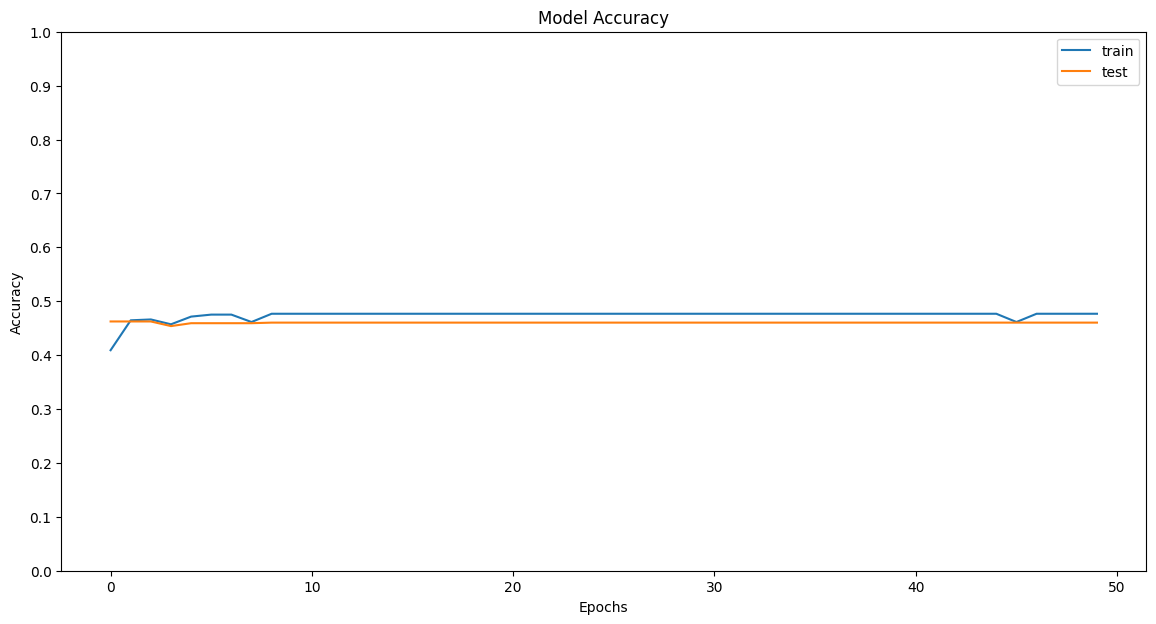

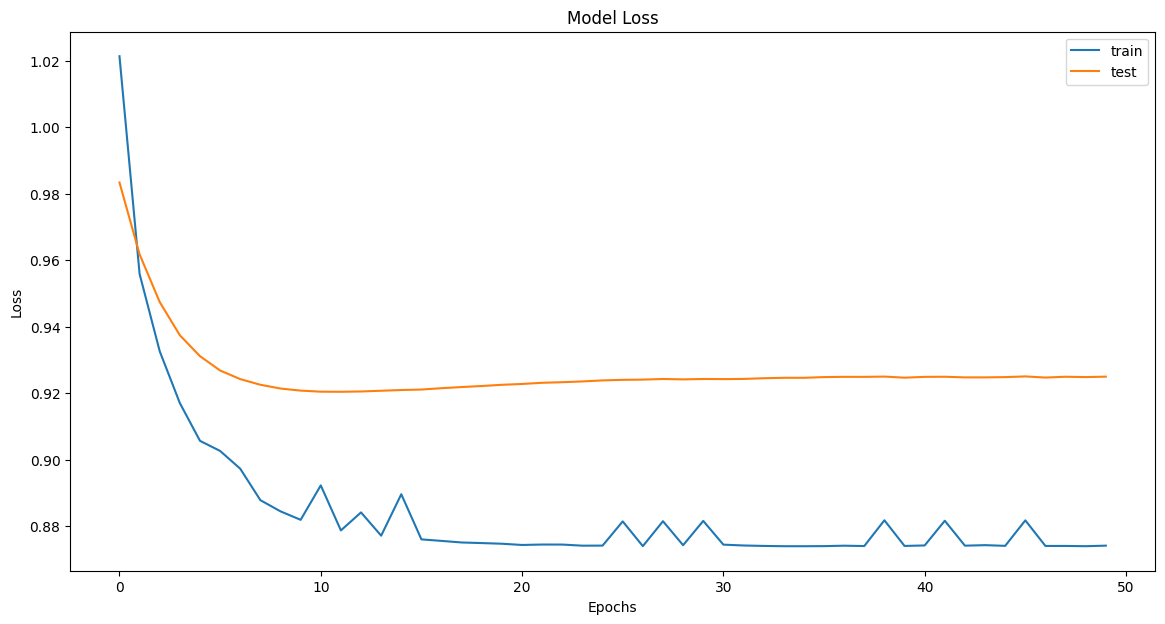

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 46.03%


For threshold set to 0.40, correctness is: 46.03%
For threshold set to 0.45, correctness is: 46.03%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



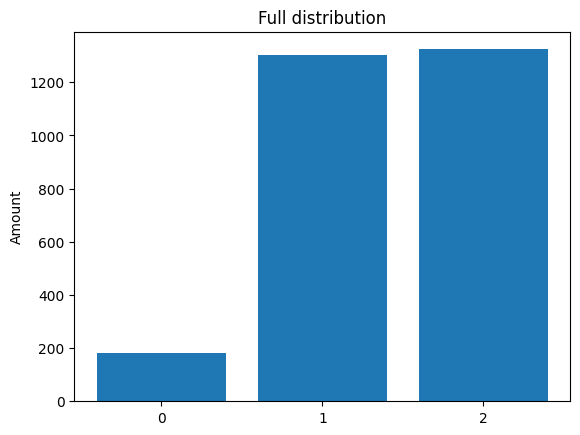

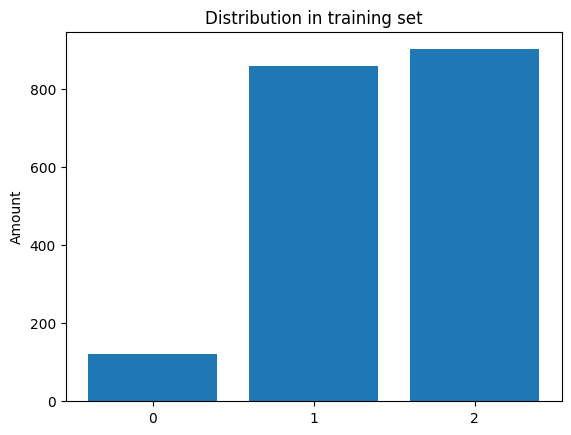

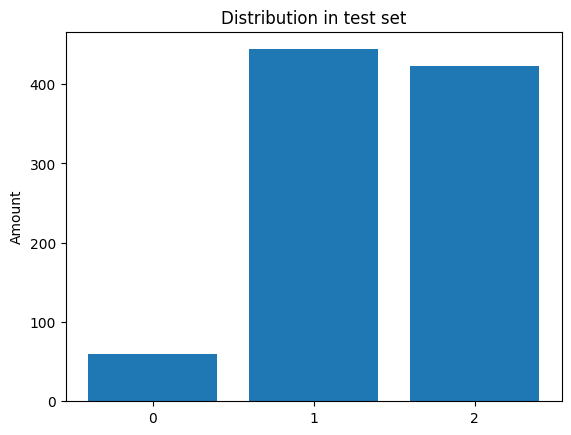

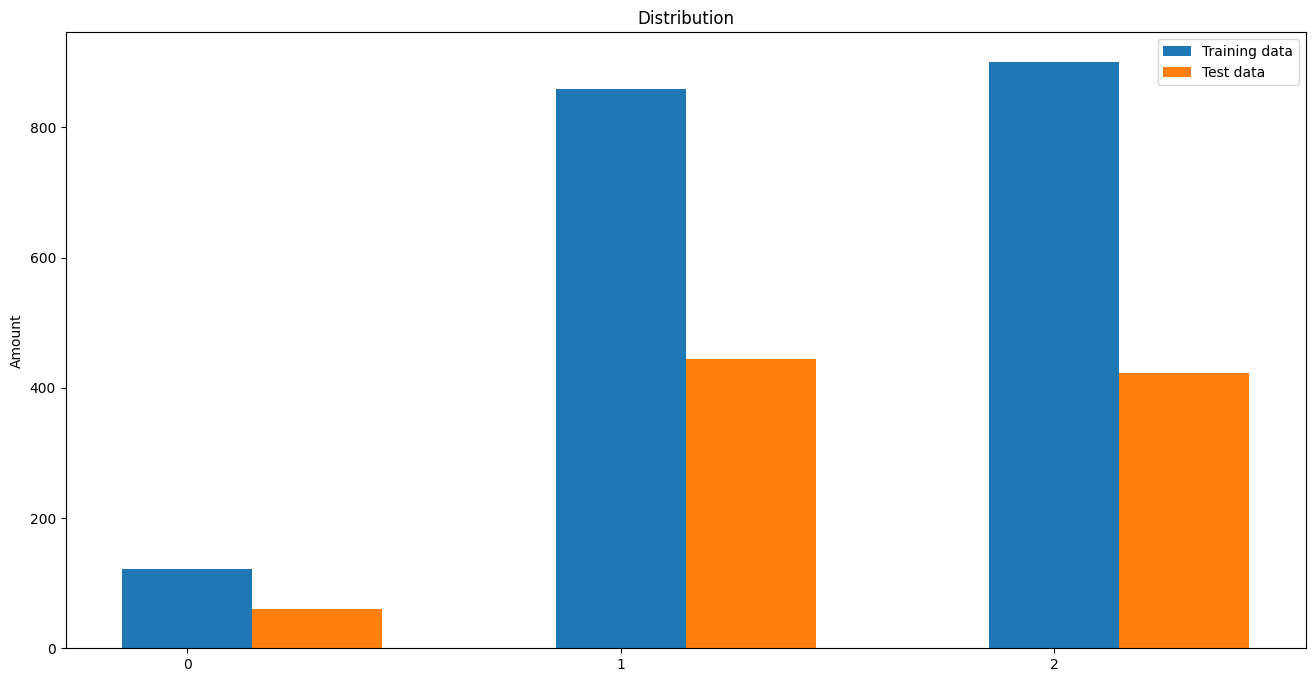


Example sequence from training set: [2 1 2 2 1] and its label: 1

Example sequence from test set: [2 1 2 1 0] and its label: 2


Gaussian Naive Bayes accuracy: 43.58%
Random forest classifier accuracy: 43.80%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4634 - loss: 1.0292 - val_accuracy: 0.4563 - val_loss: 0.9411
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4642 - loss: 0.9395 - val_accuracy: 0.4563 - val_loss: 0.9260
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4771 - loss: 0.9193 - val_accuracy: 0.4563 - val_loss: 0.9154
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4848 - loss: 0.9081 - val_accuracy: 0.4563 - val_loss: 0.9078
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4852 - loss: 0.9028 - val_accuracy: 0.4563 - val_loss: 0.9026
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4899 - loss: 0.9022 - val_accuracy: 0.4563 - val_loss: 0.8987
Epoch 7/10
59/59 ━━━━━━━━━━━━━━

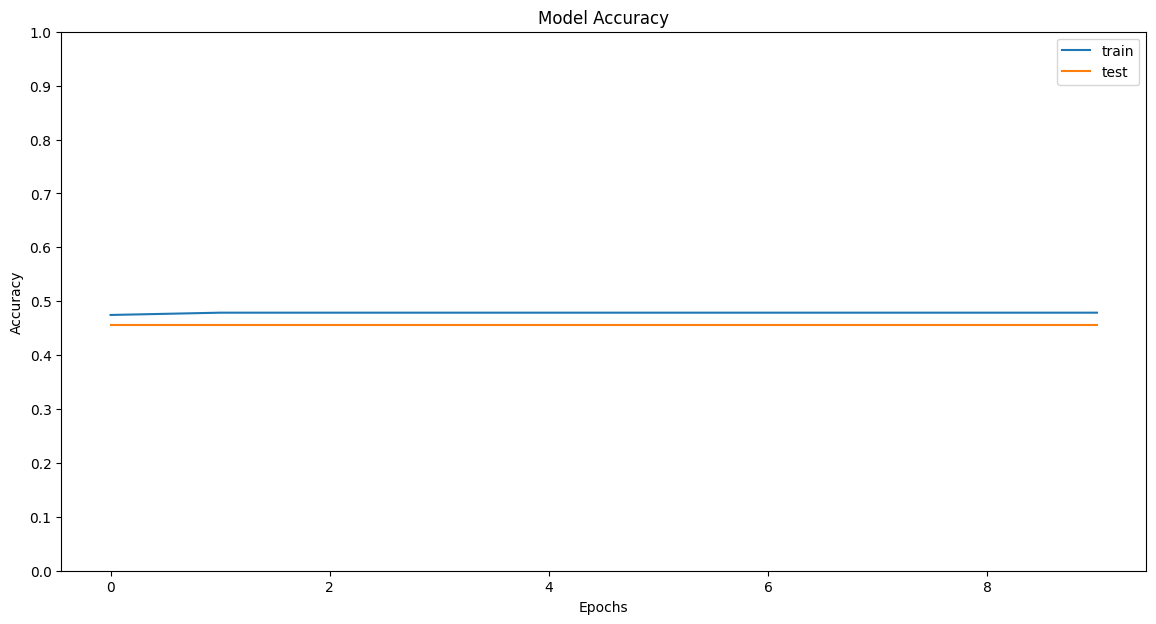

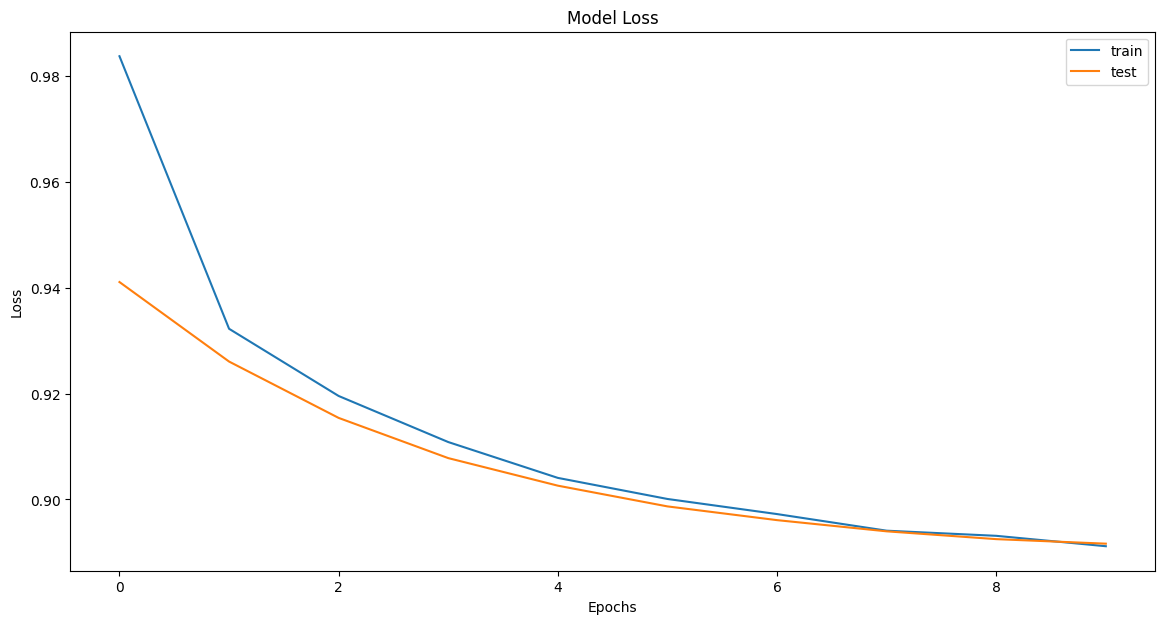

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 45.63%


For threshold set to 0.40, correctness is: 45.63%
For threshold set to 0.45, correctness is: 45.63%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2800 - loss: 1.1035 - val_accuracy: 0.4790 - val_loss: 1.0270
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 1.0110 - val_accuracy: 0.4563 - val_loss: 0.9822
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4724 - loss: 0.9726 - val_accuracy: 0.4563 - val_loss: 0.9547
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4880 - loss: 0.9367 - val_accuracy: 0.4563 - val_loss: 0.9362
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

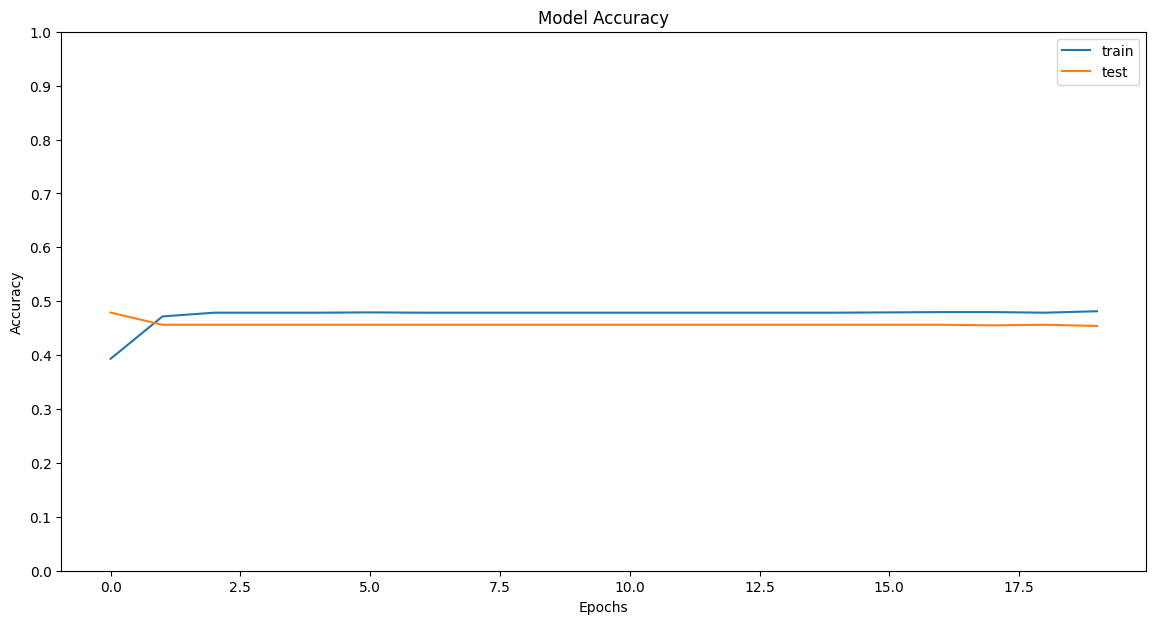

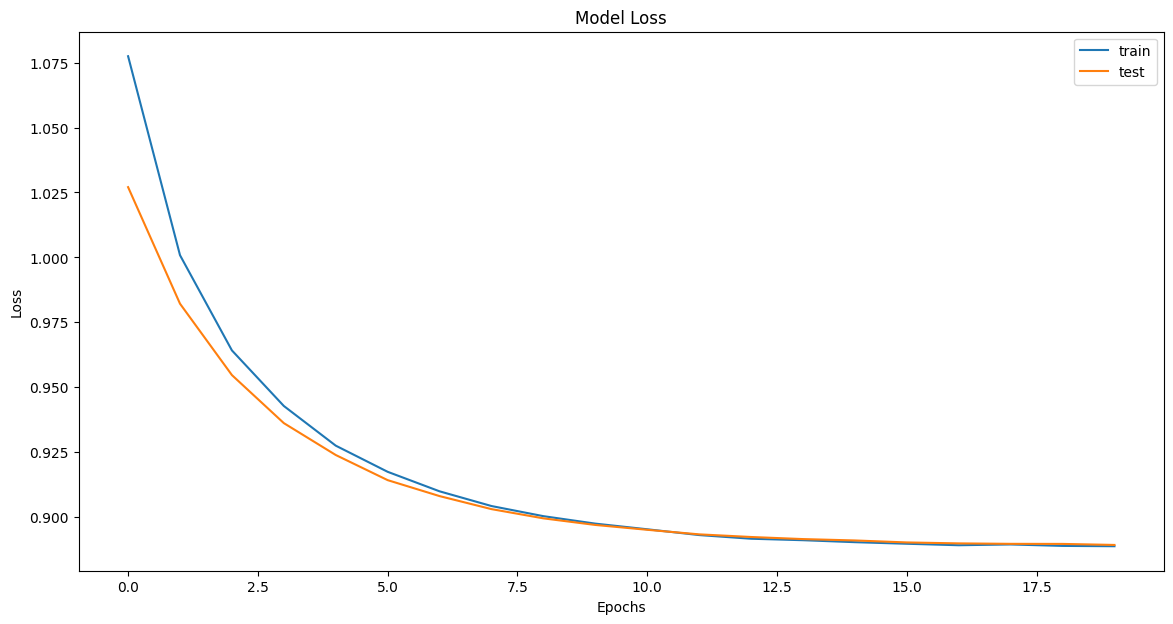

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 45.42%


For threshold set to 0.40, correctness is: 45.42%
For threshold set to 0.45, correctness is: 45.42%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4800 - loss: 1.0294 - val_accuracy: 0.4563 - val_loss: 0.9378
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4808 - loss: 0.9396 - val_accuracy: 0.4790 - val_loss: 0.9210
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4578 - loss: 0.9115 - val_accuracy: 0.4790 - val_loss: 0.9087
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4587 - loss: 0.9118 - val_accuracy: 0.4800 - val_loss: 0.9025
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

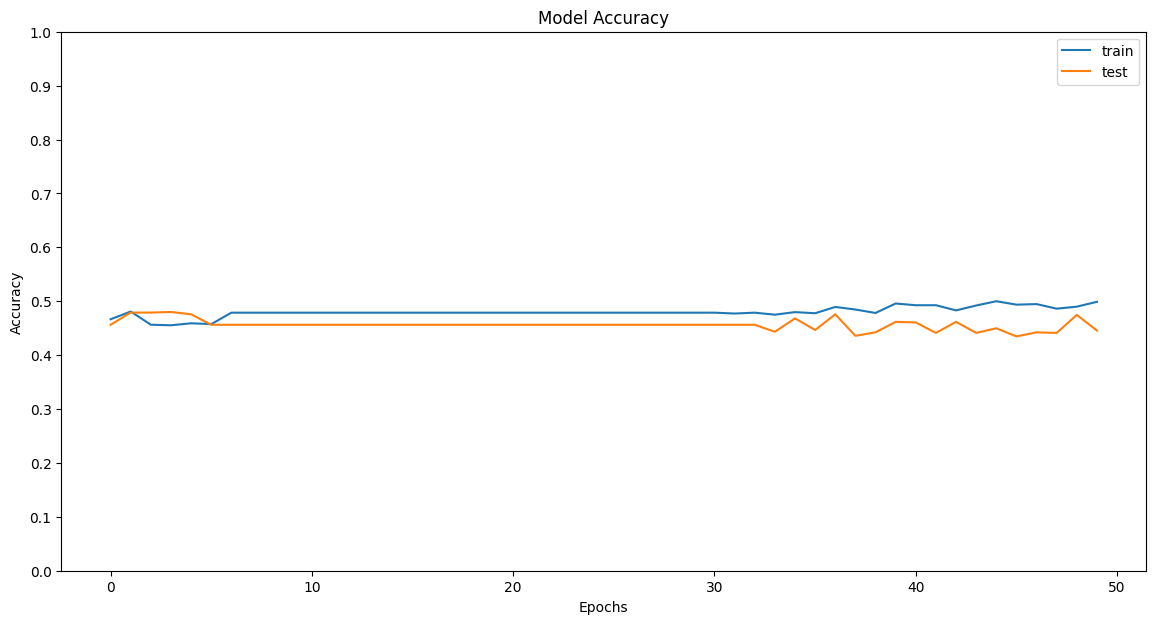

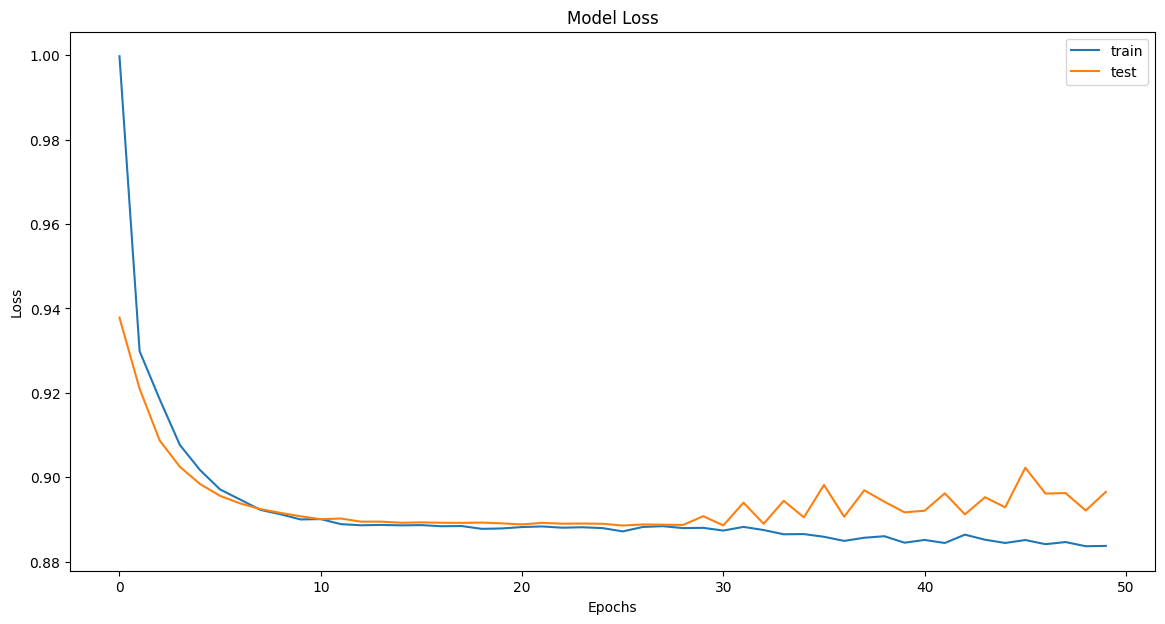

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.55%


For threshold set to 0.40, correctness is: 44.55%
For threshold set to 0.45, correctness is: 44.55%
For threshold set to 0.50, correctness is: 42.75%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



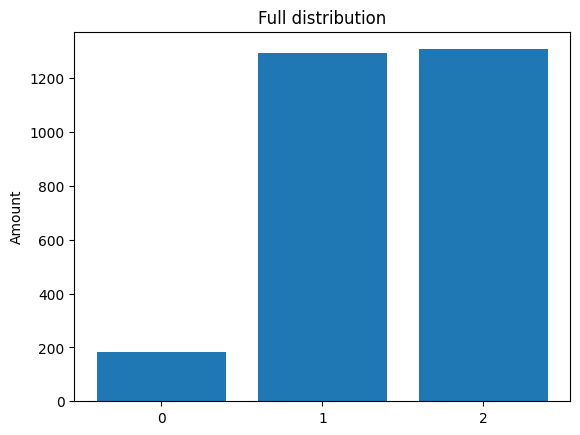

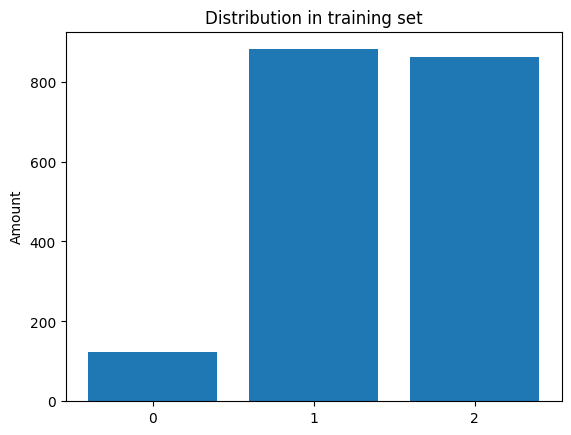

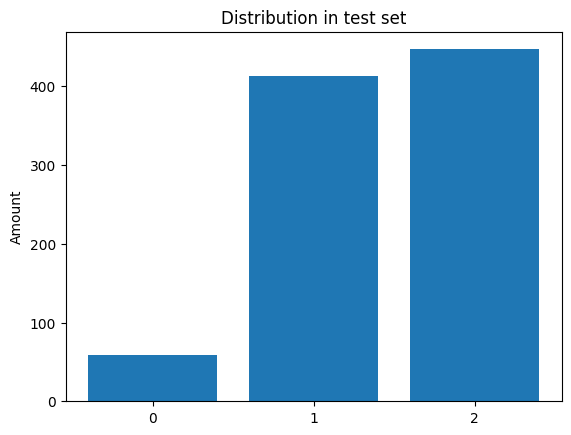

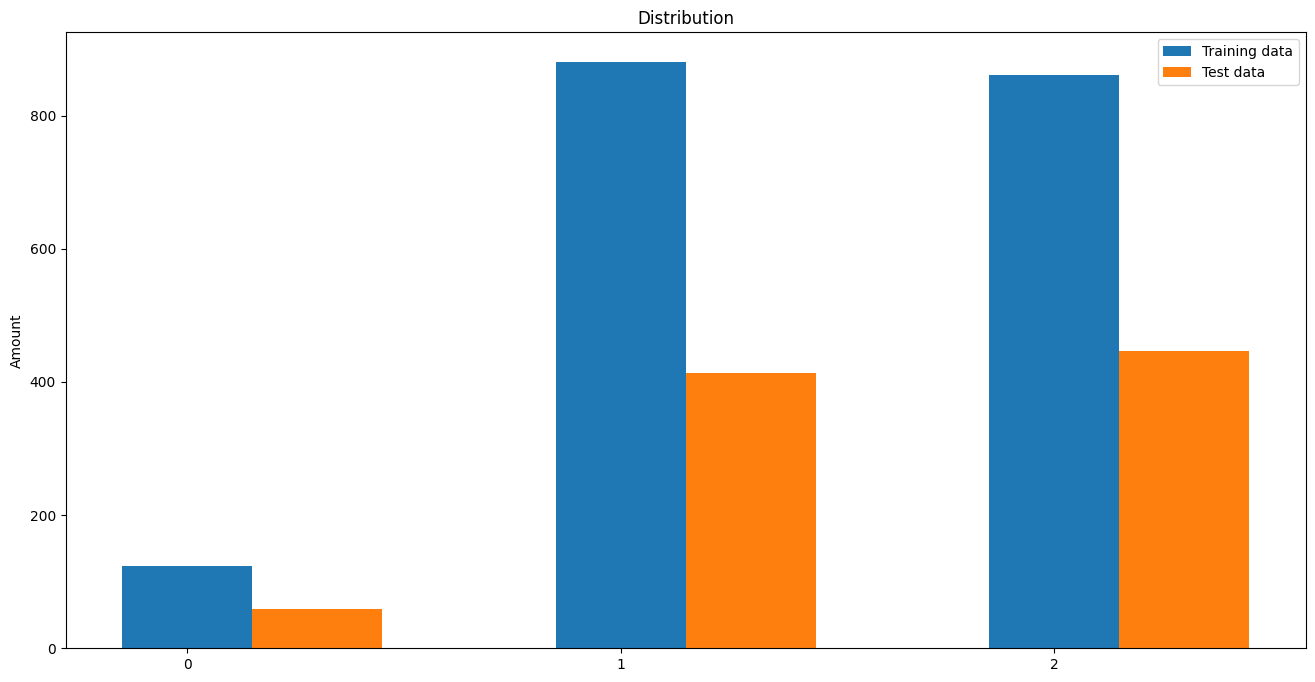


Example sequence from training set: [2 2 2 2 0 1 1 2 2 1] and its label: 2

Example sequence from test set: [1 0 2 2 2 0 1 2 2 2] and its label: 2


Gaussian Naive Bayes accuracy: 47.33%
Random forest classifier accuracy: 44.50%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4992 - loss: 1.0011 - val_accuracy: 0.4864 - val_loss: 0.9487
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4596 - loss: 0.9424 - val_accuracy: 0.4864 - val_loss: 0.9309
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4738 - loss: 0.9231 - val_accuracy: 0.4864 - val_loss: 0.9185
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4561 - loss: 0.9228 - val_accuracy: 0.4864 - val_loss: 0.9101
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4660 - loss: 0.9165 - val_accuracy: 0.4864 - val_loss: 0.9037
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4610 - loss: 0.9079 - val_accuracy: 0.4494 - val_loss: 0.8992
Epoch 7/10


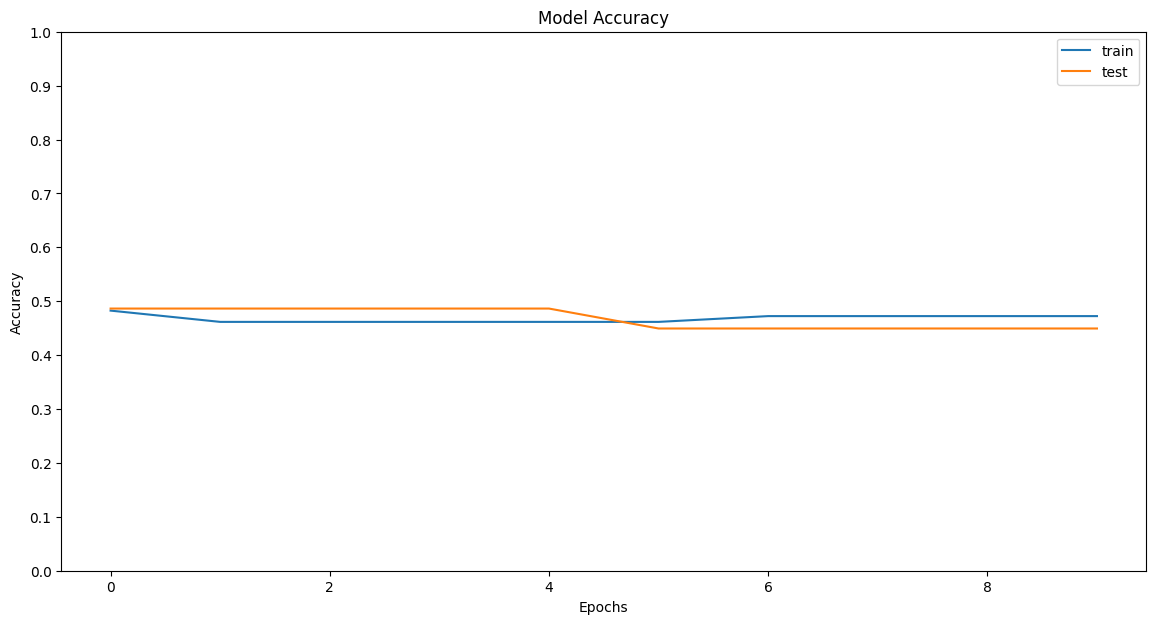

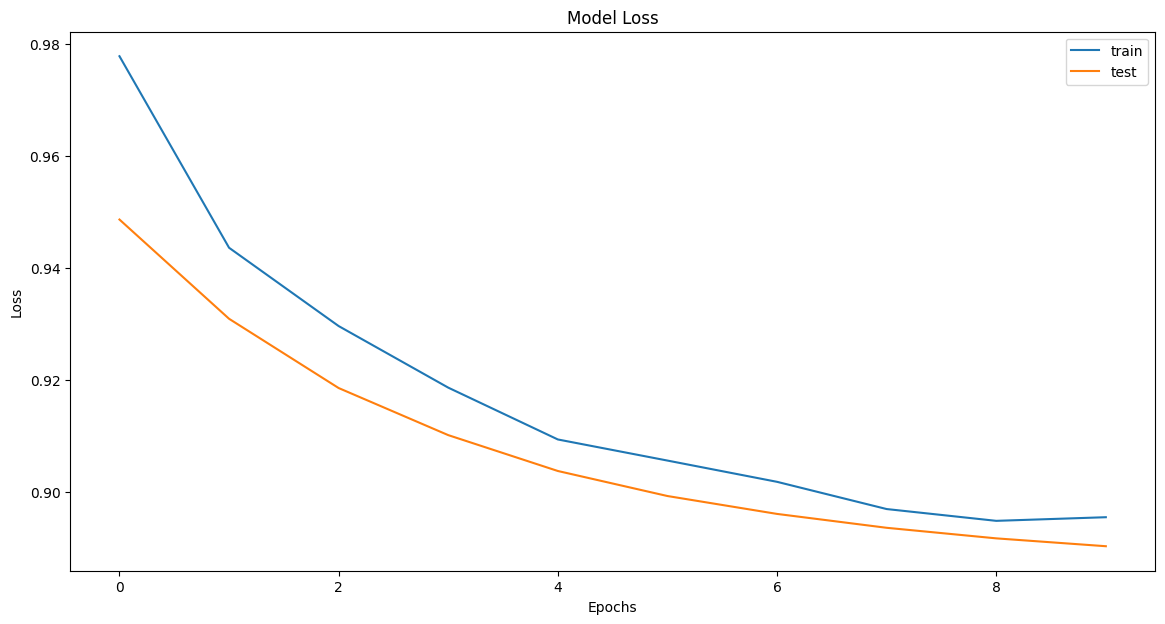

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Modal accuracy on test set: 44.94%


For threshold set to 0.40, correctness is: 44.94%
For threshold set to 0.45, correctness is: 44.94%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4861 - loss: 0.9928 - val_accuracy: 0.4494 - val_loss: 0.9359
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4723 - loss: 0.9235 - val_accuracy: 0.4494 - val_loss: 0.9187
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4770 - loss: 0.9201 - val_accuracy: 0.4494 - val_loss: 0.9080
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4857 - loss: 0.9102 - val_accuracy: 0.4494 - val_loss: 0.9012
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

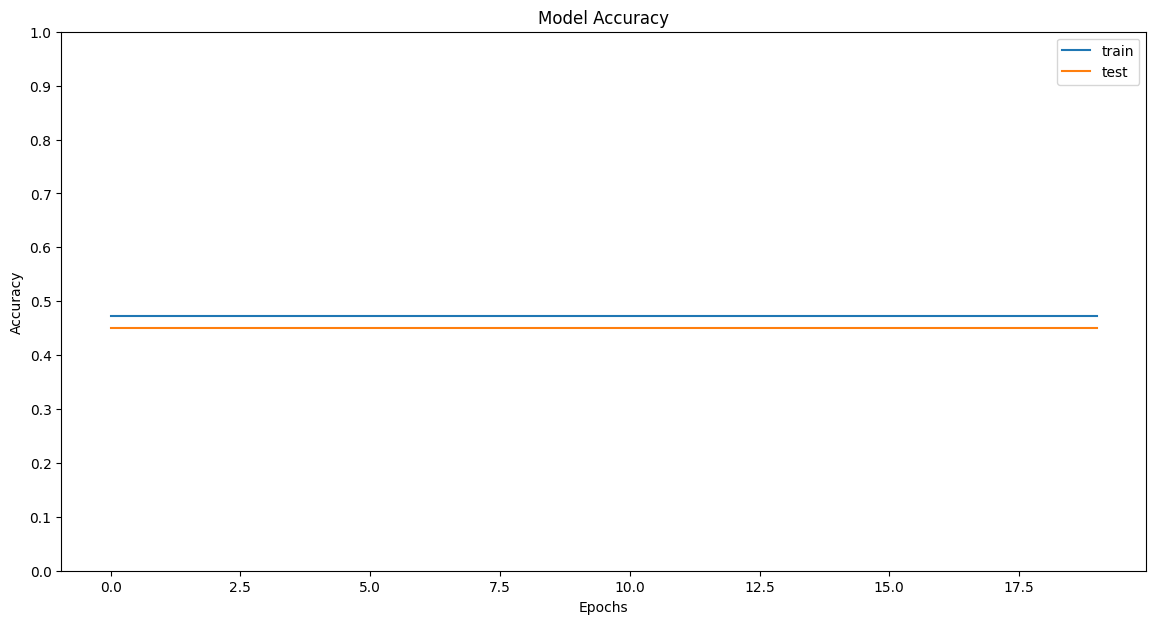

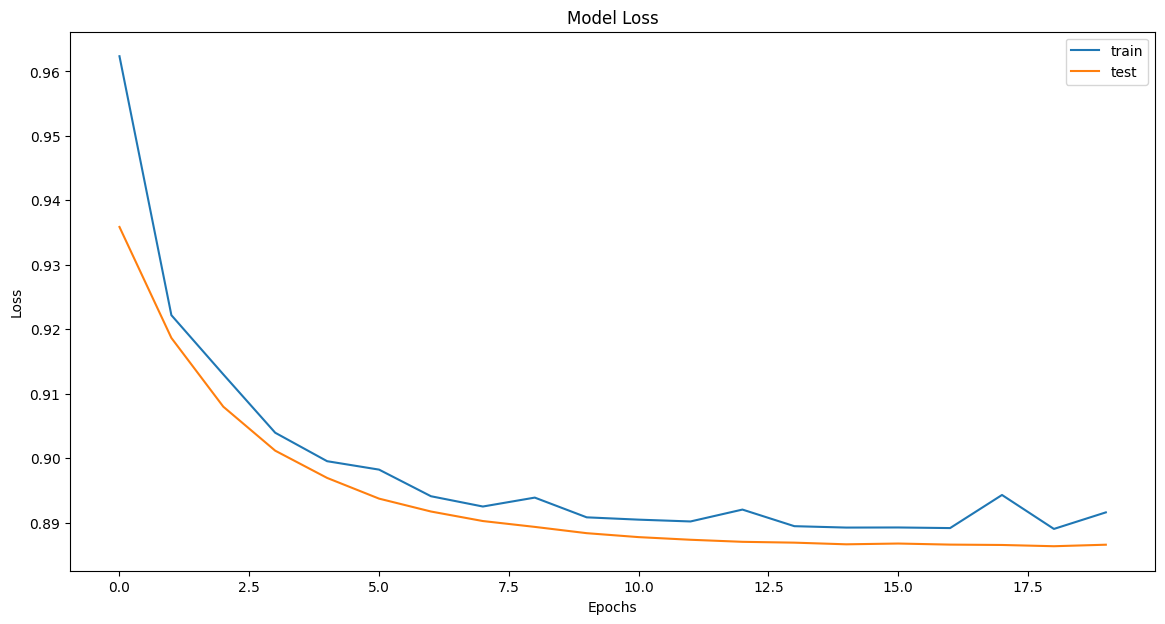

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 44.94%


For threshold set to 0.40, correctness is: 44.94%
For threshold set to 0.45, correctness is: 44.94%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4831 - loss: 1.0302 - val_accuracy: 0.4494 - val_loss: 0.9922
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4763 - loss: 0.9762 - val_accuracy: 0.4494 - val_loss: 0.9559
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4628 - loss: 0.9445 - val_accuracy: 0.4494 - val_loss: 0.9305
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4797 - loss: 0.9139 - val_accuracy: 0.4864 - val_loss: 0.9103
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

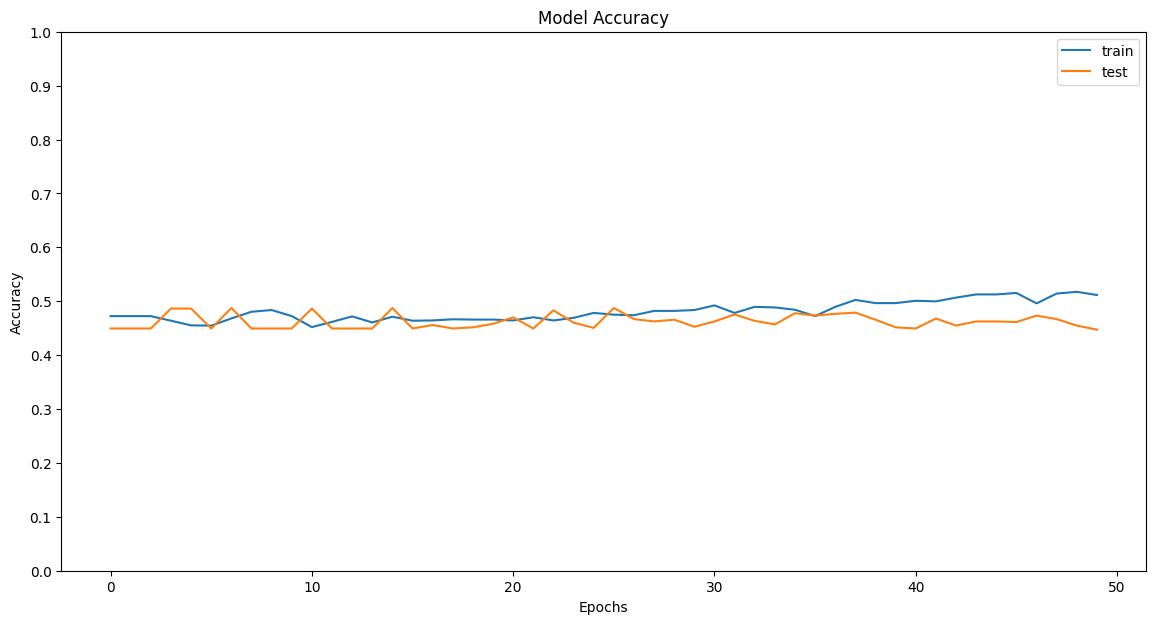

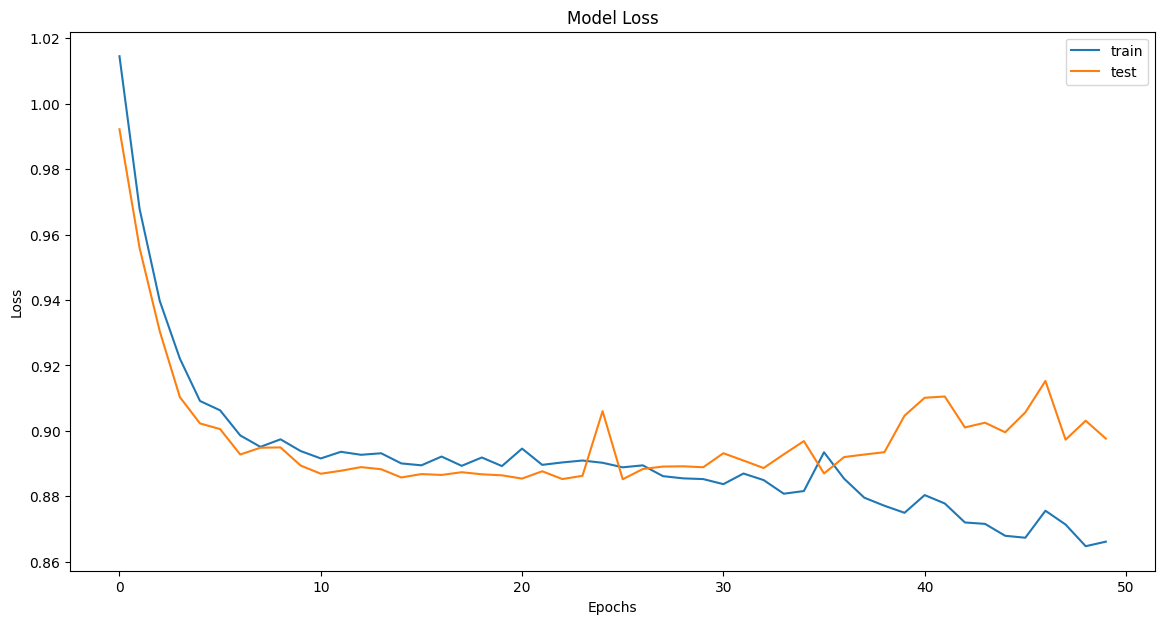

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 44.72%


For threshold set to 0.40, correctness is: 44.72%
For threshold set to 0.45, correctness is: 44.72%
For threshold set to 0.50, correctness is: 46.04%
For threshold set to 0.55, correctness is: 52.24%
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



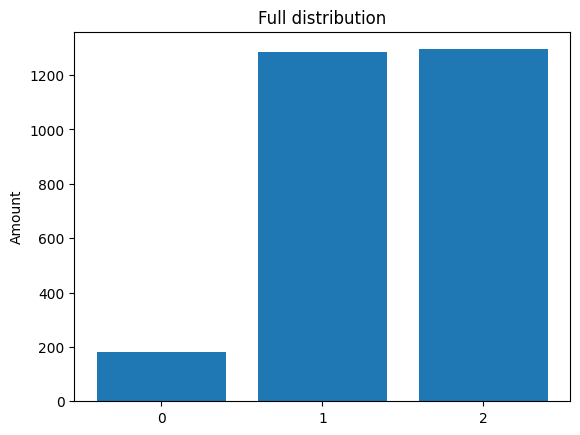

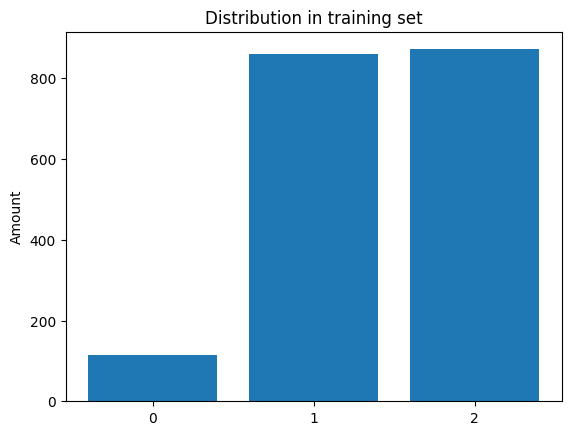

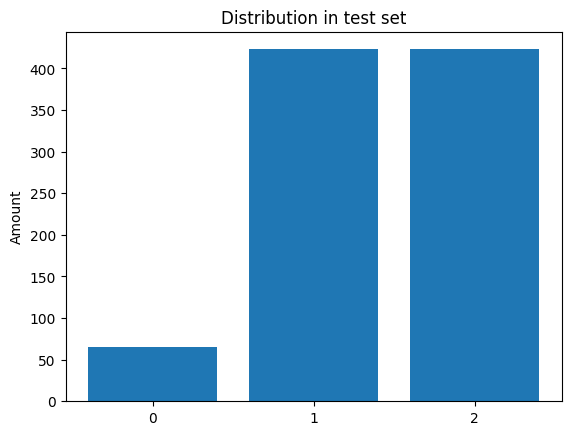

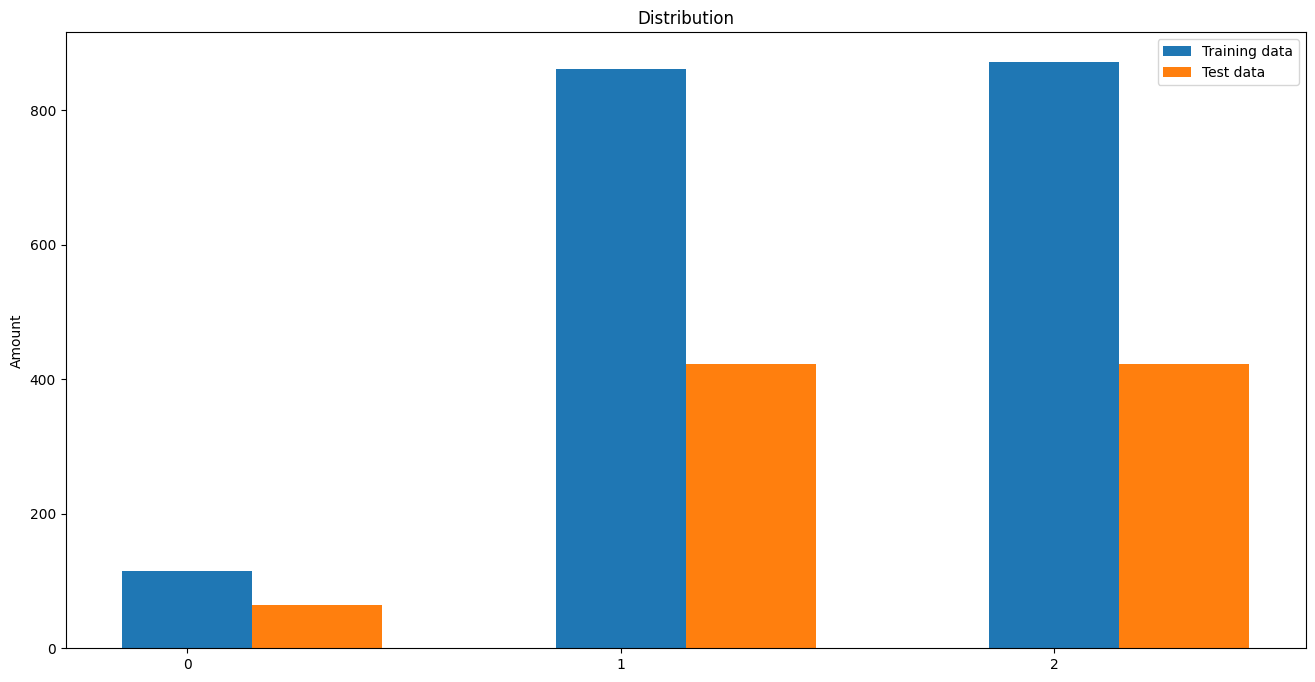


Example sequence from training set: [2 2 1 1 2 2 1 0 2 1 2 2 2 2 2] and its label: 1

Example sequence from test set: [2 0 1 2 2 2 1 1 1 1 1 1 2 1 1] and its label: 2


Gaussian Naive Bayes accuracy: 44.68%
Random forest classifier accuracy: 45.44%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4819 - loss: 1.1032 - val_accuracy: 0.4643 - val_loss: 1.0487
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4526 - loss: 1.0440 - val_accuracy: 0.4643 - val_loss: 1.0099
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4794 - loss: 0.9832 - val_accuracy: 0.4643 - val_loss: 0.9713
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4711 - loss: 0.9518 - val_accuracy: 0.4632 - val_loss: 0.9380
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4635 - loss: 0.9300 - val_accuracy: 0.4643 - val_loss: 0.9241
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4699 - loss: 0.9043 - val_accuracy: 0.4643 - val_loss

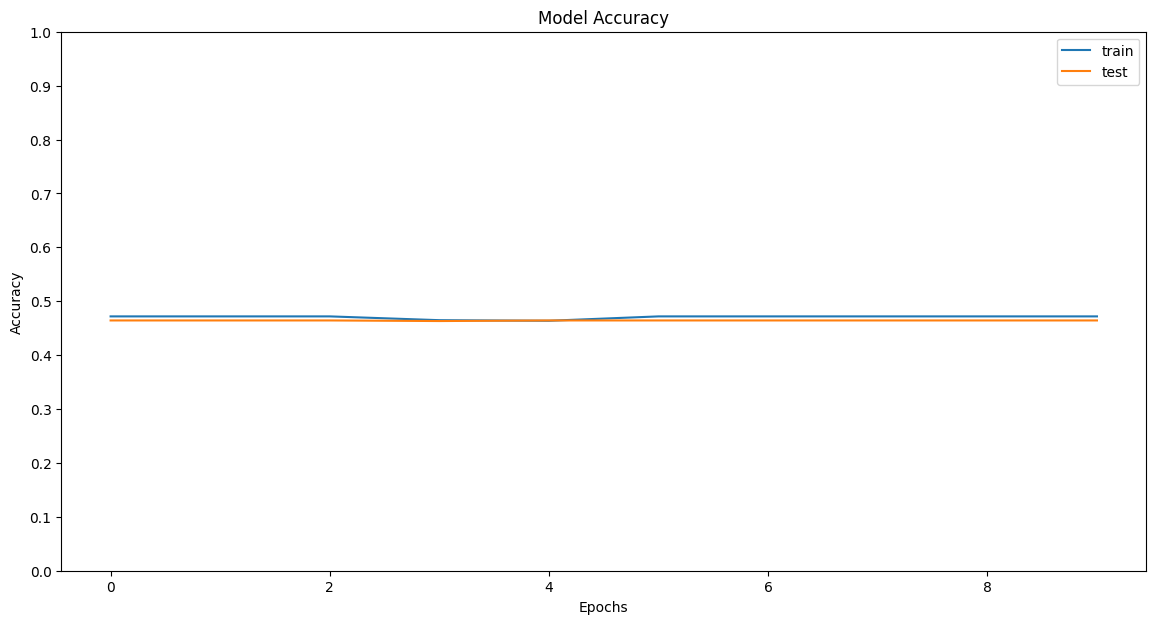

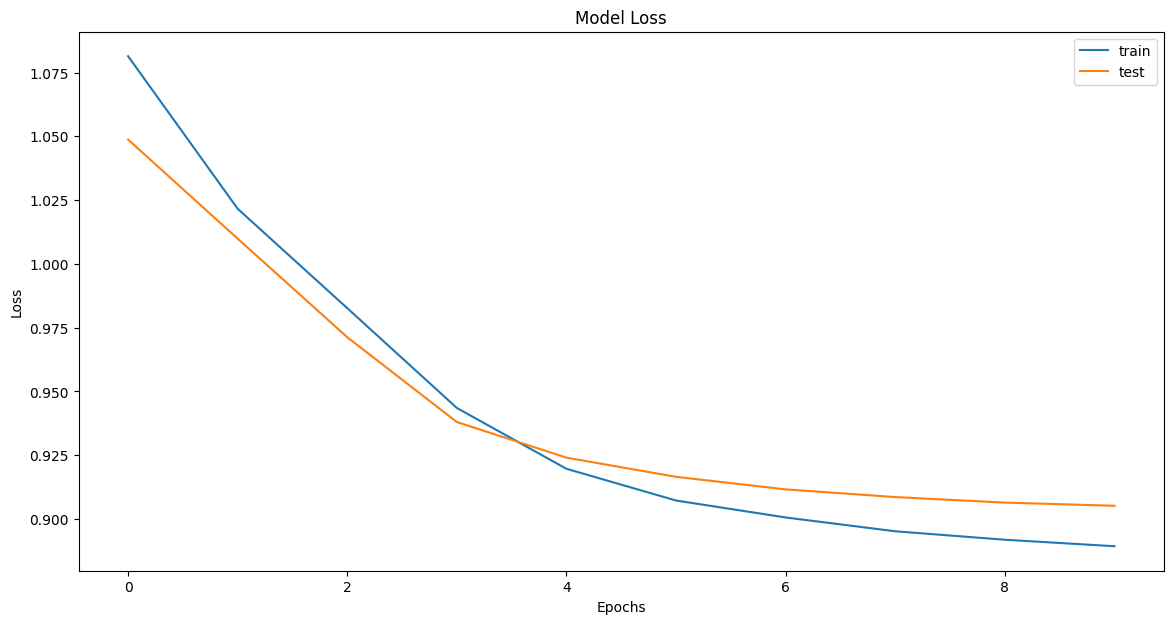

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 46.43%


For threshold set to 0.40, correctness is: 46.43%
For threshold set to 0.45, correctness is: 46.43%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4617 - loss: 1.0521 - val_accuracy: 0.4643 - val_loss: 0.9968
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4712 - loss: 0.9838 - val_accuracy: 0.4643 - val_loss: 0.9676
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4703 - loss: 0.9519 - val_accuracy: 0.4643 - val_loss: 0.9489
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4435 - loss: 0.9384 - val_accuracy: 0.4643 - val_loss: 0.9358
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

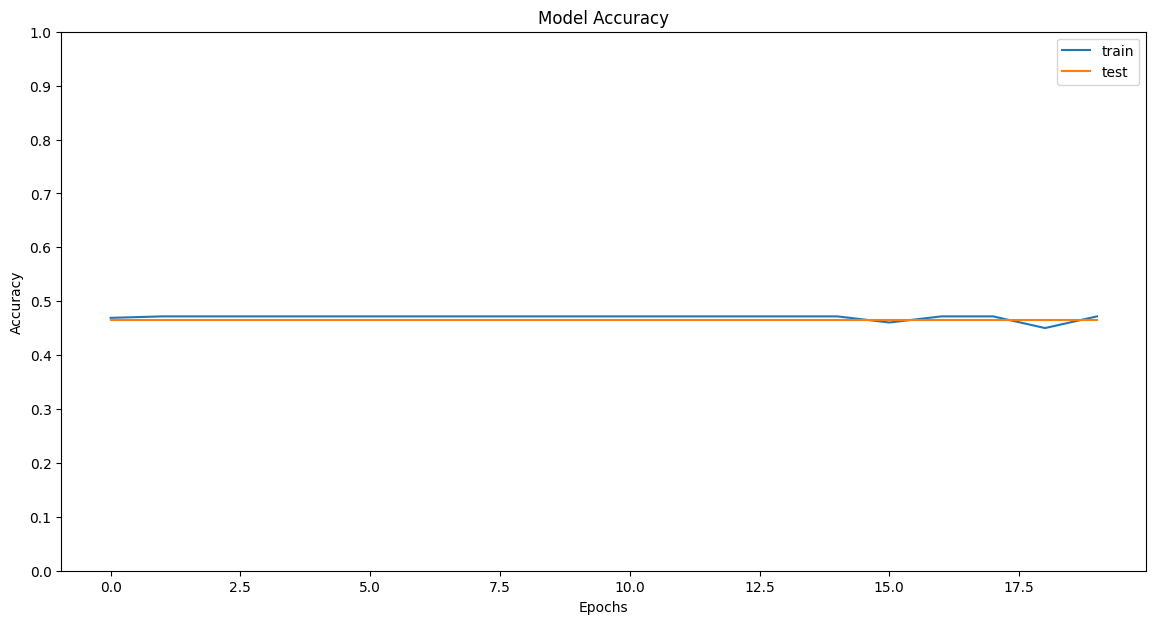

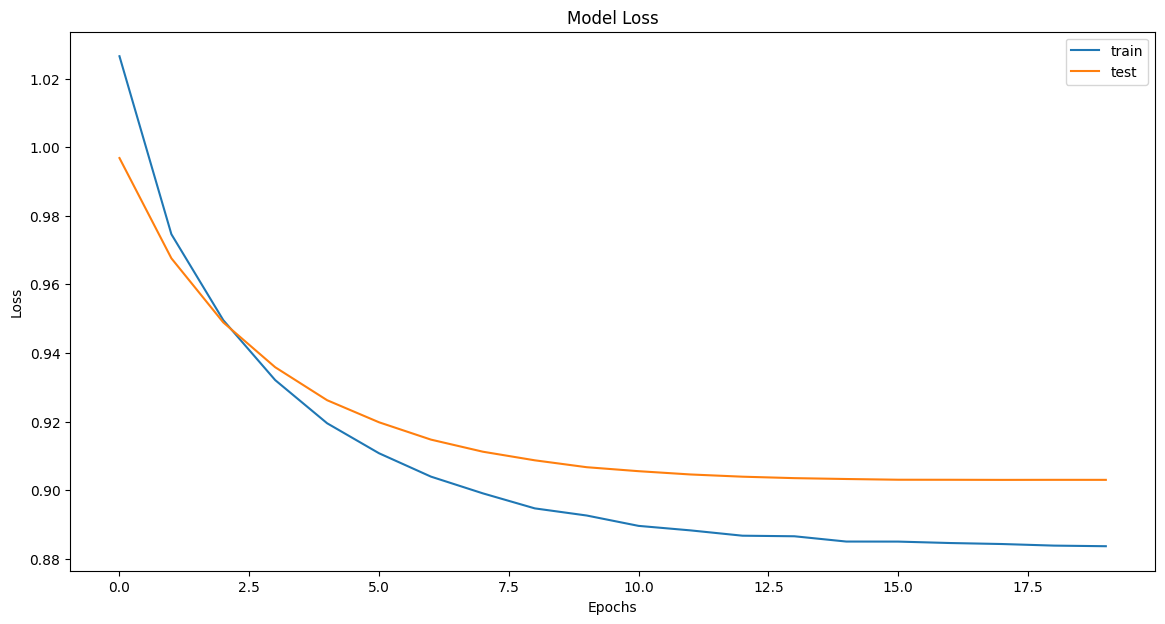

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 46.43%


For threshold set to 0.40, correctness is: 46.43%
For threshold set to 0.45, correctness is: 46.43%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4059 - loss: 1.0798 - val_accuracy: 0.4643 - val_loss: 1.0088
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4601 - loss: 0.9971 - val_accuracy: 0.4643 - val_loss: 0.9796
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4658 - loss: 0.9683 - val_accuracy: 0.4643 - val_loss: 0.9583
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 0.9466 - val_accuracy: 0.4643 - val_loss: 0.9435
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

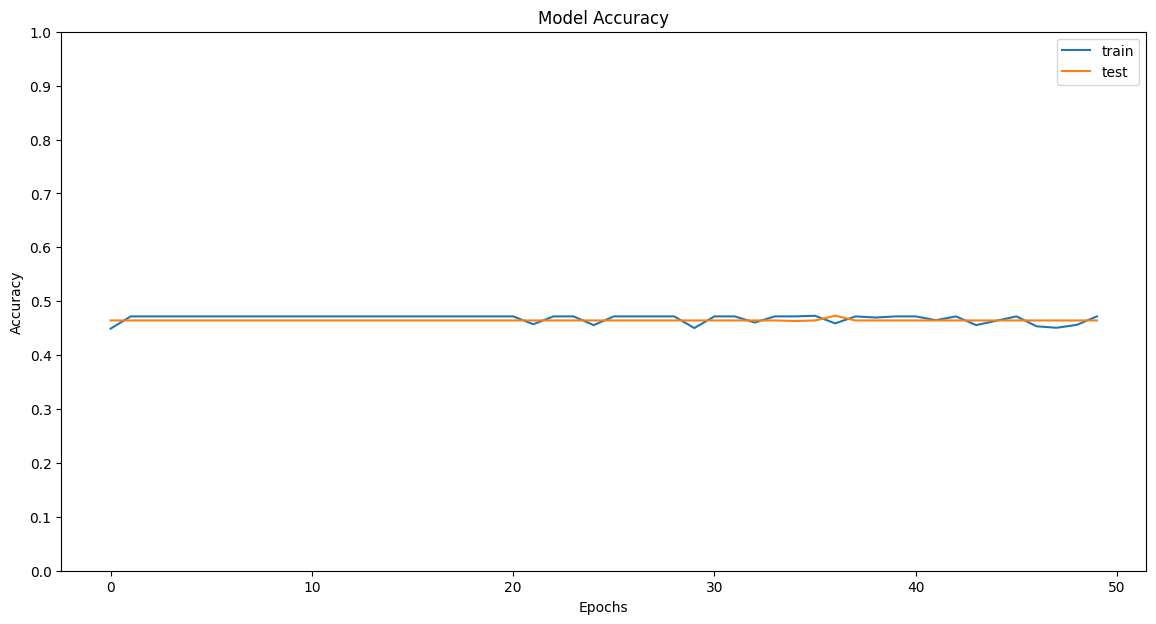

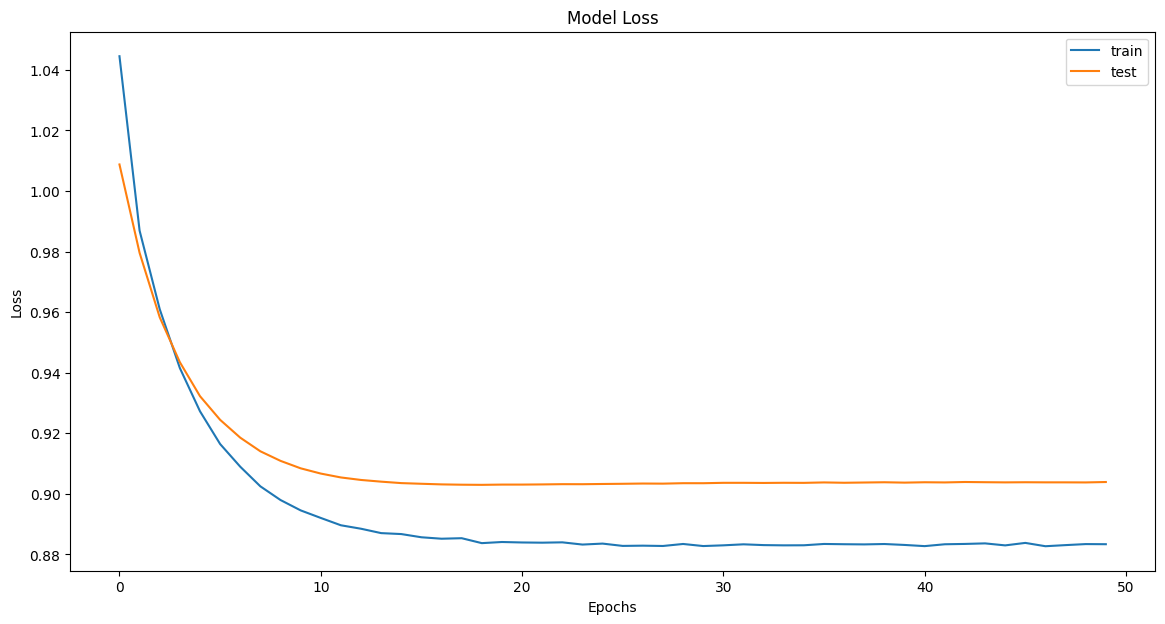

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 46.43%


For threshold set to 0.40, correctness is: 46.43%
For threshold set to 0.45, correctness is: 46.43%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



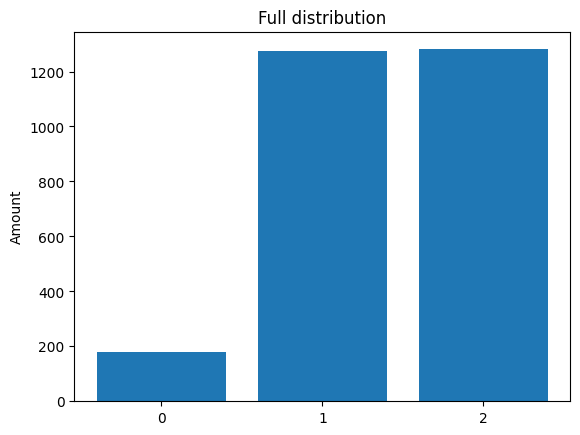

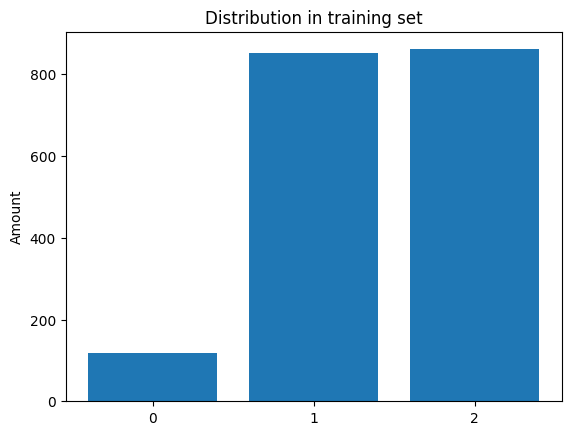

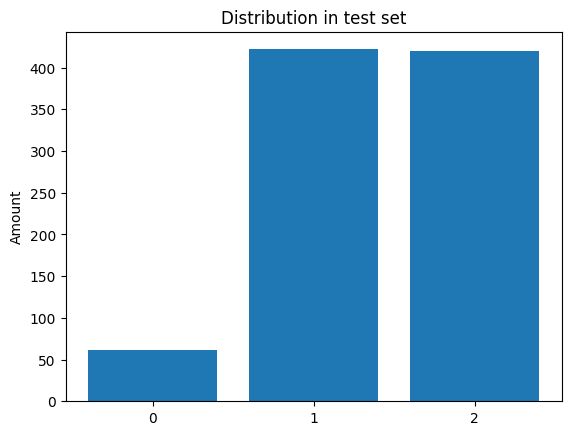

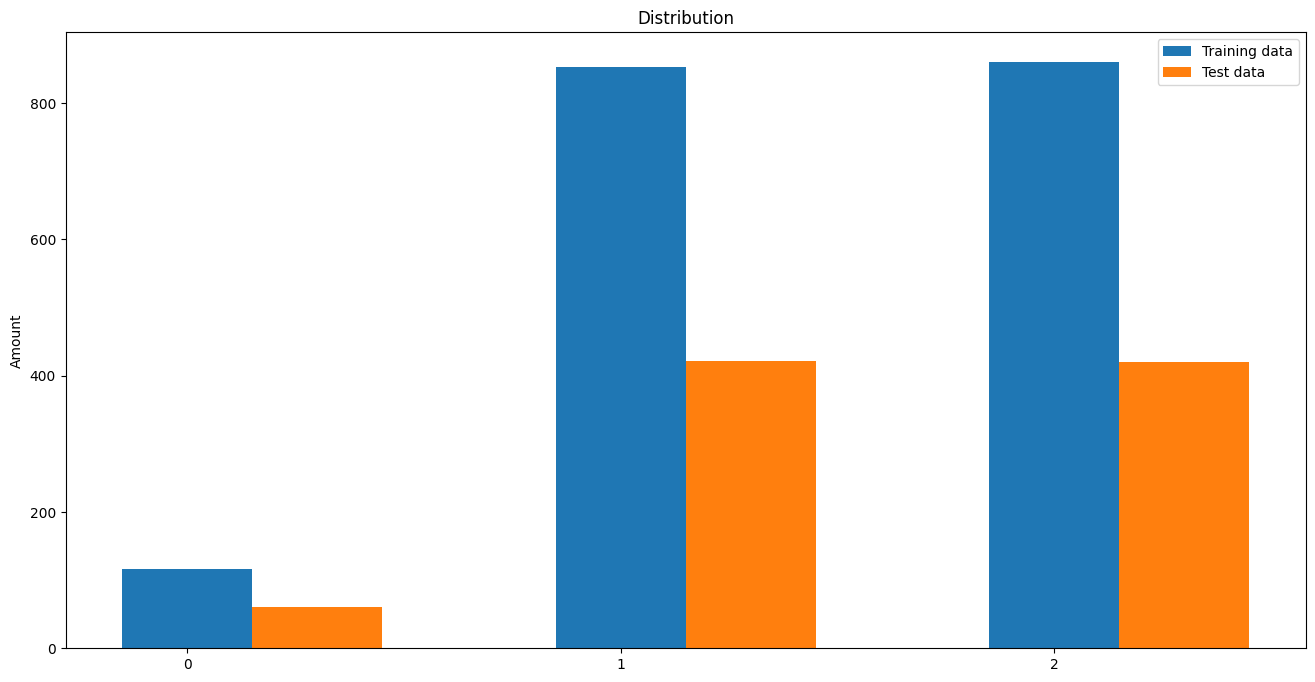


Example sequence from training set: [2 1 1 1 2 2 2 1 2 1 1 2 1 2 1 1 1 1 2 2] and its label: 1

Example sequence from test set: [1 1 1 0 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 1] and its label: 2


Gaussian Naive Bayes accuracy: 44.30%
Random forest classifier accuracy: 43.08%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.3795 - loss: 1.0909 - val_accuracy: 0.4651 - val_loss: 1.0245
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4496 - loss: 1.0244 - val_accuracy: 0.4651 - val_loss: 0.9874
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4669 - loss: 0.9776 - val_accuracy: 0.4651 - val_loss: 0.9606
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4825 - loss: 0.9476 - val_accuracy: 0.4651 - val_loss: 0.9410
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4697 - loss: 0.9300 - val_accuracy: 0.4651 - val_loss: 0.9269
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4668 - loss: 0.9285 - val_accurac

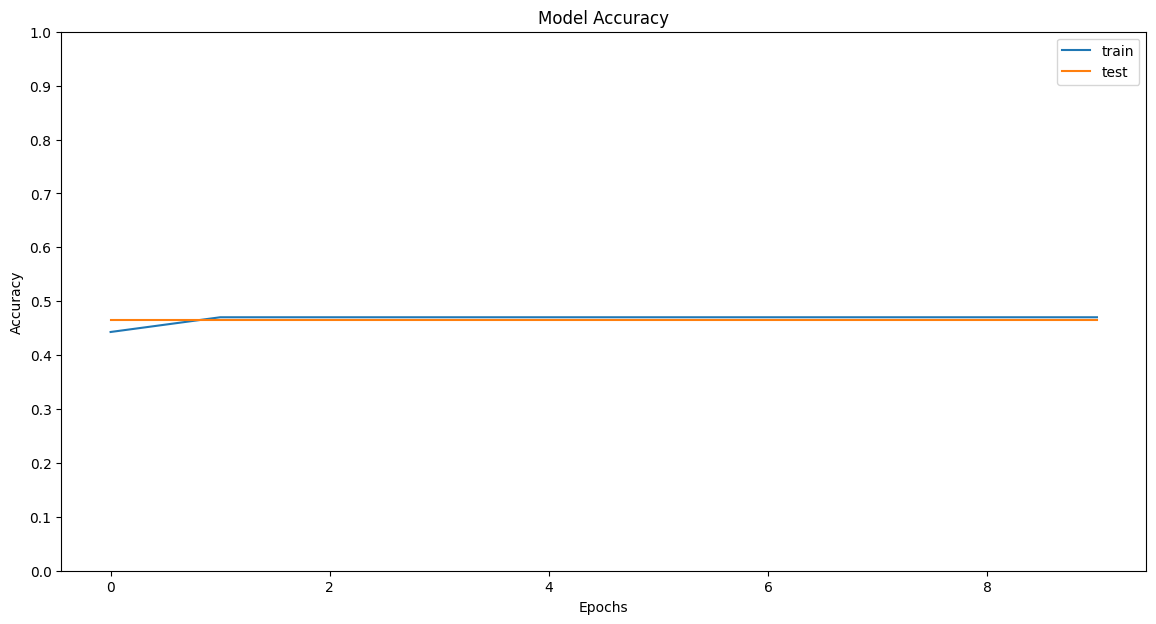

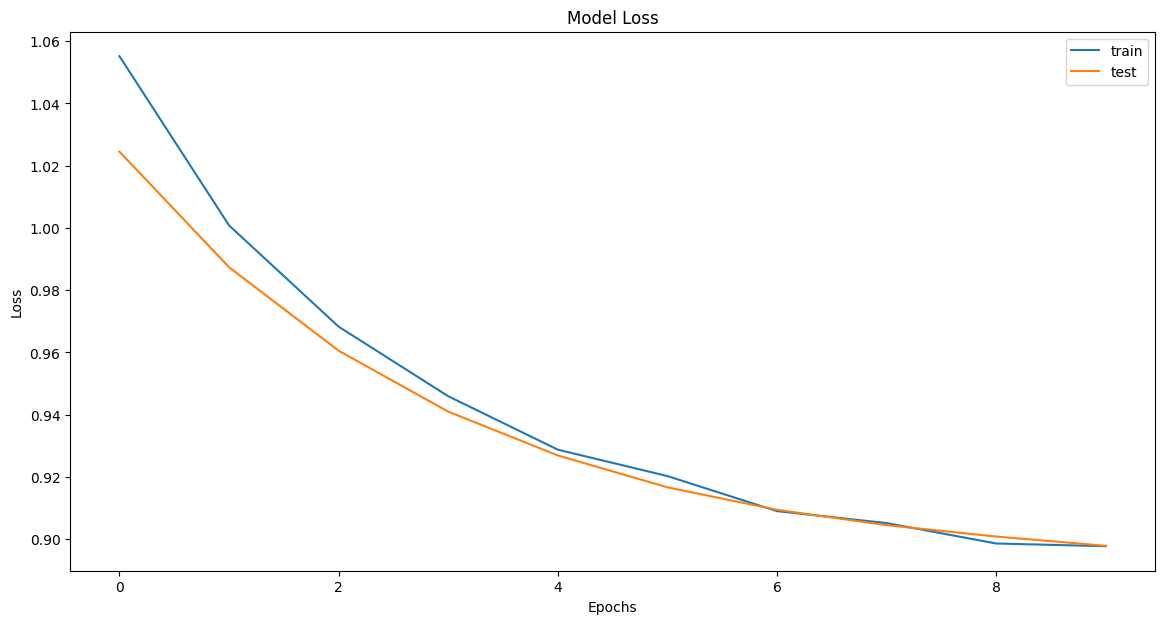

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 46.51%


For threshold set to 0.40, correctness is: 46.51%
For threshold set to 0.45, correctness is: 46.51%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4961 - loss: 1.0010 - val_accuracy: 0.4673 - val_loss: 0.9358
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4483 - loss: 0.9295 - val_accuracy: 0.4673 - val_loss: 0.9217
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4661 - loss: 0.9184 - val_accuracy: 0.4673 - val_loss: 0.9119
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4631 - loss: 0.9070 - val_accuracy: 0.4673 - val_loss: 0.9054
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

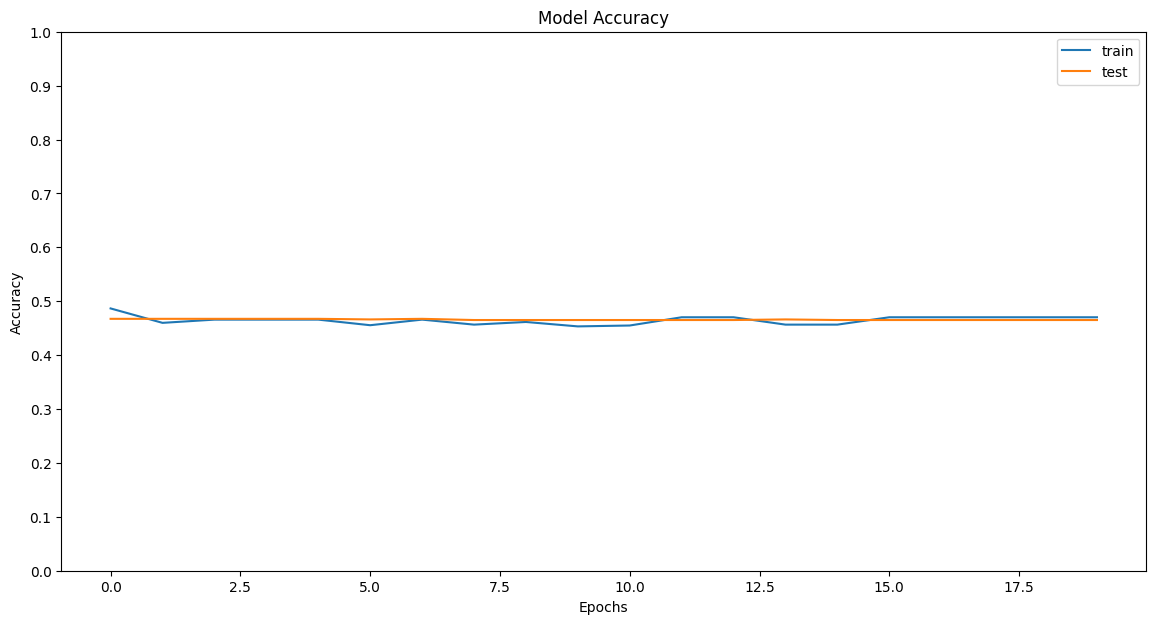

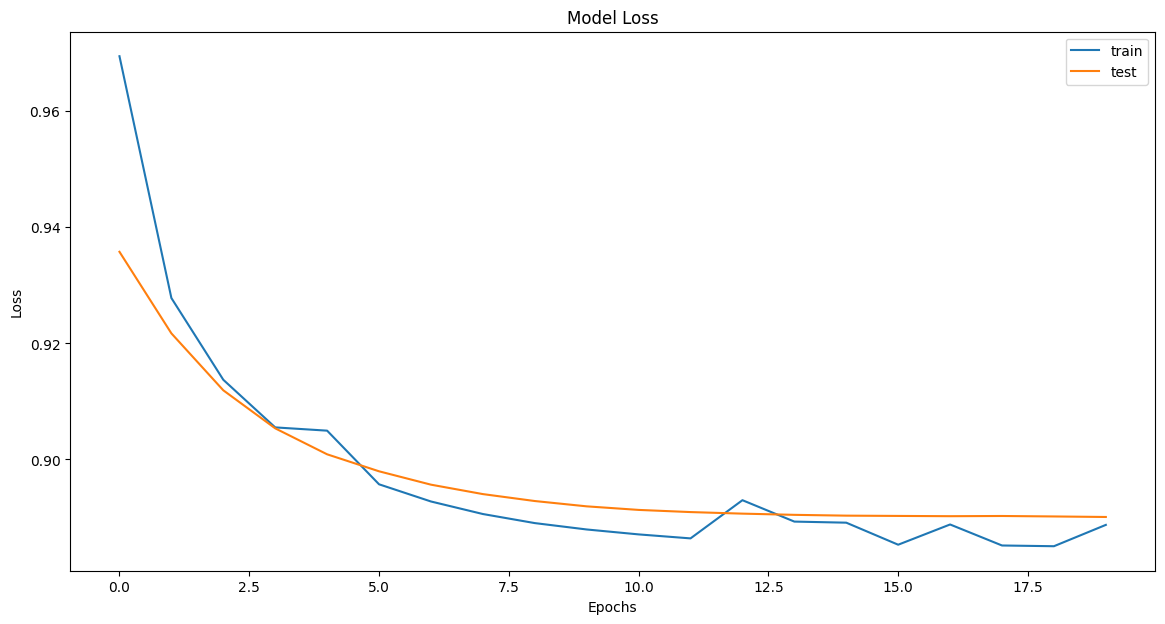

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 46.51%


For threshold set to 0.40, correctness is: 46.51%
For threshold set to 0.45, correctness is: 46.51%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2240 - loss: 1.0868 - val_accuracy: 0.4673 - val_loss: 0.9139
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4707 - loss: 0.9058 - val_accuracy: 0.4673 - val_loss: 0.9066
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4601 - loss: 0.9147 - val_accuracy: 0.4673 - val_loss: 0.9020
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4786 - loss: 0.9067 - val_accuracy: 0.4673 - val_loss: 0.8985
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

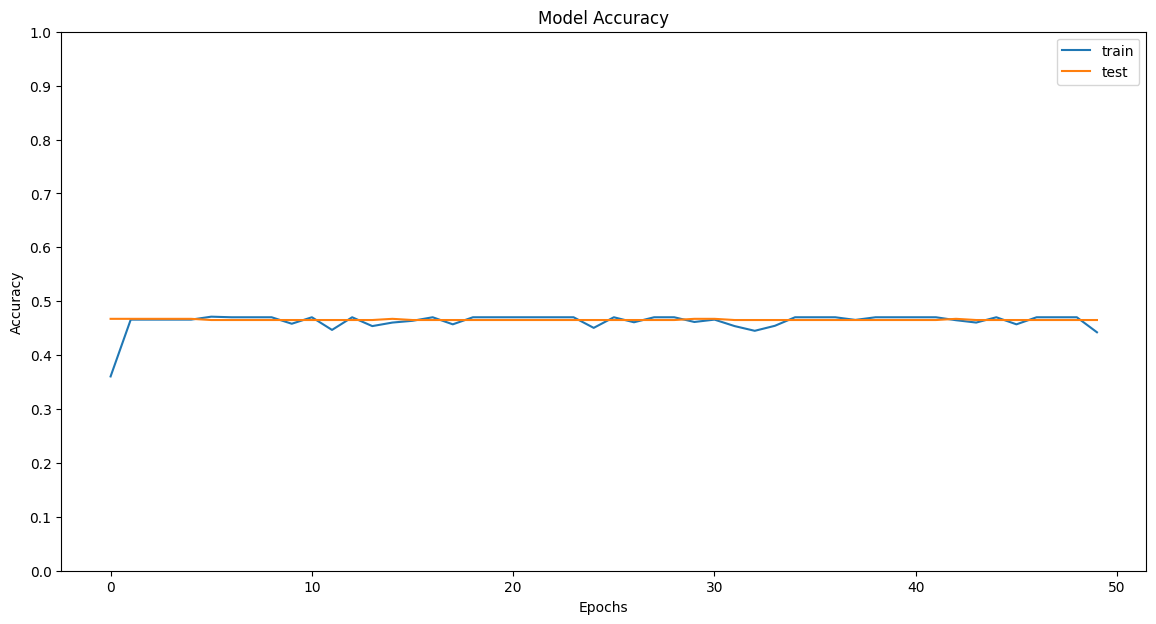

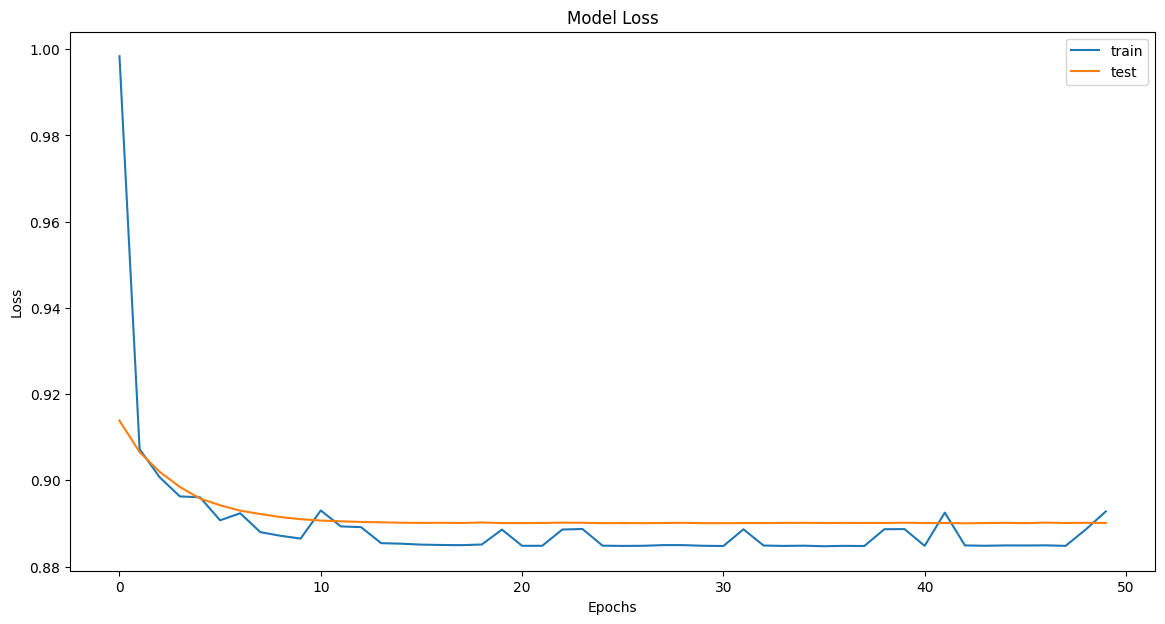

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 46.51%


For threshold set to 0.40, correctness is: 46.51%
For threshold set to 0.45, correctness is: 46.51%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



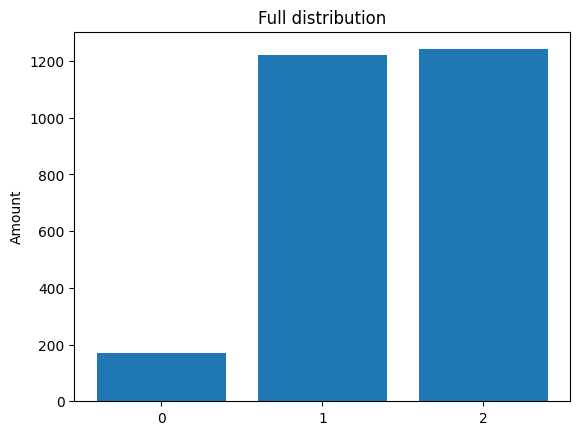

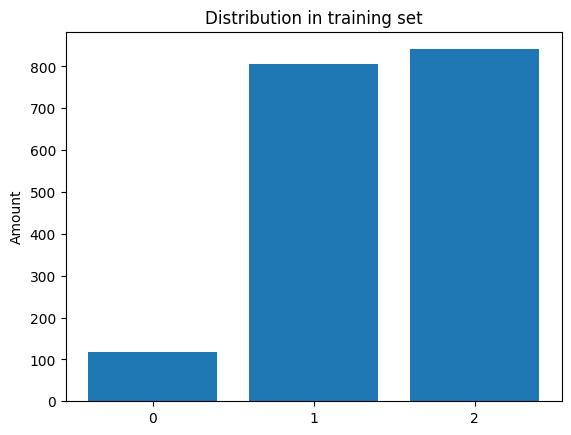

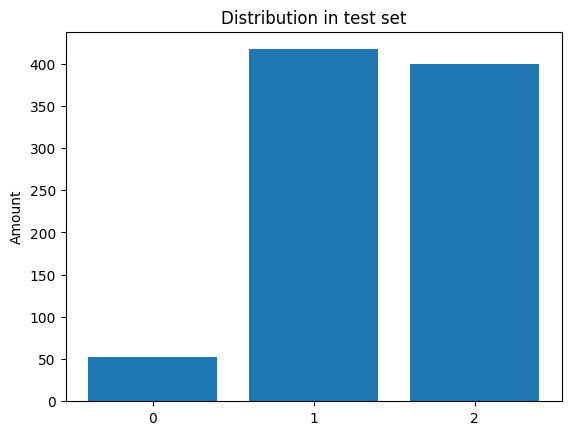

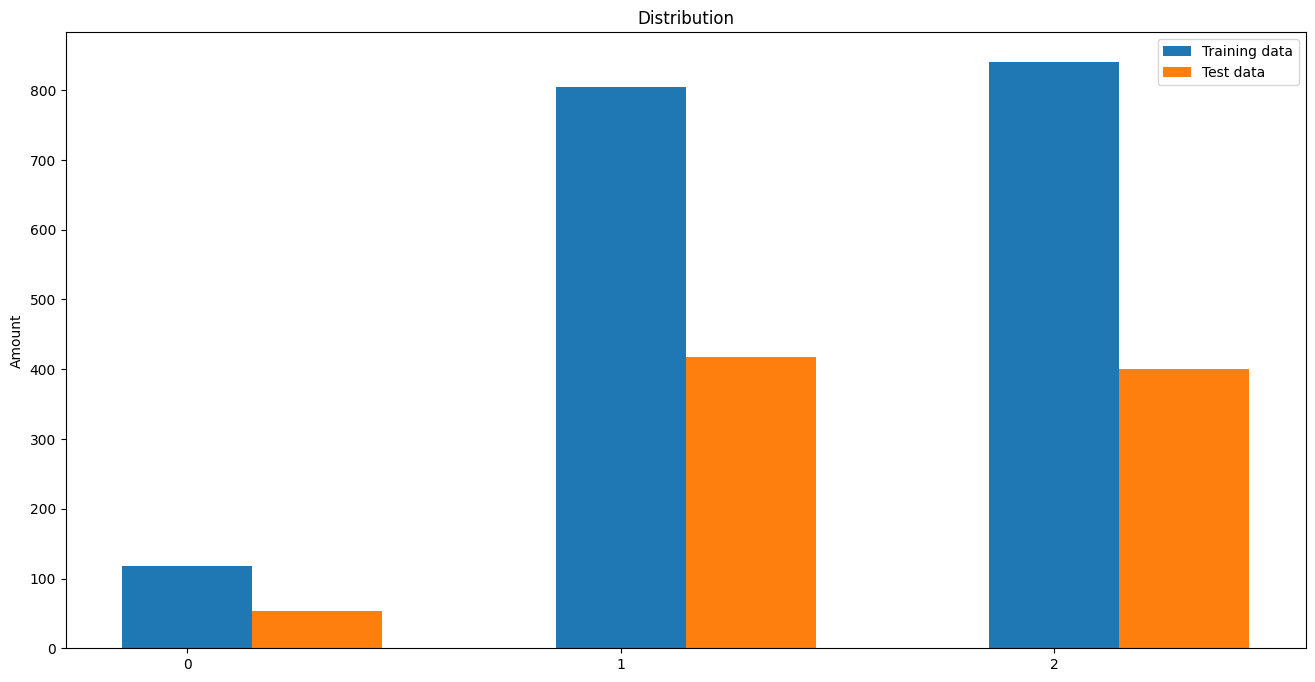


Example sequence from training set: [2 1 1 1 1 1 1 0 2 2 2 2 1 1 2 2 0 1 2 2 1 2 1 2 2 0 2 1 2 2 2 1 0 2 2 2 1
 1 1 2] and its label: 1

Example sequence from test set: [1 1 1 1 1 0 1 2 2 2 1 2 1 1 2 1 2 1 1 2 2 1 1 0 0 2 0 2 2 2 2 2 2 2 1 2 1
 2 1 2] and its label: 1


Gaussian Naive Bayes accuracy: 47.59%
Random forest classifier accuracy: 48.28%


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2177 - loss: 1.1150 - val_accuracy: 0.4598 - val_loss: 0.9782
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 0.9740 - val_accuracy: 0.4598 - val_loss: 0.9540
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4675 - loss: 0.9566 - val_accuracy: 0.4598 - val_loss: 0.9371
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4740 - loss: 0.9391 - val_accuracy: 0.4598 - val_loss: 0.9241
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4678 - loss: 0.9386 - val_accuracy: 0.4598 - val_loss: 0.9134
Epoch 6/10
56/5

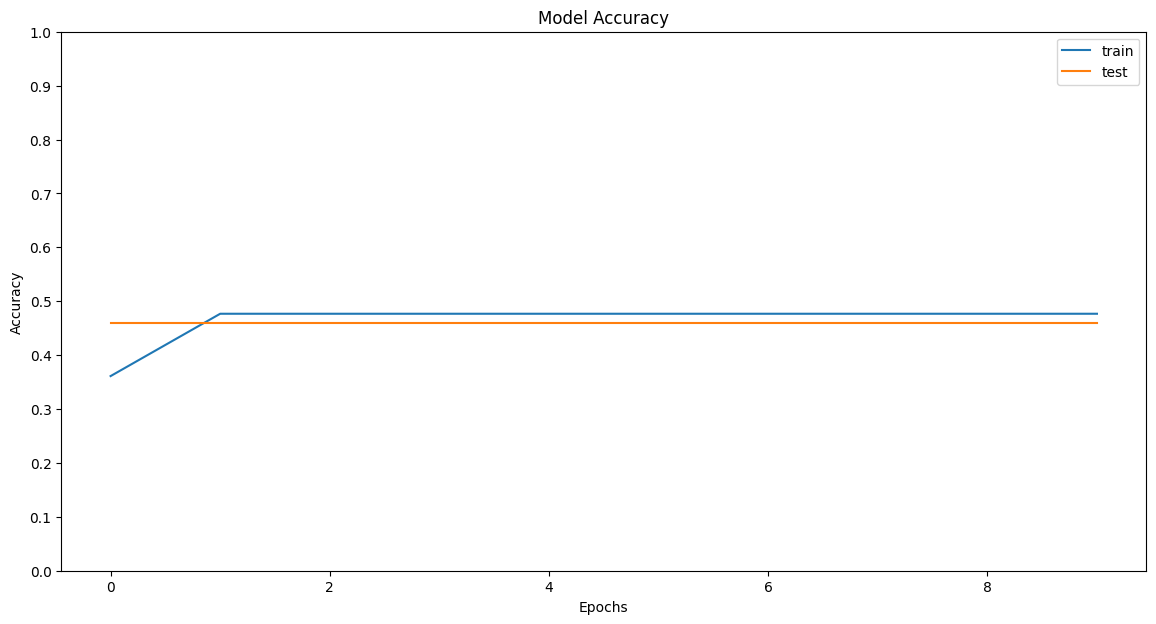

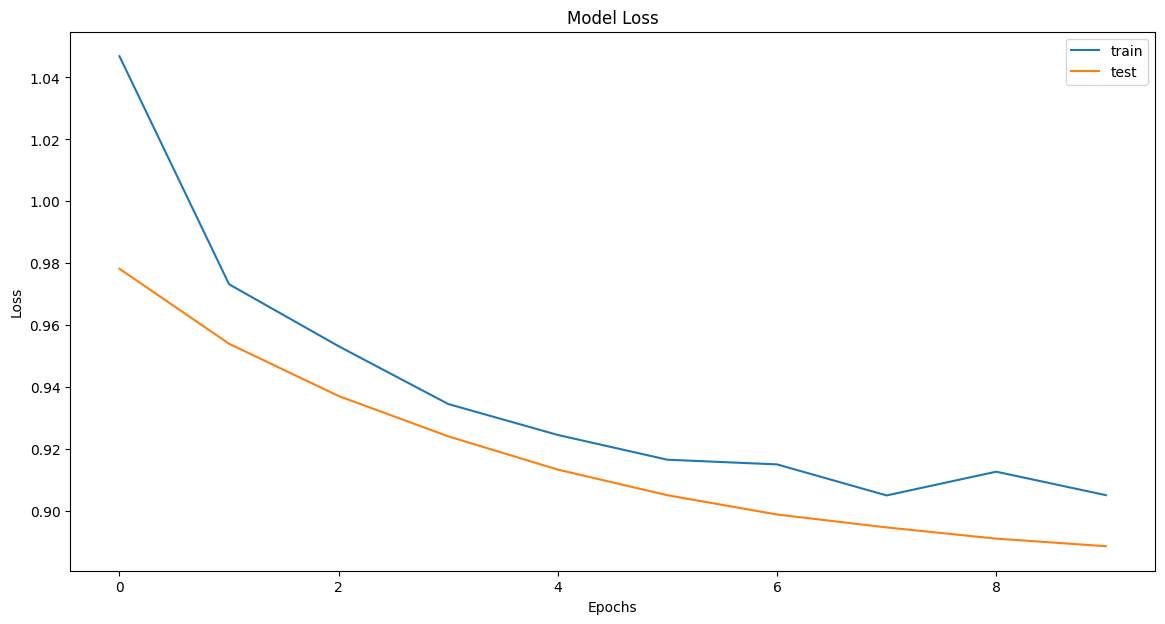

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Modal accuracy on test set: 45.98%


For threshold set to 0.40, correctness is: 45.98%
For threshold set to 0.45, correctness is: 45.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2237 - loss: 1.1153 - val_accuracy: 0.4598 - val_loss: 0.9750
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4776 - loss: 0.9682 - val_accuracy: 0.4598 - val_loss: 0.9507
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4629 - loss: 0.9551 - val_accuracy: 0.4598 - val_loss: 0.9331
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4893 - loss: 0.9410 - val_accuracy: 0.4598 - val_loss: 0.9202
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

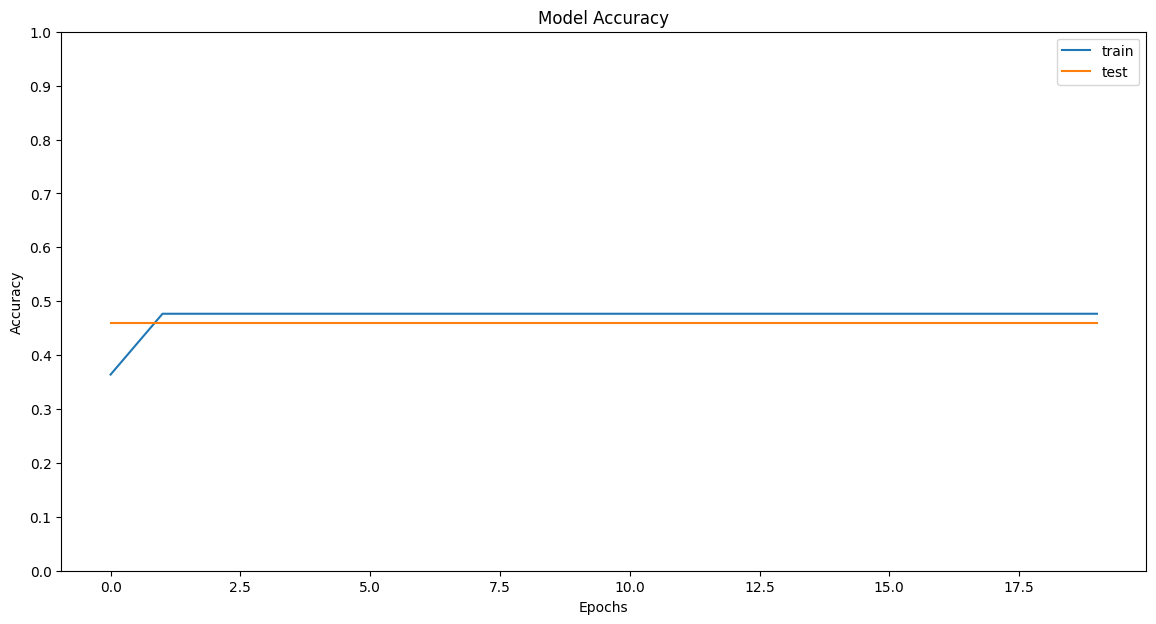

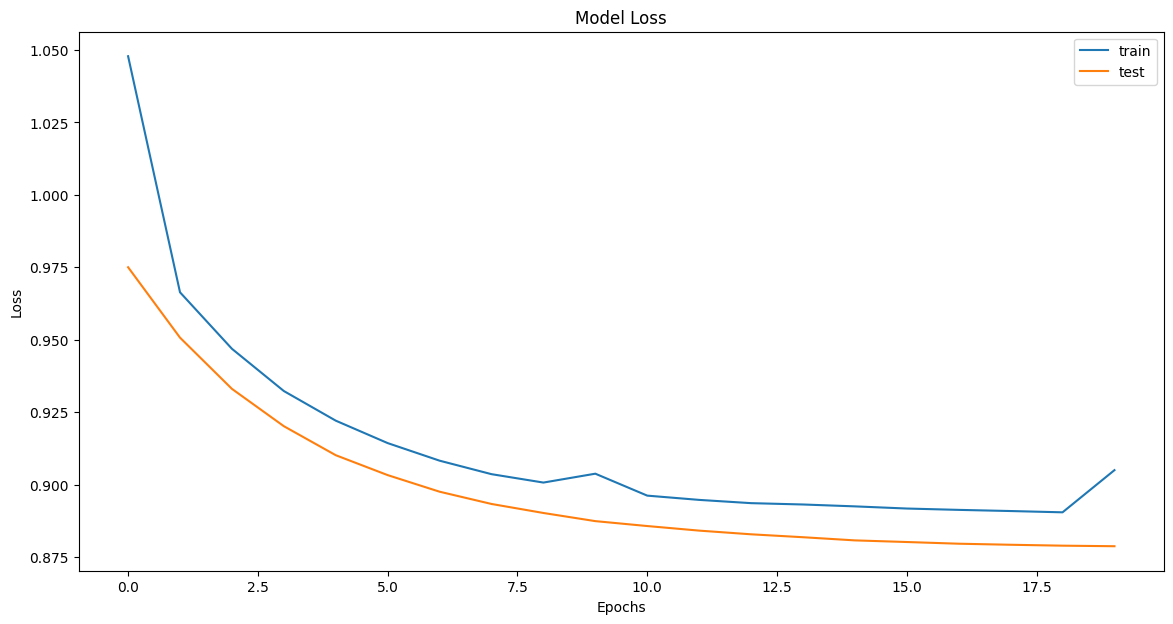

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
Modal accuracy on test set: 45.98%


For threshold set to 0.40, correctness is: 45.98%
For threshold set to 0.45, correctness is: 45.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4946 - loss: 1.0307 - val_accuracy: 0.4598 - val_loss: 0.9058
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4901 - loss: 0.9205 - val_accuracy: 0.4598 - val_loss: 0.8984
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4795 - loss: 0.9017 - val_accuracy: 0.4598 - val_loss: 0.8932
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4774 - loss: 0.9138 - val_accuracy: 0.4598 - val_loss: 0.8893
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

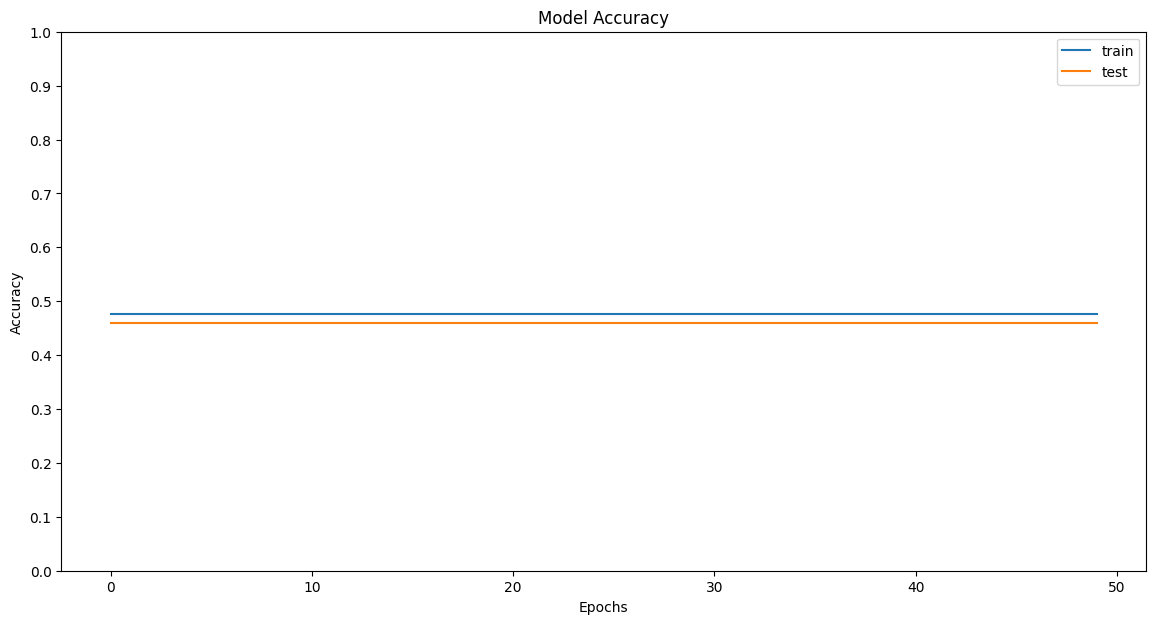

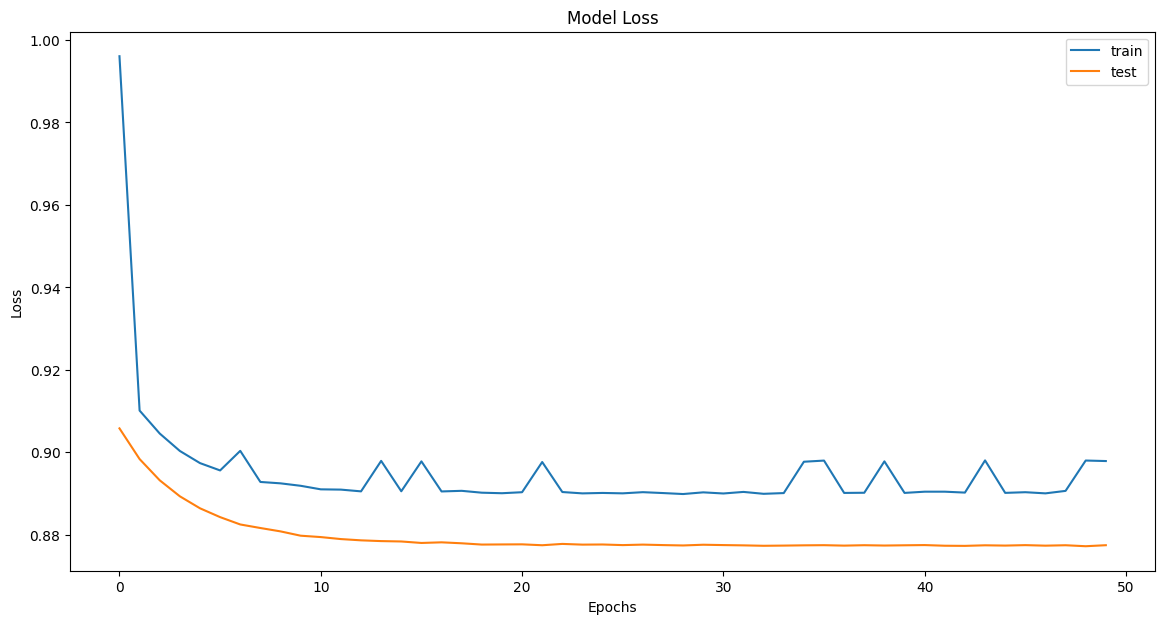

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 45.98%


For threshold set to 0.40, correctness is: 45.98%
For threshold set to 0.45, correctness is: 45.98%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 20, Epoch: 10, Accuracy: 46.51%
Chunk size: 20, Epoch: 20, Accuracy: 46.51%
Chunk size: 20, Epoch: 50, Accuracy: 46.51%

Data from file: script.py


Example sequence: ['import os']

: Counter({1: 12})
def get_color_from_number(number: int) -> str:: Counter({1: 1})
# reverse array as values are stored from newest to oldest: Counter({1: 1})
try:: Counter({1: 1})
class Colors:: Counter({1: 1})
colors = read_file(f"{file}"): Counter({1: 1})
if number == 0:: Counter({1: 1})
return Colors.BLACK: Counter({1: 1})
if not file.endswith(".csv"

ValueError: '' is not a valid color value.

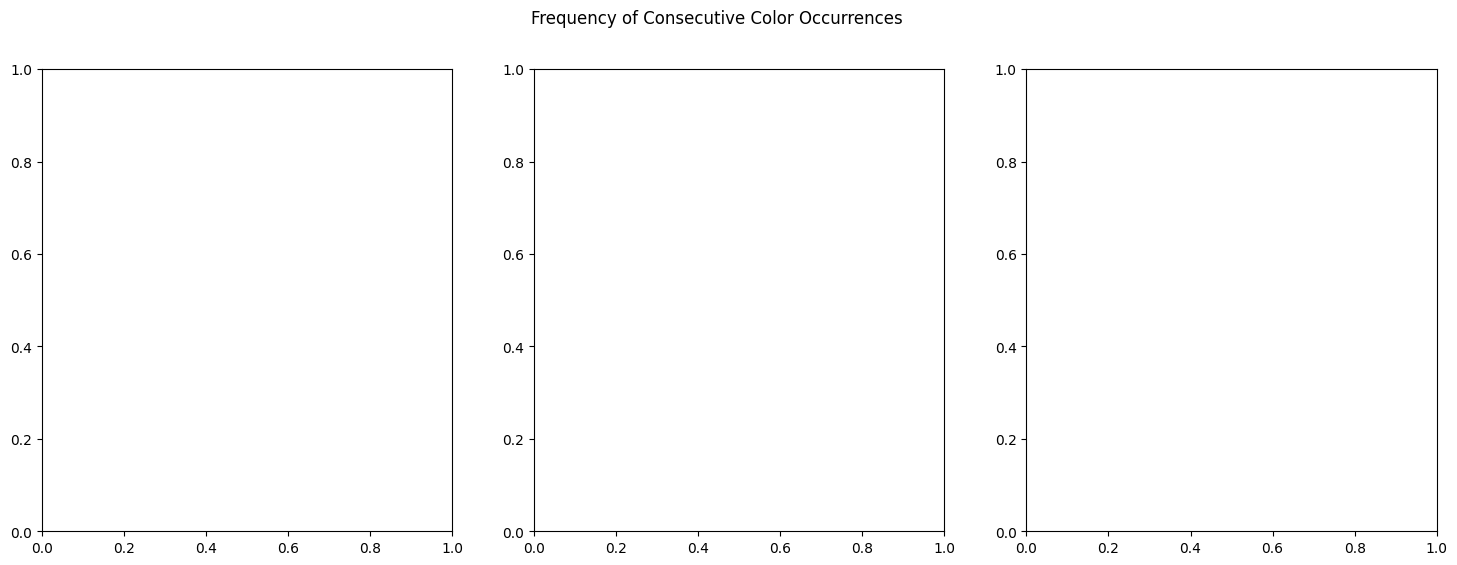

In [9]:
CHUNK_SIZES_TO_TEST = [2,5,10,15,20,40]
EPOCHS_TO_TEST = [10,20,50]

results = []
for file in os.listdir("data"):
    print(f"\n====================\nData from file: {file}\n====================\n")
    colors = read_file(f"data/{file}")
    top_accuracy = analize_dataset(colors, CHUNK_SIZES_TO_TEST, EPOCHS_TO_TEST)
    results.append((*top_accuracy, file))

results.sort(key=lambda x: x[2], reverse=True)
print("Top 3 results:")
for i in range(min(3, len(results))):
    chunk_size, epoch, accuracy, file = results[i]
    print(f"File: {file}, Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")